In [1]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, linewidth=0.5, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class EfficientSelfAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads,
        reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride = reduction_ratio, bias = False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias = False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h = heads, x = h, y = w)
        return self.to_out(out)

class MixFeedForward(nn.Module):
    def __init__(
        self,
        *,
        dim,
        expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)


## 컨볼루션 임베딩
class Embedding(nn.Module):
    def __init__(self, dim_in,dim_out, kernel_size, stride, padding):
        super(Embedding, self).__init__()
        self.embedding = nn.Conv2d(dim_in, 
                                   dim_out, 
                                   kernel_size=kernel_size, 
                                   stride=stride, 
                                   padding=padding)
        
    def forward(self, x):
        return self.embedding(x)
    
'''
5. MiT (Mixer Transformer)
이미지를 여러 스테이지로 처리합니다. 각 스테이지는 이미지를 패치로 나누고, 패치를 임베딩한 후, 여러 개의 Transformer 레이어를 적용합니다.
이 과정은 이미지의 다양한 해상도에서 특징을 추출합니다. 
'''    
class MiT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        dims,
        heads,
        ff_expansion,
        reduction_ratio,
        num_layers,
        stage_kernel_stride_pad = ((7, 4, 3),  
                                   (3, 2, 1), 
                                   (3, 2, 1), 
                                   (3, 2, 1))
    ):
        super().__init__()


        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(
            dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            #여기서 너비와 높이가 같은 정사각형 패치를 사용합니다.
            get_overlap_patches = nn.Unfold(kernel, stride = stride, padding = padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim = dim_out, heads = heads, reduction_ratio = reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim = dim_out, expansion_factor = ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
        self,
        x,
        return_layer_outputs = False
    ):
        h, w = x.shape[-2:]
        
        
        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)
            
            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            
            x = rearrange(x, 'b c (h w) -> b c h w', h = h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret
    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , dim, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

'''
6. Segformer
MiT를 통해 추출된 여러 스케일의 특징을 결합하고, 최종적으로 세그멘테이션 맵을 생성합니다.
각 스테이지의 출력을 디코더 차원으로 매핑하고, 업샘플링하여 동일한 해상도로 만든 후, 이를 결합합니다.
결합된 특징 맵을 사용하여 최종 세그멘테이션 맵을 생성합니다.
'''
class ARC_Net(nn.Module):
    def __init__(
        self,
        *,
        dims=(32, 64, 160, 256),
        heads=(1, 2, 5, 8),
        ff_expansion=(8, 8, 4, 4),
        reduction_ratio=(8, 4, 2, 1),
        num_layers=2,
        channels=1,
        num_classes=11,
        kernel_stride_paddings = ((1, 1, 0),(3, 2, 1), (3, 2, 1), (3, 2, 1))
    ):
        super().__init__()
        decoder_dim = dims[-1]
        
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=len(kernel_stride_paddings)), (dims, heads, ff_expansion, reduction_ratio, num_layers))

        
        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers,
            stage_kernel_stride_pad=kernel_stride_paddings
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor=2 ** i)
        ) for i, dim in enumerate(dims)])


        
        self.cbam = CBAM(gate_channels = decoder_dim * len(kernel_stride_paddings) * 2)  
        
        self.reduce = nn.Conv2d(decoder_dim * len(dims) * 2, decoder_dim * len(dims), 1)        
        
        self.to_segmentation = Head(decoder_dim*len(dims) * 3, decoder_dim*len(dims) , num_classes)
        
    def _fusion(self, x):
        x = self.mit(x, return_layer_outputs=True)
        fused = []
        for output, to_fused in zip(x, self.to_fused):
            x = to_fused(output)  # Conv2d 적용
            # 업샘플링하여 공간 크기를 맞춥니다.
            fused.append(x)
        fused = torch.cat(fused, dim=1)
        return fused    
    
    def forward(self, x, ex_inputs, ex_outputs):
        x = self._fusion(x) # [b,1,H,W] -> [b,dim_0,H,W],...,[b,dim_n, H//(n+1), W//(n+1)] 
                            # -> [b,dim_n, H, W],...,[b,dim_n, H, W] -> [b, dim_n * 2, H, W]
                            # [b, 256, 32, 32]
                            
        # 예제 입력과 출력을 채널 차원으로 분할
        n_examples = ex_inputs.size(1)  # n_examples * channels (여기서는 3)
        
        # 예제 수만큼 반복하면서 예제 입력과 출력을 처리
        fused = []
        for i in range(n_examples):
            ex_i = ex_inputs[:, i:i+1, :, :]  # [batch_size, 1, H, W]
            ex_o = ex_outputs[:, i:i+1, :, :]  # [batch_size, 1, H, W]
            
            ex_i = self._fusion(ex_i)
            ex_o = self._fusion(ex_o)
            
            ex_f = torch.cat([ex_i, ex_o], dim=1)
            ex_f = self.cbam(ex_f)
            ex_f = self.reduce(ex_f)
            fused.append(ex_f)
        
        for i, ex_f in enumerate(fused):
            ex_f = torch.cat([x, ex_f], dim=1)
            ex_f = self.cbam(ex_f)
            ex_f = self.reduce(ex_f)
            fused[i] = ex_f
        
        fused = torch.cat(fused, dim=1)
        output = self.to_segmentation(fused)
        
        return output

In [4]:
# 모델 생성 및 출력
model_args = {
    'dims': (64, 128),
    'heads': 4,
    'ff_expansion': 4,
    'reduction_ratio': 2,
    'num_layers': 4,
    'channels': 1,
    'num_classes': 11,
    'kernel_stride_paddings': ((1, 1, 0),(3, 2, 1))
    }

In [5]:
# dims, heads, ff_expansion, reduction_ratio, num_layers = map(
#             partial(cast_tuple, depth=4), (model_args['dims'], 
#                                            model_args['heads'], 
#                                            model_args['ff_expansion'], 
#                                            model_args['reduction_ratio'], 
#                                            model_args['num_layers']))
# mit = MiT(
#         dims=dims,
#         heads=heads,
#         ff_expansion=ff_expansion,
#         reduction_ratio=reduction_ratio,
#         num_layers=num_layers,
#         channels=model_args['channels'],
#         stage_kernel_stride_pad=model_args['kernel_stride_paddings'],
        
#           )
# x = torch.randn(10, 1, 30, 30)

# print("Input shape:", x.shape)
# x = mit(x,return_layer_outputs = True)

# print("Output shape:", x[0].shape)
# print("Output shape:", x[1].shape)

In [6]:
# x1 = x[0] + x[0]
# x1.shape

In [7]:
fuse = [torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32)]

x= torch.randn(10, 256, 32, 32)
for i , ex in enumerate(fuse) :
    print("fuse shape:", ex.shape)
    ex = torch.cat([ex, x], dim=1)
    print("fuse shape:", ex.shape)
    fuse[i] = ex
    print("fuse shape:", fuse[i].shape)
    print("==================")

fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 1, 32, 32).to(device)
e_i, e_o = torch.randn(10, 3, 32, 32).to(device), torch.randn(10, 3, 32, 32).to(device)
print(model(x,e_i,e_o).shape)

torch.Size([10, 11, 32, 32])


In [9]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = ARC_Net(**model_args).to(device)



from torchinfo import summary

summary(outer_model, input_size=((1, 1, 30, 30), (1, 3, 30, 30), (1, 3, 30, 30)))

Layer (type:depth-idx)                                                 Output Shape              Param #
ARC_Net                                                                [1, 11, 30, 30]           --
├─MiT: 1-1                                                             [1, 64, 30, 30]           --
│    └─ModuleList: 2-23                                                --                        (recursive)
│    │    └─ModuleList: 3-45                                           --                        (recursive)
│    │    └─ModuleList: 3-46                                           --                        (recursive)
├─ModuleList: 1-18                                                     --                        (recursive)
│    └─Sequential: 2-2                                                 [1, 128, 30, 30]          --
│    │    └─Conv2d: 3-3                                                [1, 128, 30, 30]          8,320
│    │    └─Upsample: 3-4                               

In [10]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [11]:
import torch
#weight = torch.ones(11).to('cuda')
#weight[0] = 0.0005  # 0은 무시
#print(weight)

In [12]:
import numpy as np
import os
import torch.optim as optim
from torch import nn
from copy import deepcopy
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
from itertools import combinations

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data
import random
from itertools import combinations

def one_hot_encoding(tensor):
    tensor = F.one_hot(tensor.long(), num_classes=11)
    tensor = tensor.permute(0, 3, 1, 2)
    tensor = tensor.squeeze(0)        
    return tensor

class ARC_Dataset(Dataset):
    def __init__(self, challenges, solution, task_data_num=1, example_data_num=3, max_combinations=10):
        challenges = load_json(challenges)
        solution = load_json(solution)
        self.data = []
        self.task_data_num = task_data_num
        self.example_data_num = example_data_num
        self.max_combinations = max_combinations

        for key, value in challenges.items():
            for i in range(len(value['test'])):
                task_input = value['test'][i]['input']
                task_output = solution[key][i]
                example_list = value['train'].copy()

                n_examples = len(example_list)  # 원래 예제의 개수

                # 예제 수가 example_data_num보다 적으면 현재 작업의 예제를 복제하여 채움
                if n_examples < self.example_data_num:
                    while len(example_list) < self.example_data_num:
                        example_list.append(random.choice(example_list))

                    # 조합은 예제 리스트 자체로 설정
                    ex_combinations = [tuple(example_list)]
                else:
                    # 예제의 조합 생성
                    ex_combinations = list(combinations(example_list, self.example_data_num))

                    # 조합의 수를 제한
                    if len(ex_combinations) > self.max_combinations:
                        ex_combinations = random.sample(ex_combinations, self.max_combinations)

                for ex_combo in ex_combinations:
                    ex_input = [ex['input'] for ex in ex_combo]
                    ex_output = [ex['output'] for ex in ex_combo]

                    # 데이터에 추가하면서 원래 예제의 개수도 포함
                    self.data.append({
                        'id': key,
                        'input': task_input,
                        'output': task_output,
                        'ex_input': ex_input,
                        'ex_output': ex_output,
                        'num_original_examples': n_examples  # 원래 예제 개수 추가
                    })

        # 리스트를 데이터프레임으로 변환
        self.df = pd.DataFrame(self.data)
        
    def __len__(self):
        return len(self.df)
    
    def pad_to_32x32(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 32 - h)
        pad_w = max(0, 32 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor
    
    def pad_to_30x30(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 30 - h)
        pad_w = max(0, 30 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor

    def mapping_input(self, tensor):
        mapping = {
            1: random.randint(1, 10),
            2: random.randint(11, 20),
            3: random.randint(21, 30),
            4: random.randint(31, 40),
            5: random.randint(41, 50),
            6: random.randint(51, 60),
            7: random.randint(61, 70),
            8: random.randint(71, 80),
            9: random.randint(81, 90),
            10: random.randint(91, 100)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def noise_input(self, tensor):
        mapping = {
            1: 1+ np.random.normal(0, 1),
            2: 2+ np.random.normal(0, 1),
            3: 3+ np.random.normal(0, 1),
            4: 4+ np.random.normal(0, 1),
            5: 5+ np.random.normal(0, 1),
            6: 6+ np.random.normal(0, 1),
            7: 7+ np.random.normal(0, 1),
            8: 8+ np.random.normal(0, 1),
            9: 9+ np.random.normal(0, 1),
            10: 10+ np.random.normal(0, 1)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def augment_example_output(self, tensor):
        # 출력 데이터 증강 (아직 구현 필요)
        return tensor

    def __getitem__(self, idx):
        task = self.df.iloc[idx]
        
        # task_input과 task_output 변환 및 패딩 추가
        task_input = self.pad_to_32x32((torch.tensor(task['input'], dtype=torch.float32) + 1))
        task_output = self.pad_to_32x32((torch.tensor(task['output'], dtype=torch.float32) + 1))
        
        # 입력 채널 차원 추가
        if task_input.dim() == 2:
            task_input = task_input.unsqueeze(0)  # [1, H, W]
        if task_output.dim() == 2:
            task_output = task_output.unsqueeze(0)  # [1, H, W]
        
        
        # 예제 입력과 출력 변환 및 패딩 추가
        example_input = []
        example_output = []
        for ex_in, ex_out in zip(task['ex_input'], task['ex_output']):
            ex_in_tensor = self.pad_to_32x32(torch.tensor(ex_in, dtype=torch.float32) + 1)
            ex_out_tensor = self.pad_to_32x32(torch.tensor(ex_out, dtype=torch.float32) + 1)
            
            # 입력 채널 차원 추가
            if ex_in_tensor.dim() == 2:
                ex_in_tensor = ex_in_tensor.unsqueeze(0)  # [1, H, W]
            if ex_out_tensor.dim() == 2:
                ex_out_tensor = ex_out_tensor.unsqueeze(0)  # [1, H, W]
            
            example_input.append(ex_in_tensor)
            example_output.append(ex_out_tensor)
        
        # 예제 입력과 출력을 채널 차원으로 결합
        ex_inputs = torch.cat(example_input, dim=0)  # [n_examples * channels, H, W]
        ex_outputs = torch.cat(example_output, dim=0)  # [n_examples * channels, H, W]
        
        return task_input, task_output, ex_inputs, ex_outputs

# 사용 예제
train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

ti, to, ei, eo = next(iter(train_loader))
print(ti.shape, to.shape, ei.shape, eo.shape)

torch.Size([10, 1, 32, 32]) torch.Size([10, 1, 32, 32]) torch.Size([10, 3, 32, 32]) torch.Size([10, 3, 32, 32])


Using cuda device



Epoch [1/1000] Complete
Average Loss: 1.464352
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 46.59%



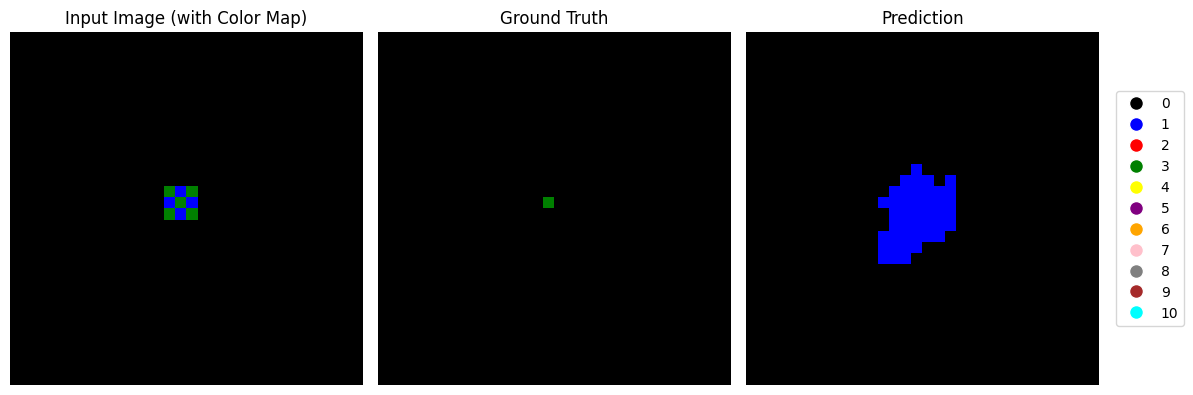

Test Average Loss: 1.767059
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.59%




Epoch [2/1000] Complete
Average Loss: 1.196416
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 54.72%



Test Average Loss: 1.464607
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.65%




Epoch [3/1000] Complete
Average Loss: 1.089405
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 57.85%



Test Average Loss: 1.337761
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.40%




Epoch [4/1000] Complete
Average Loss: 1.044920
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 59.96%



Test Average Loss: 1.312384
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.51%




Epoch [5/1000] Complete
Average Loss: 1.014002
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 60.58%



Test Average Loss: 1.305228
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.84%




Epoch [6/1000] Complete
Average Loss: 0.983762
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 61.00%



Test Average Loss: 1.299919
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.58%




Epoch [7/1000] Complete
Average Loss: 0.945334
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 64.55%



Test Average Loss: 1.282152
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 61.44%




Epoch [8/1000] Complete
Average Loss: 0.901134
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 65.03%



Test Average Loss: 1.461782
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.95%




Epoch [9/1000] Complete
Average Loss: 0.901586
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 65.99%



Test Average Loss: 1.294374
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 61.94%




Epoch [10/1000] Complete
Average Loss: 0.801321
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 68.14%



Test Average Loss: 1.304432
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.55%



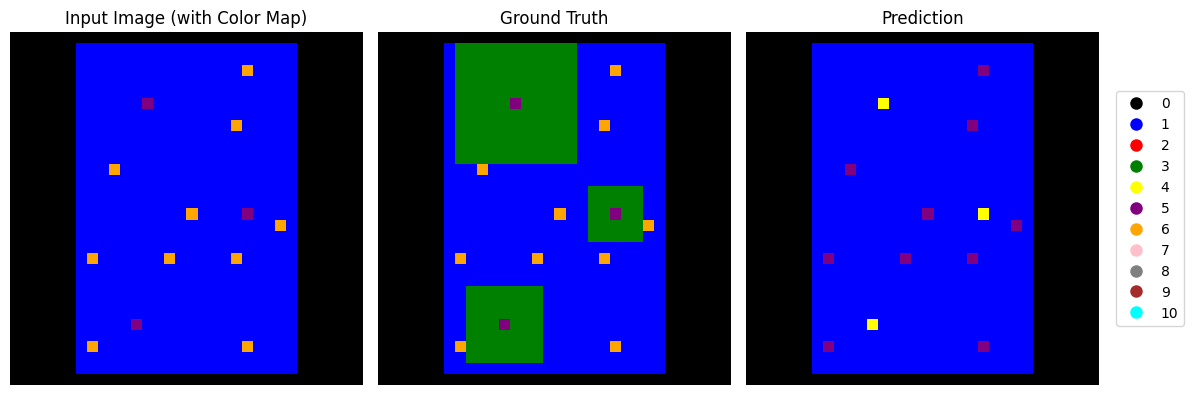


Epoch [11/1000] Complete
Average Loss: 0.774129
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 68.54%



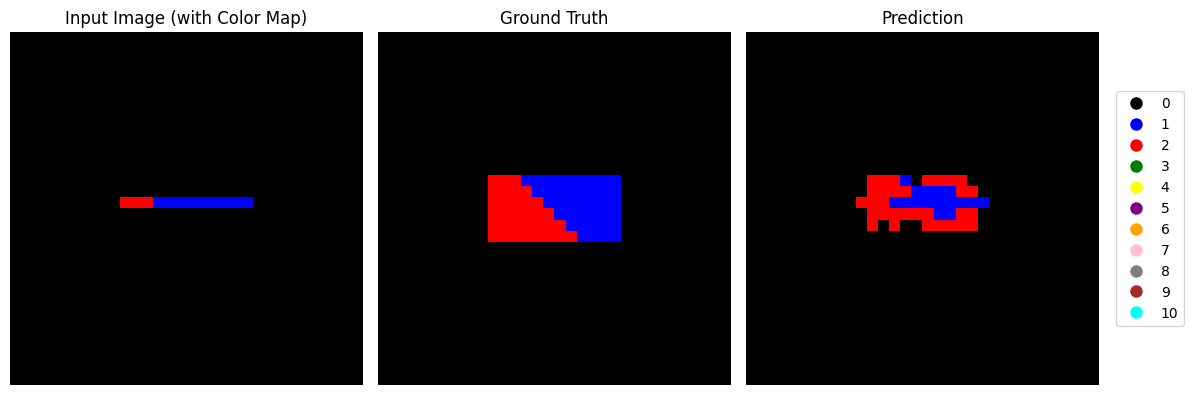

Test Average Loss: 1.672451
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.81%




Epoch [12/1000] Complete
Average Loss: 0.699900
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 72.16%



Test Average Loss: 1.423199
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.26%




Epoch [13/1000] Complete
Average Loss: 0.656535
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 73.19%



Test Average Loss: 1.566636
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.08%




Epoch [14/1000] Complete
Average Loss: 0.652674
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 74.43%



Test Average Loss: 1.496320
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.65%




Epoch [15/1000] Complete
Average Loss: 0.620202
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 75.22%



Test Average Loss: 1.605595
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.01%




Epoch [16/1000] Complete
Average Loss: 0.594070
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 75.98%



Test Average Loss: 1.827915
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.04%




Epoch [17/1000] Complete
Average Loss: 0.560910
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.68%



Test Average Loss: 1.653026
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.22%




Epoch [18/1000] Complete
Average Loss: 0.555651
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.67%



Test Average Loss: 1.682610
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.15%




Epoch [19/1000] Complete
Average Loss: 0.497417
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 79.83%



Test Average Loss: 1.671384
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.88%




Epoch [20/1000] Complete
Average Loss: 0.678235
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 72.71%



Test Average Loss: 1.976548
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.95%



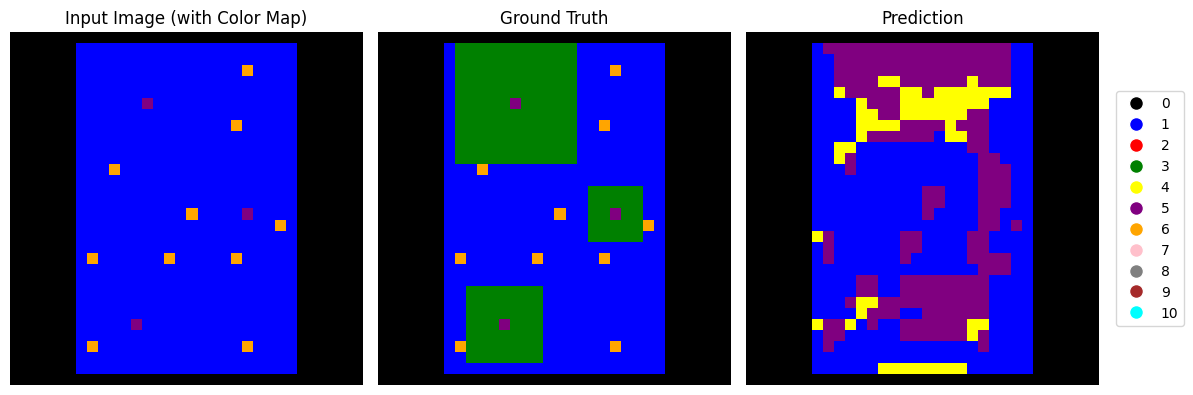


Epoch [21/1000] Complete
Average Loss: 0.663478
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 74.31%



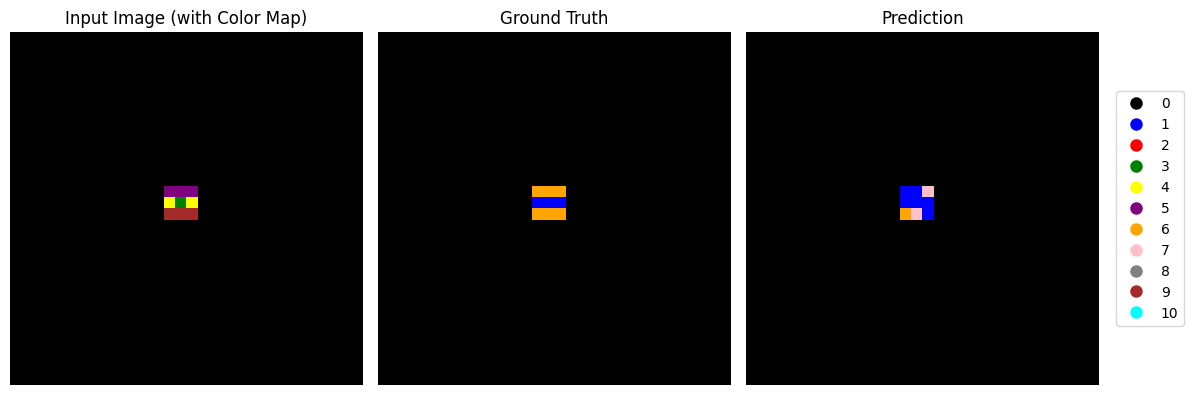

Test Average Loss: 2.321764
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.55%




Epoch [22/1000] Complete
Average Loss: 0.579188
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.13%



Test Average Loss: 1.809062
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.67%




Epoch [23/1000] Complete
Average Loss: 0.476148
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 81.19%



Test Average Loss: 1.749618
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.27%




Epoch [24/1000] Complete
Average Loss: 0.420127
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.84%



Test Average Loss: 2.102164
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.42%




Epoch [25/1000] Complete
Average Loss: 0.415727
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.46%



Test Average Loss: 1.821753
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.09%




Epoch [26/1000] Complete
Average Loss: 0.387601
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 83.50%



Test Average Loss: 2.217408
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.84%




Epoch [27/1000] Complete
Average Loss: 0.392560
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 83.64%



Test Average Loss: 1.989611
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.38%




Epoch [28/1000] Complete
Average Loss: 0.354504
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 85.00%



Test Average Loss: 2.043968
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.08%




Epoch [29/1000] Complete
Average Loss: 0.312198
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 86.42%



Test Average Loss: 1.994638
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 61.23%




Epoch [30/1000] Complete
Average Loss: 0.300672
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 87.14%



Test Average Loss: 2.315158
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.94%



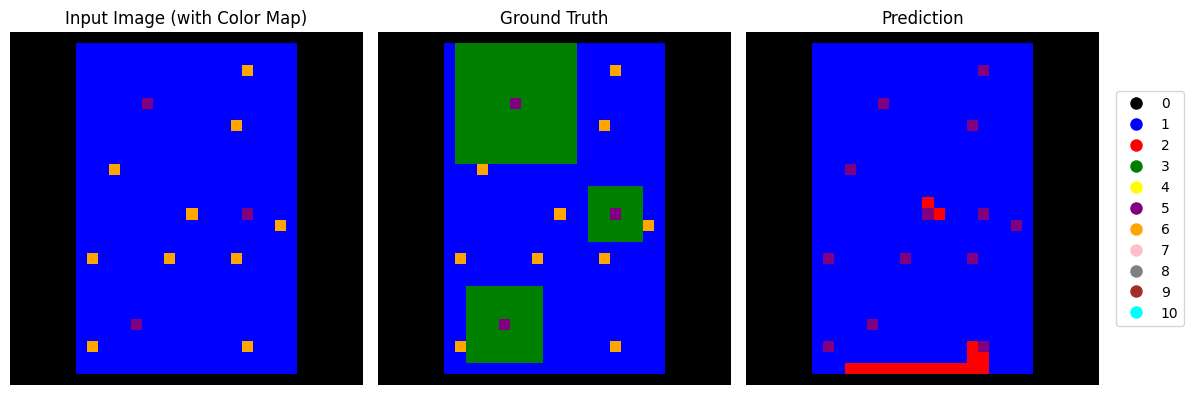


Epoch [31/1000] Complete
Average Loss: 0.295629
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 87.16%



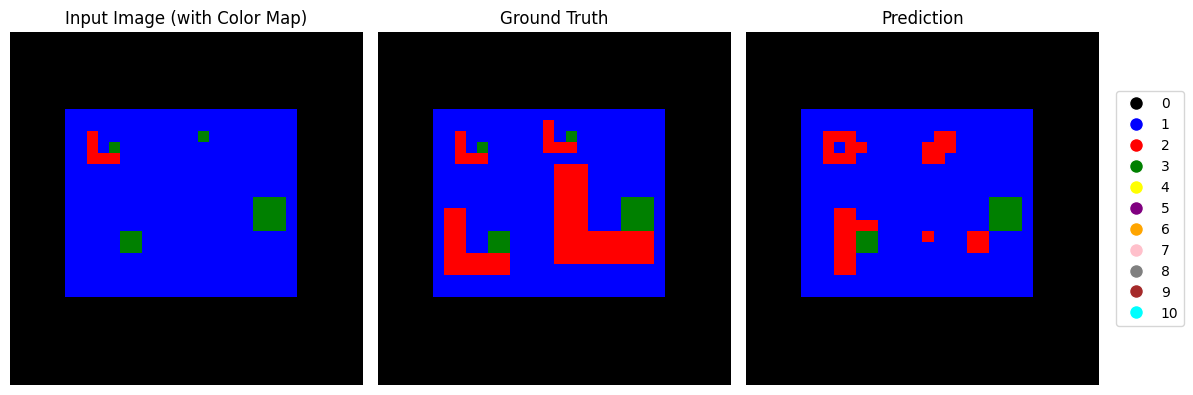

Test Average Loss: 2.306541
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.58%




Epoch [32/1000] Complete
Average Loss: 0.275595
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.26%



Test Average Loss: 2.110649
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.87%




Epoch [33/1000] Complete
Average Loss: 0.284906
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 87.88%



Test Average Loss: 2.345307
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.61%




Epoch [34/1000] Complete
Average Loss: 0.246206
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.85%



Test Average Loss: 2.268671
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.85%




Epoch [35/1000] Complete
Average Loss: 0.239497
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.44%



Test Average Loss: 2.364712
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.58%




Epoch [36/1000] Complete
Average Loss: 0.213621
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.46%



Test Average Loss: 2.586244
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.98%




Epoch [37/1000] Complete
Average Loss: 0.203494
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.41%



Test Average Loss: 2.408603
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.27%




Epoch [38/1000] Complete
Average Loss: 0.199143
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.94%



Test Average Loss: 2.429930
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.87%




Epoch [39/1000] Complete
Average Loss: 0.196320
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.88%



Test Average Loss: 2.788156
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.88%




Epoch [40/1000] Complete
Average Loss: 0.190380
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.38%



Test Average Loss: 2.346217
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.51%



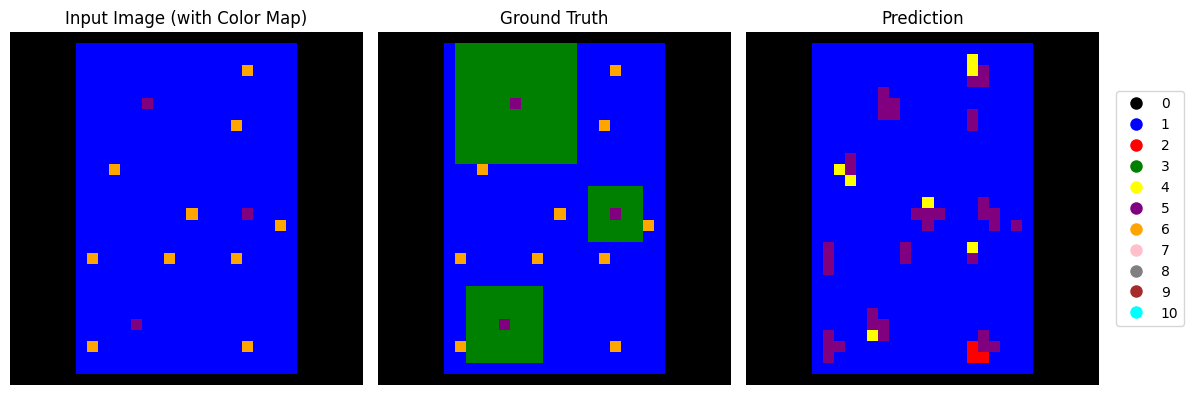


Epoch [41/1000] Complete
Average Loss: 0.197927
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.97%



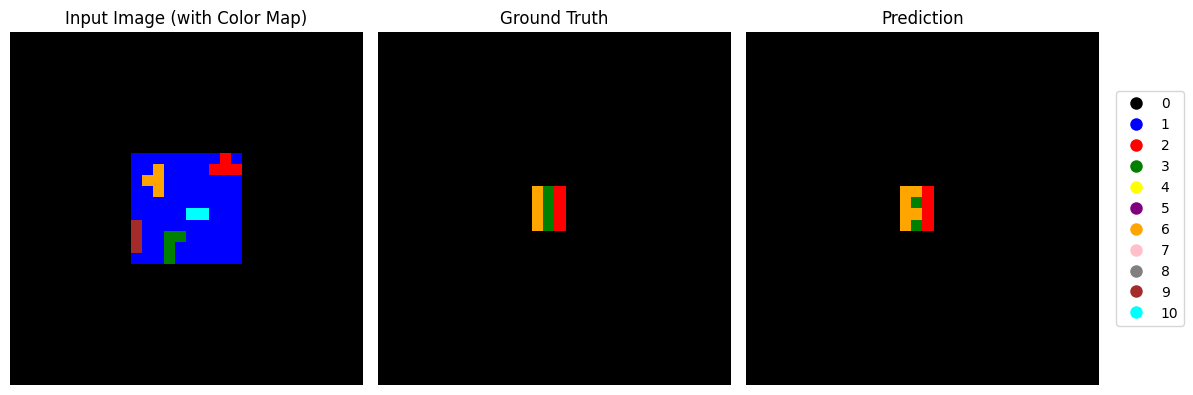

Test Average Loss: 2.700579
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.83%




Epoch [42/1000] Complete
Average Loss: 0.175773
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.97%



Test Average Loss: 2.829689
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.49%




Epoch [43/1000] Complete
Average Loss: 0.206715
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.81%



Test Average Loss: 2.936116
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.76%




Epoch [44/1000] Complete
Average Loss: 0.252358
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.08%



Test Average Loss: 2.604112
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.68%




Epoch [45/1000] Complete
Average Loss: 0.175458
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.04%



Test Average Loss: 2.824640
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.86%




Epoch [46/1000] Complete
Average Loss: 0.157631
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.94%



Test Average Loss: 2.804562
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.80%




Epoch [47/1000] Complete
Average Loss: 0.154458
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.72%



Test Average Loss: 2.577963
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 62.39%




Epoch [48/1000] Complete
Average Loss: 0.154422
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.05%



Test Average Loss: 3.245989
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.40%




Epoch [49/1000] Complete
Average Loss: 0.135182
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.66%



Test Average Loss: 2.713800
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.16%




Epoch [50/1000] Complete
Average Loss: 0.135924
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.69%



Test Average Loss: 2.797389
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.95%



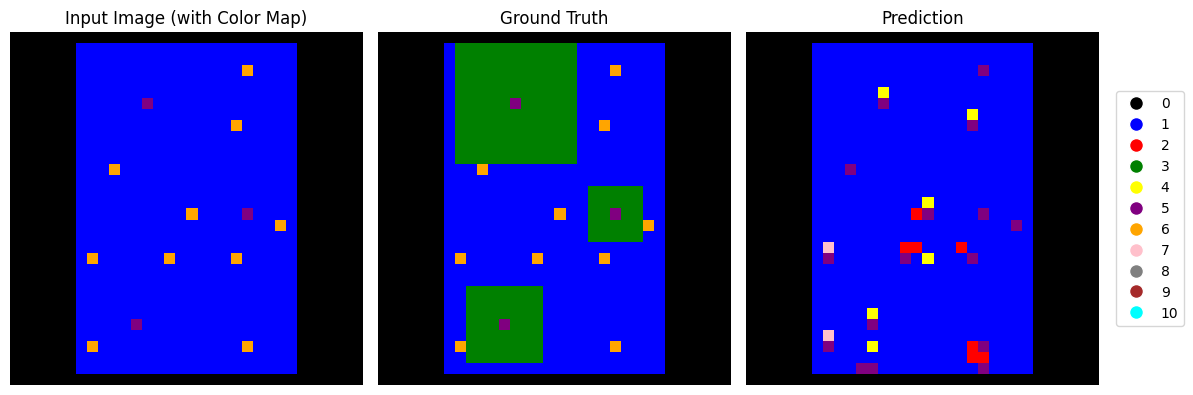


Epoch [51/1000] Complete
Average Loss: 0.120671
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.44%



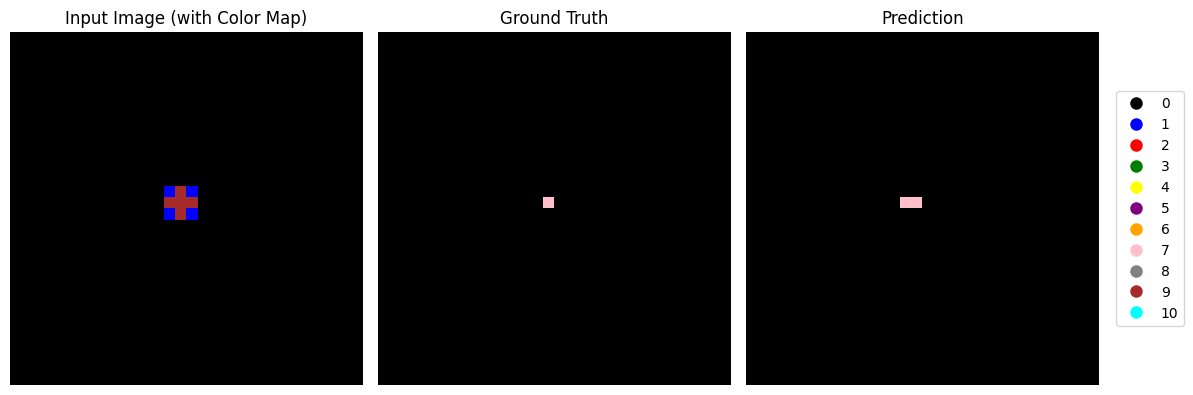

Test Average Loss: 3.204907
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.55%




Epoch [52/1000] Complete
Average Loss: 0.124471
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.29%



Test Average Loss: 2.974240
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.95%




Epoch [53/1000] Complete
Average Loss: 0.108448
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.85%



Test Average Loss: 2.978782
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.76%




Epoch [54/1000] Complete
Average Loss: 0.099010
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.31%



Test Average Loss: 3.035761
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.47%




Epoch [55/1000] Complete
Average Loss: 0.123067
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.23%



Test Average Loss: 2.666426
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 61.03%




Epoch [56/1000] Complete
Average Loss: 0.114093
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.98%



Test Average Loss: 3.122806
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.78%




Epoch [57/1000] Complete
Average Loss: 0.090947
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.73%



Test Average Loss: 3.009301
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 61.60%




Epoch [58/1000] Complete
Average Loss: 0.092211
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.58%



Test Average Loss: 3.279547
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.04%




Epoch [59/1000] Complete
Average Loss: 0.102512
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.35%



Test Average Loss: 3.571866
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.10%




Epoch [60/1000] Complete
Average Loss: 0.103678
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.29%



Test Average Loss: 3.339062
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.90%



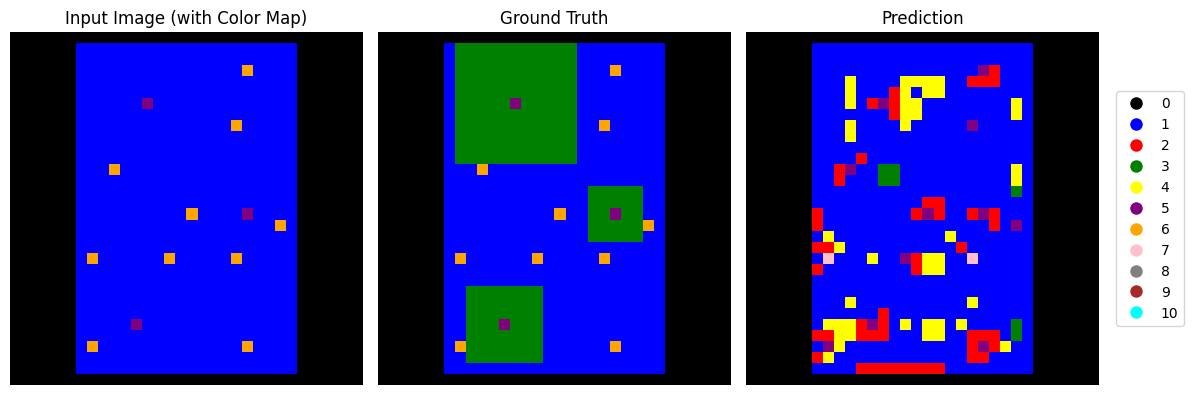


Epoch [61/1000] Complete
Average Loss: 0.123864
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.67%



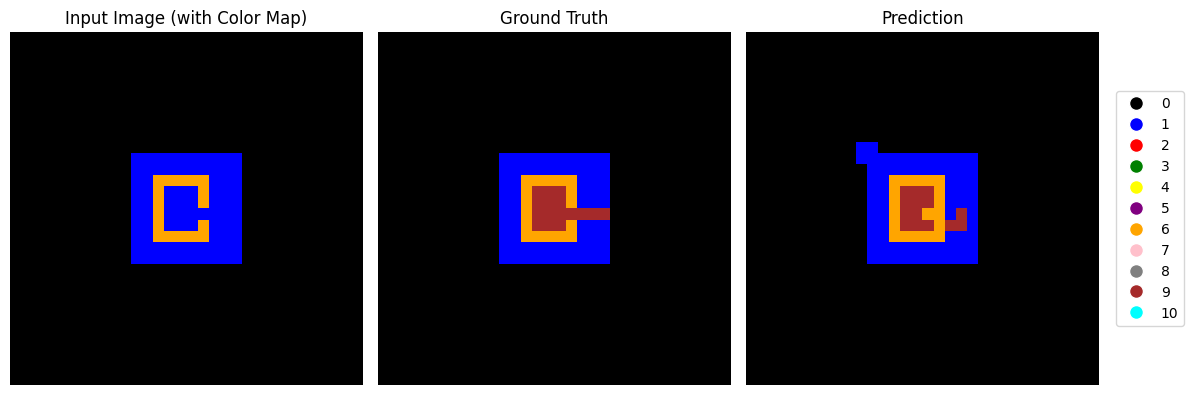

Test Average Loss: 3.539225
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.93%




Epoch [62/1000] Complete
Average Loss: 0.125076
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.63%



Test Average Loss: 2.810215
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.83%




Epoch [63/1000] Complete
Average Loss: 0.102367
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.31%



Test Average Loss: 3.224726
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.54%




Epoch [64/1000] Complete
Average Loss: 0.080246
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.23%



Test Average Loss: 3.350664
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.46%




Epoch [65/1000] Complete
Average Loss: 0.091188
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.09%



Test Average Loss: 3.261840
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.43%




Epoch [66/1000] Complete
Average Loss: 0.150176
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.54%



Test Average Loss: 3.311429
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.67%




Epoch [67/1000] Complete
Average Loss: 0.093917
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.78%



Test Average Loss: 3.807844
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.77%




Epoch [68/1000] Complete
Average Loss: 0.089118
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.98%



Test Average Loss: 3.763023
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.45%




Epoch [69/1000] Complete
Average Loss: 0.080472
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.19%



Test Average Loss: 3.682406
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.89%




Epoch [70/1000] Complete
Average Loss: 0.160245
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.93%



Test Average Loss: 2.631814
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.47%



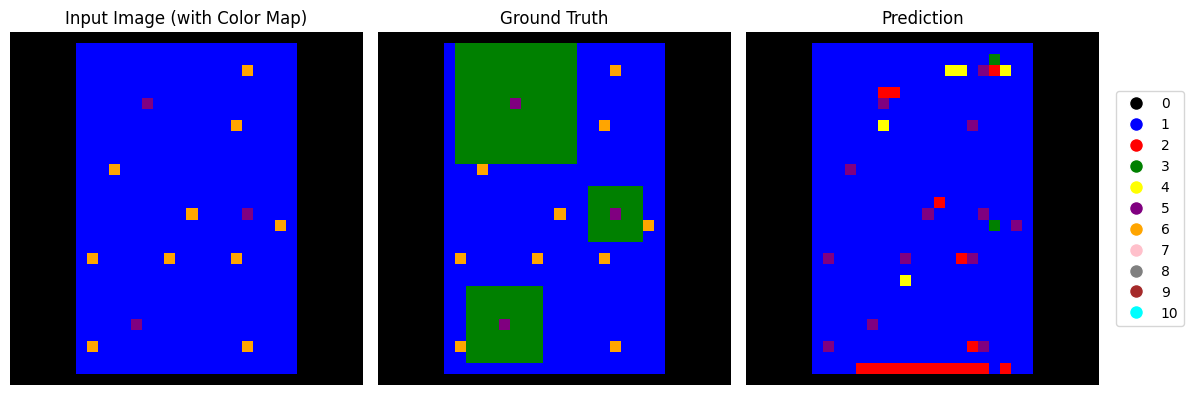


Epoch [71/1000] Complete
Average Loss: 0.183349
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.65%



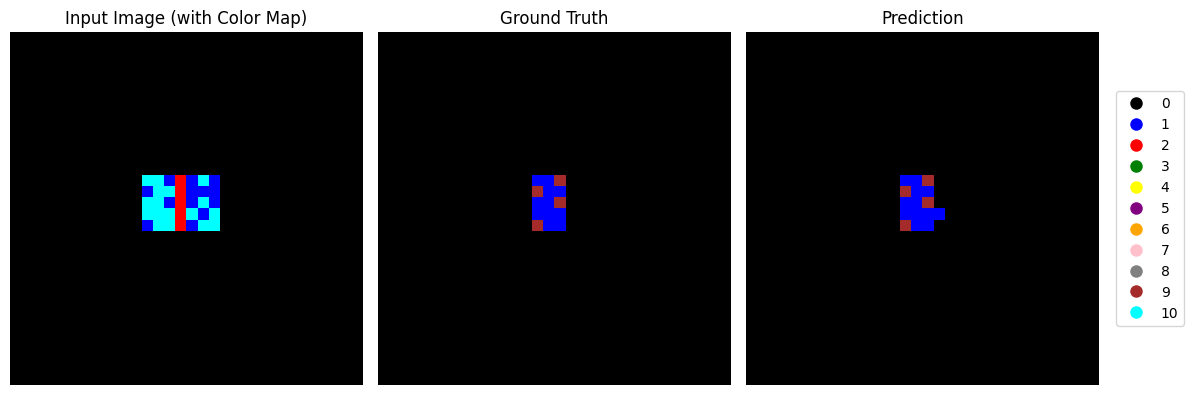

Test Average Loss: 3.414536
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.87%




Epoch [72/1000] Complete
Average Loss: 0.100925
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.59%



Test Average Loss: 3.561595
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.09%




Epoch [73/1000] Complete
Average Loss: 0.079688
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.71%



Test Average Loss: 3.520914
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.76%




Epoch [74/1000] Complete
Average Loss: 0.072498
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.78%



Test Average Loss: 3.334194
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.68%




Epoch [75/1000] Complete
Average Loss: 0.070179
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.90%



Test Average Loss: 3.483287
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.15%




Epoch [76/1000] Complete
Average Loss: 0.090275
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.68%



Test Average Loss: 3.527655
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.03%




Epoch [77/1000] Complete
Average Loss: 0.173624
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.17%



Test Average Loss: 3.754038
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.17%




Epoch [78/1000] Complete
Average Loss: 0.122347
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.66%



Test Average Loss: 3.684906
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.61%




Epoch [79/1000] Complete
Average Loss: 0.111015
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.47%



Test Average Loss: 3.787596
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.58%




Epoch [80/1000] Complete
Average Loss: 0.079926
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.38%



Test Average Loss: 4.036853
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.64%



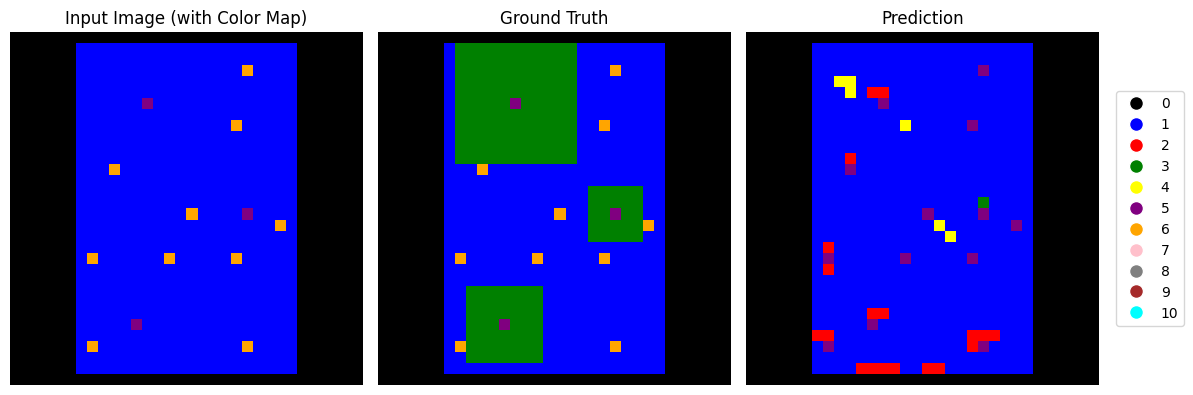


Epoch [81/1000] Complete
Average Loss: 0.077617
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.80%



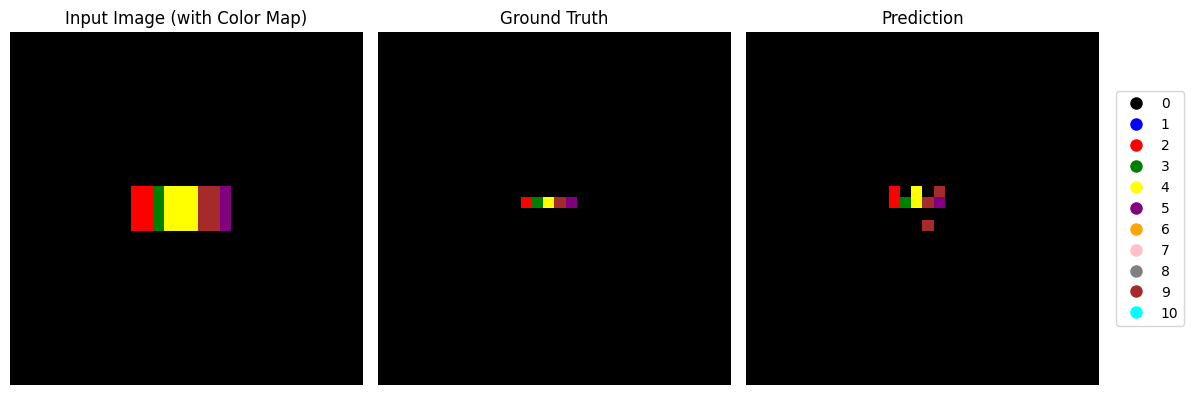

Test Average Loss: 3.753697
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.31%




Epoch [82/1000] Complete
Average Loss: 0.150285
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.37%



Test Average Loss: 3.877688
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.94%




Epoch [83/1000] Complete
Average Loss: 0.106157
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.28%



Test Average Loss: 3.894593
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.94%




Epoch [84/1000] Complete
Average Loss: 0.075290
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.71%



Test Average Loss: 4.262772
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.10%




Epoch [85/1000] Complete
Average Loss: 0.058587
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.39%



Test Average Loss: 3.960161
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.52%




Epoch [86/1000] Complete
Average Loss: 0.050496
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.83%



Test Average Loss: 4.063718
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.93%




Epoch [87/1000] Complete
Average Loss: 0.038642
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.31%



Test Average Loss: 4.550385
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.78%




Epoch [88/1000] Complete
Average Loss: 0.041275
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.31%



Test Average Loss: 4.461420
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.85%




Epoch [89/1000] Complete
Average Loss: 0.039137
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.39%



Test Average Loss: 4.398850
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.74%




Epoch [90/1000] Complete
Average Loss: 0.032500
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.52%



Test Average Loss: 4.363979
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.40%



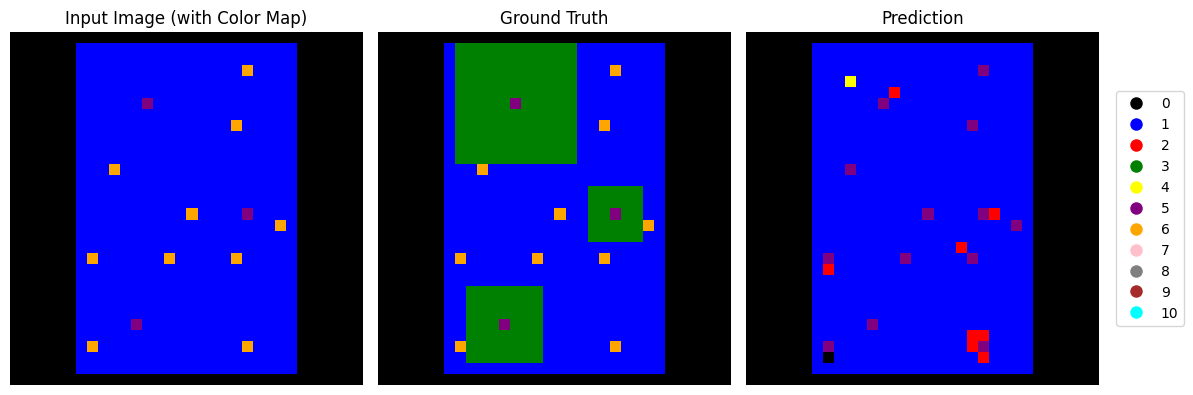


Epoch [91/1000] Complete
Average Loss: 0.028413
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.81%



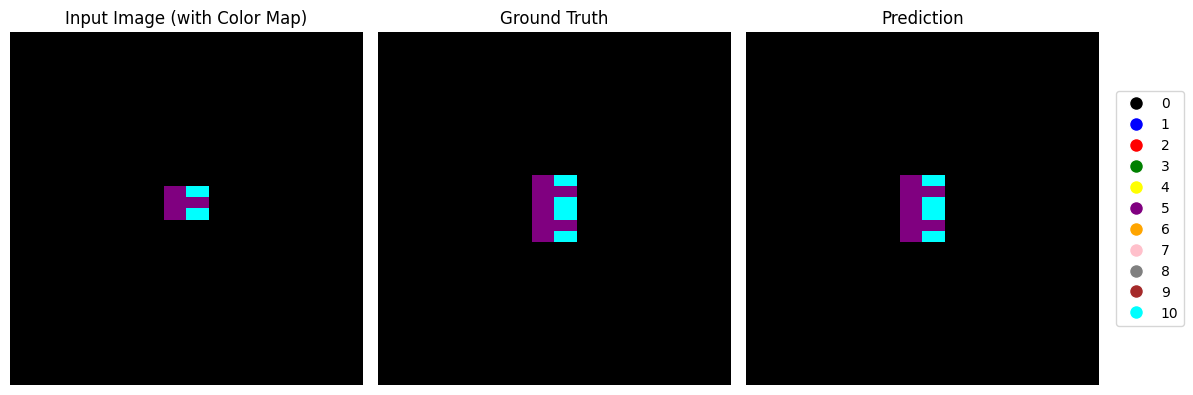

Test Average Loss: 3.965778
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.87%




Epoch [92/1000] Complete
Average Loss: 0.026733
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.80%



Test Average Loss: 4.666181
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.19%




Epoch [93/1000] Complete
Average Loss: 0.023947
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.99%



Test Average Loss: 4.594242
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.37%




Epoch [94/1000] Complete
Average Loss: 0.032025
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.67%



Test Average Loss: 4.527311
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.93%




Epoch [95/1000] Complete
Average Loss: 0.025888
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.01%



Test Average Loss: 4.231839
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.25%




Epoch [96/1000] Complete
Average Loss: 0.028673
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.84%



Test Average Loss: 4.305406
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.28%




Epoch [97/1000] Complete
Average Loss: 0.040469
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.38%



Test Average Loss: 4.274310
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.51%




Epoch [98/1000] Complete
Average Loss: 0.042442
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.18%



Test Average Loss: 3.982768
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.91%




Epoch [99/1000] Complete
Average Loss: 0.048921
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.03%



Test Average Loss: 5.060114
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.97%




Epoch [100/1000] Complete
Average Loss: 0.058416
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.52%



Test Average Loss: 4.501953
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.18%



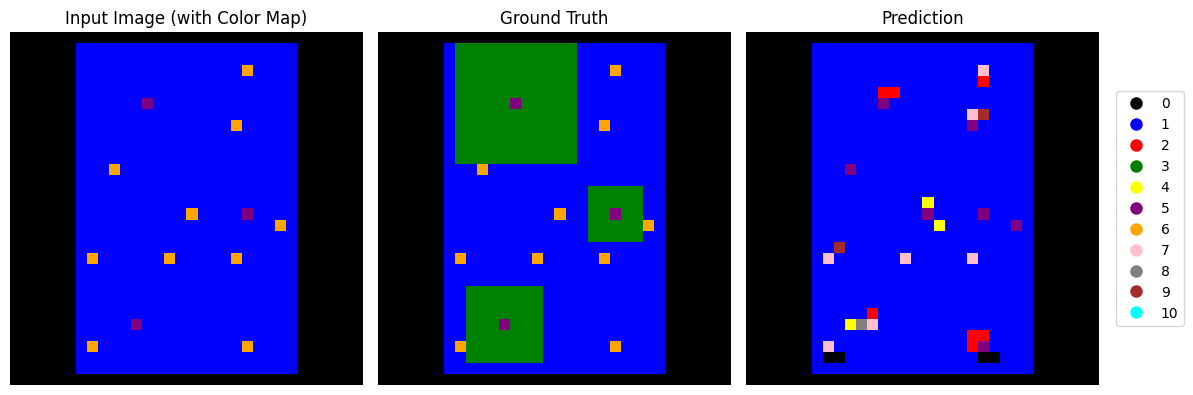


Epoch [101/1000] Complete
Average Loss: 0.056313
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.67%



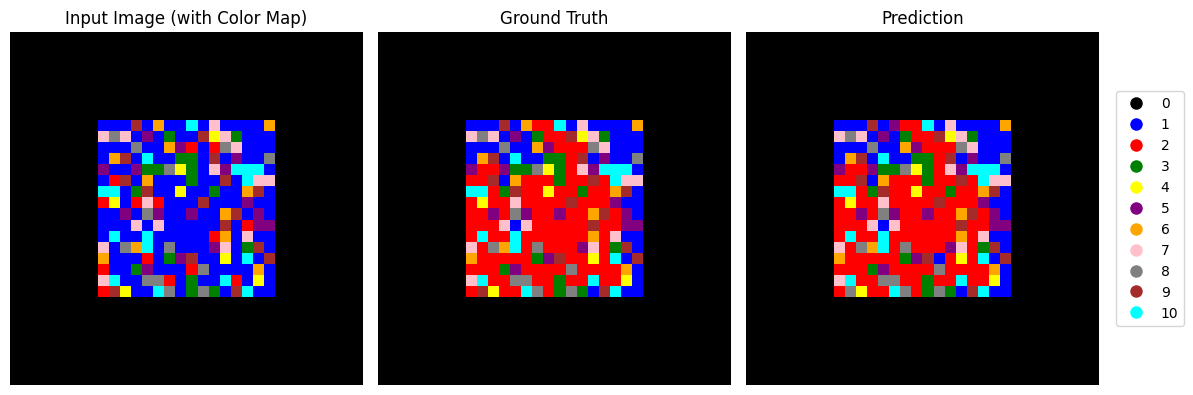

Test Average Loss: 4.262997
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.29%




Epoch [102/1000] Complete
Average Loss: 0.039698
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.29%



Test Average Loss: 4.094602
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.05%




Epoch [103/1000] Complete
Average Loss: 0.033137
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.64%



Test Average Loss: 4.389837
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.11%




Epoch [104/1000] Complete
Average Loss: 0.042283
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.27%



Test Average Loss: 3.306735
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.78%




Epoch [105/1000] Complete
Average Loss: 0.088237
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.07%



Test Average Loss: 3.886831
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.19%




Epoch [106/1000] Complete
Average Loss: 0.461516
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.27%



Test Average Loss: 3.167779
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 45.96%




Epoch [107/1000] Complete
Average Loss: 0.288700
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.09%



Test Average Loss: 3.361267
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.85%




Epoch [108/1000] Complete
Average Loss: 0.127204
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.58%



Test Average Loss: 3.929003
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.40%




Epoch [109/1000] Complete
Average Loss: 0.093379
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.86%



Test Average Loss: 4.265595
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.96%




Epoch [110/1000] Complete
Average Loss: 0.069185
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.24%



Test Average Loss: 4.421251
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.66%



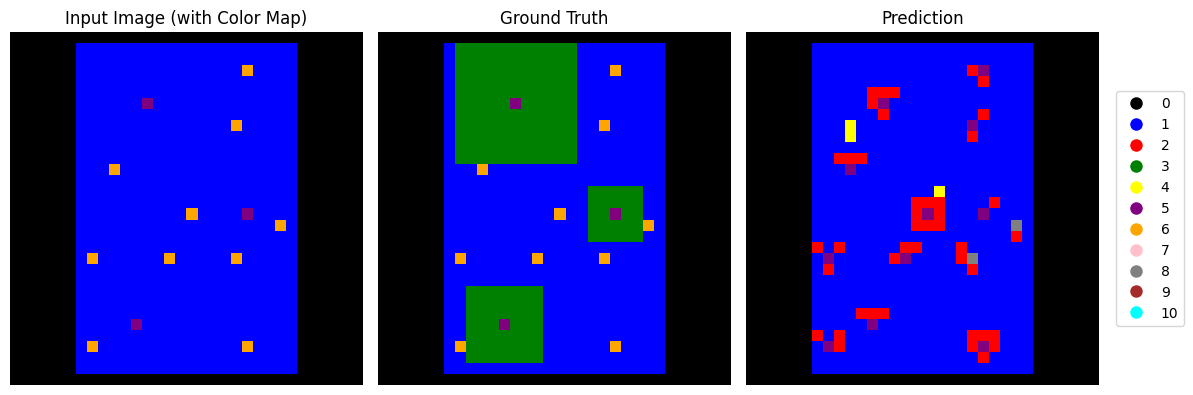


Epoch [111/1000] Complete
Average Loss: 0.060452
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.49%



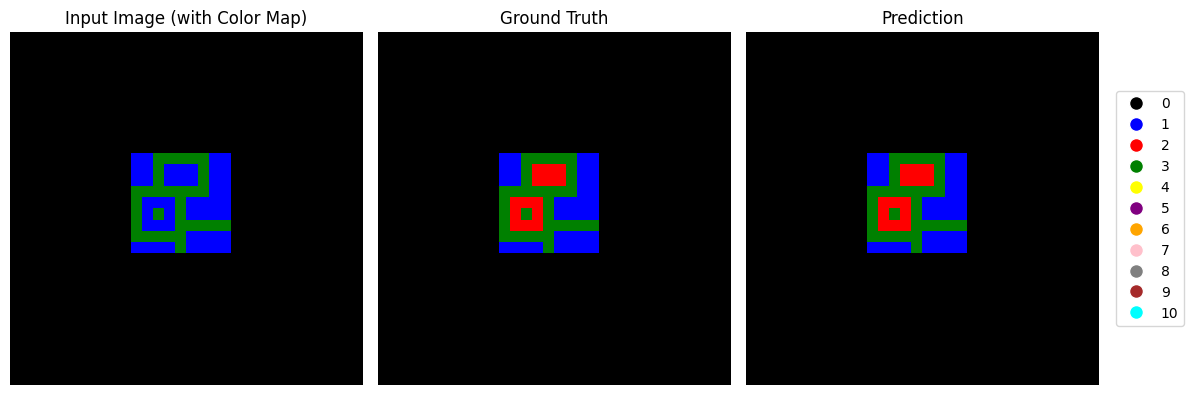

Test Average Loss: 4.626421
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.49%




Epoch [112/1000] Complete
Average Loss: 0.044885
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.07%



Test Average Loss: 4.673682
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.52%




Epoch [113/1000] Complete
Average Loss: 0.041460
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.38%



Test Average Loss: 4.198015
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.95%




Epoch [114/1000] Complete
Average Loss: 0.028811
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.76%



Test Average Loss: 4.141891
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.20%




Epoch [115/1000] Complete
Average Loss: 0.034326
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.64%



Test Average Loss: 3.896824
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.85%




Epoch [116/1000] Complete
Average Loss: 0.023958
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.98%



Test Average Loss: 4.122077
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.00%




Epoch [117/1000] Complete
Average Loss: 0.013721
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.40%



Test Average Loss: 5.005614
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.16%




Epoch [118/1000] Complete
Average Loss: 0.012337
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.48%



Test Average Loss: 4.358866
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.02%




Epoch [119/1000] Complete
Average Loss: 0.014344
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.41%



Test Average Loss: 5.670833
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.87%




Epoch [120/1000] Complete
Average Loss: 0.011682
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.49%



Test Average Loss: 4.877751
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.22%



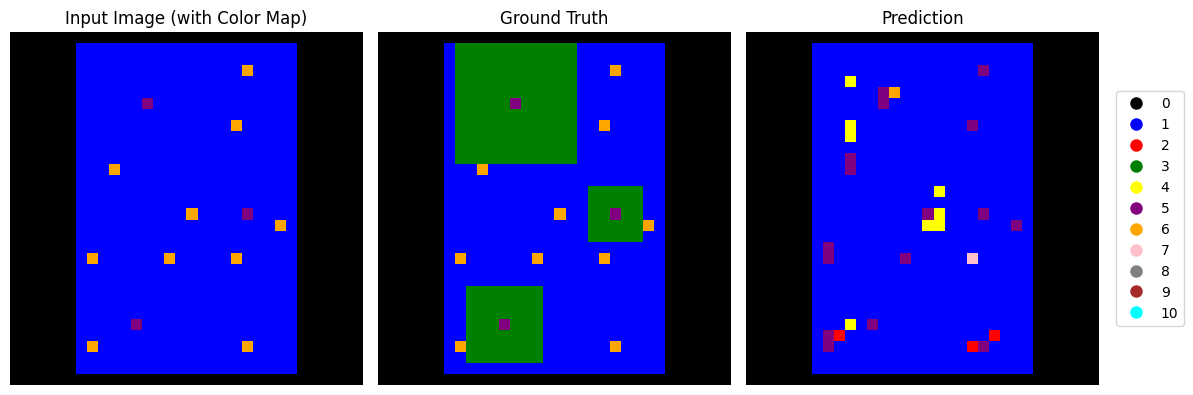


Epoch [121/1000] Complete
Average Loss: 0.019986
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.37%



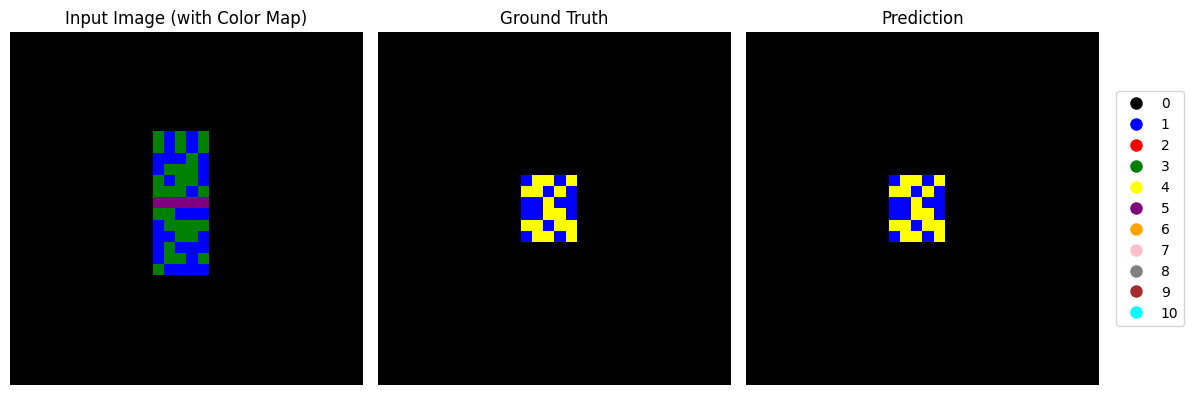

Test Average Loss: 5.483817
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.29%




Epoch [122/1000] Complete
Average Loss: 0.014029
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.42%



Test Average Loss: 4.507654
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.95%




Epoch [123/1000] Complete
Average Loss: 0.017872
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.21%



Test Average Loss: 4.775896
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.64%




Epoch [124/1000] Complete
Average Loss: 0.024995
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.00%



Test Average Loss: 4.296725
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.38%




Epoch [125/1000] Complete
Average Loss: 0.034529
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.80%



Test Average Loss: 4.892921
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.66%




Epoch [126/1000] Complete
Average Loss: 0.022526
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.03%



Test Average Loss: 3.888665
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.16%




Epoch [127/1000] Complete
Average Loss: 0.031809
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.84%



Test Average Loss: 4.743663
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.37%




Epoch [128/1000] Complete
Average Loss: 0.028599
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.84%



Test Average Loss: 4.688184
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.01%




Epoch [129/1000] Complete
Average Loss: 0.019955
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.24%



Test Average Loss: 3.721269
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.54%




Epoch [130/1000] Complete
Average Loss: 0.019978
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.34%



Test Average Loss: 4.776565
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.21%



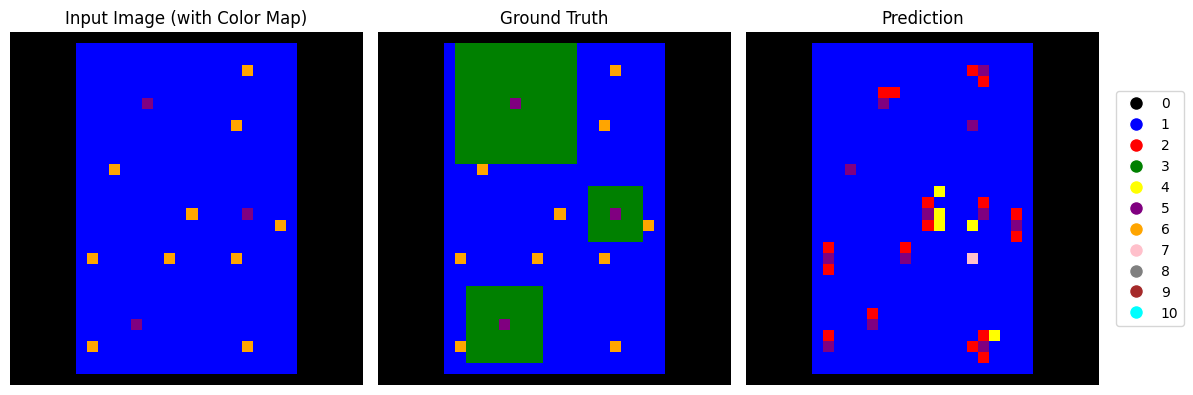


Epoch [131/1000] Complete
Average Loss: 0.017886
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.40%



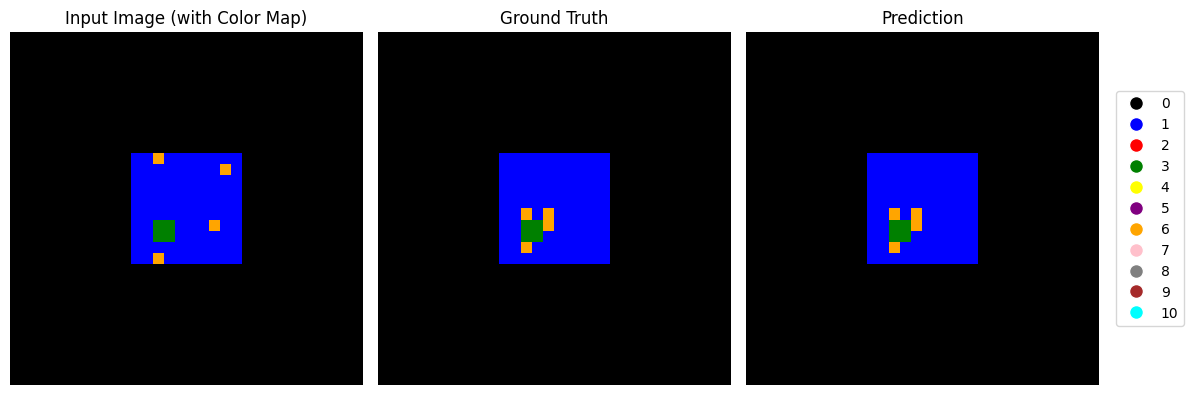

Test Average Loss: 4.208324
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.47%




Epoch [132/1000] Complete
Average Loss: 0.014424
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.43%



Test Average Loss: 5.230690
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.84%




Epoch [133/1000] Complete
Average Loss: 0.016635
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.35%



Test Average Loss: 5.283872
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.52%




Epoch [134/1000] Complete
Average Loss: 0.012217
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 4.540090
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.13%




Epoch [135/1000] Complete
Average Loss: 0.010856
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 3.855621
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.41%




Epoch [136/1000] Complete
Average Loss: 0.012869
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.55%



Test Average Loss: 5.574789
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.58%




Epoch [137/1000] Complete
Average Loss: 0.009952
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 5.288229
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.27%




Epoch [138/1000] Complete
Average Loss: 0.008910
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 5.070099
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.81%




Epoch [139/1000] Complete
Average Loss: 0.013210
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.52%



Test Average Loss: 5.287940
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.76%




Epoch [140/1000] Complete
Average Loss: 0.017468
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.36%



Test Average Loss: 5.575688
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.26%



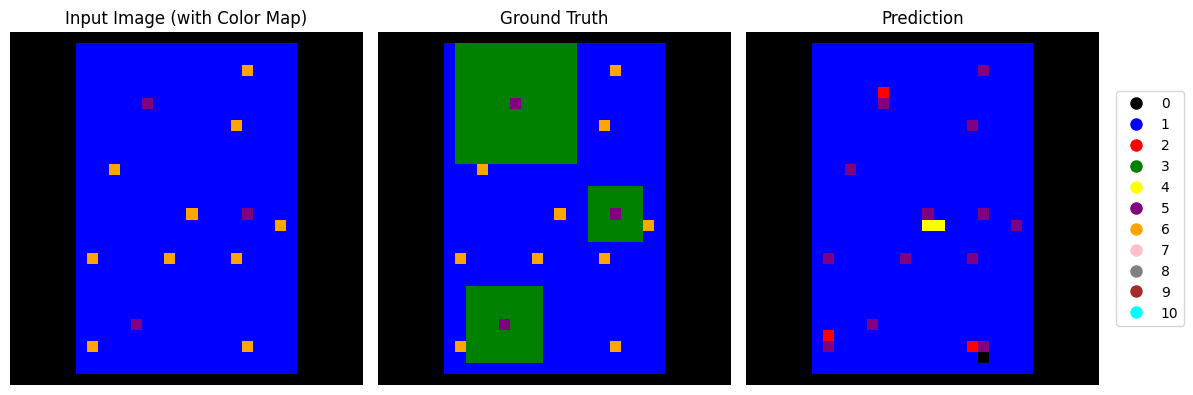


Epoch [141/1000] Complete
Average Loss: 0.031568
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.87%



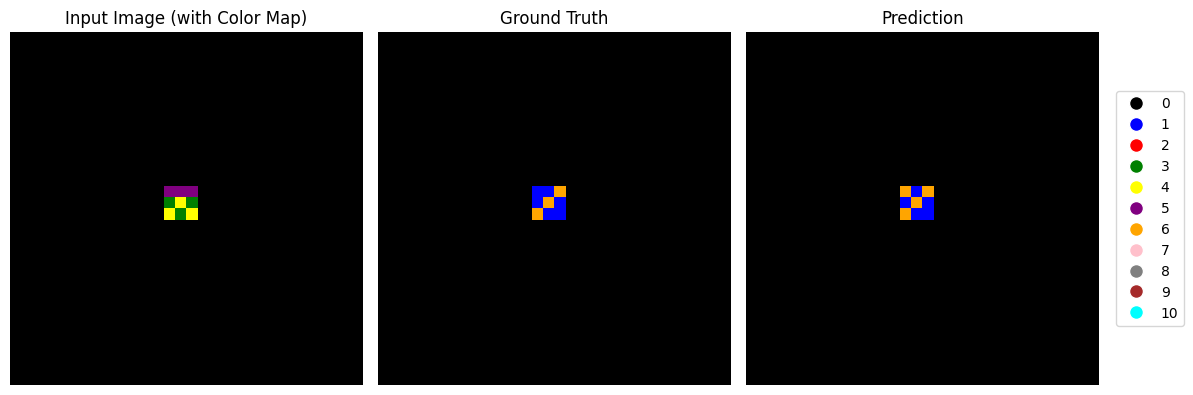

Test Average Loss: 3.818267
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.07%




Epoch [142/1000] Complete
Average Loss: 0.064565
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.47%



Test Average Loss: 5.223746
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.53%




Epoch [143/1000] Complete
Average Loss: 0.070153
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.23%



Test Average Loss: 4.263896
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.39%




Epoch [144/1000] Complete
Average Loss: 0.189664
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.96%



Test Average Loss: 5.212831
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.98%




Epoch [145/1000] Complete
Average Loss: 0.127981
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.74%



Test Average Loss: 4.393508
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.49%




Epoch [146/1000] Complete
Average Loss: 0.068337
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.20%



Test Average Loss: 3.741008
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.52%




Epoch [147/1000] Complete
Average Loss: 0.069621
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.20%



Test Average Loss: 4.560751
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.44%




Epoch [148/1000] Complete
Average Loss: 0.036505
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.47%



Test Average Loss: 4.879001
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.38%




Epoch [149/1000] Complete
Average Loss: 0.032877
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.72%



Test Average Loss: 5.065154
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.26%




Epoch [150/1000] Complete
Average Loss: 0.028060
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.94%



Test Average Loss: 4.242304
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.67%



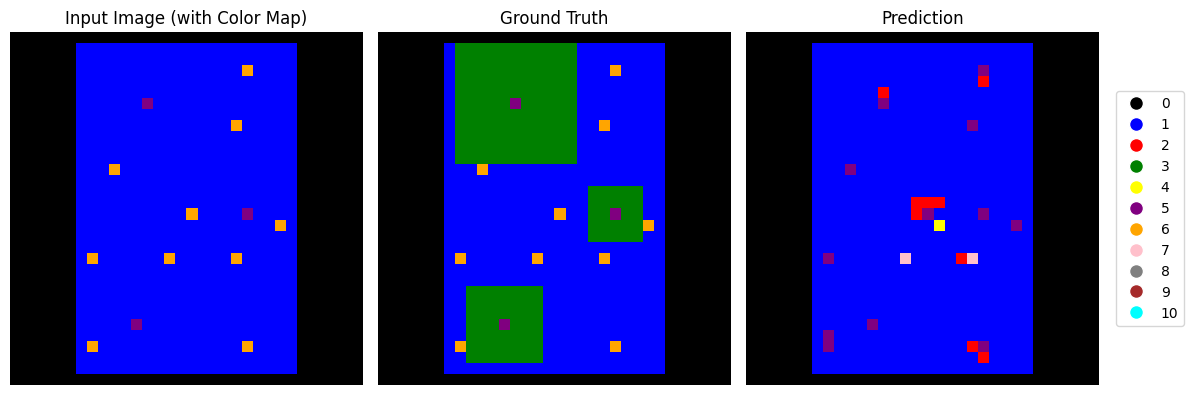


Epoch [151/1000] Complete
Average Loss: 0.026115
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.93%



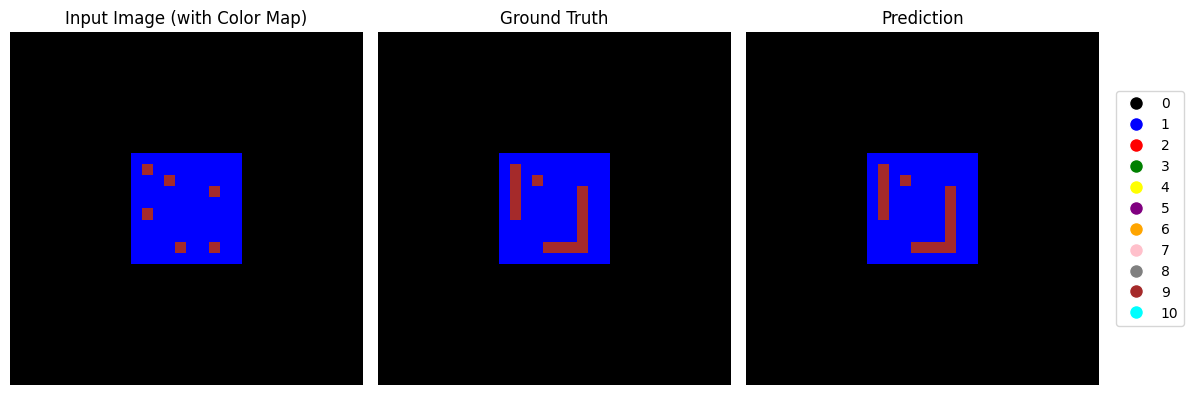

Test Average Loss: 5.086940
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.05%




Epoch [152/1000] Complete
Average Loss: 0.016367
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.37%



Test Average Loss: 6.096788
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.97%




Epoch [153/1000] Complete
Average Loss: 0.014173
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.51%



Test Average Loss: 5.459424
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.82%




Epoch [154/1000] Complete
Average Loss: 0.010437
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 5.579507
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.64%




Epoch [155/1000] Complete
Average Loss: 0.006452
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



Test Average Loss: 5.903341
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.25%




Epoch [156/1000] Complete
Average Loss: 0.007068
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



Test Average Loss: 5.564447
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.24%




Epoch [157/1000] Complete
Average Loss: 0.006514
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.72%



Test Average Loss: 5.570862
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.19%




Epoch [158/1000] Complete
Average Loss: 0.007113
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 6.455728
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.06%




Epoch [159/1000] Complete
Average Loss: 0.007679
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.71%



Test Average Loss: 5.627099
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.40%




Epoch [160/1000] Complete
Average Loss: 0.007853
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 5.981586
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.80%



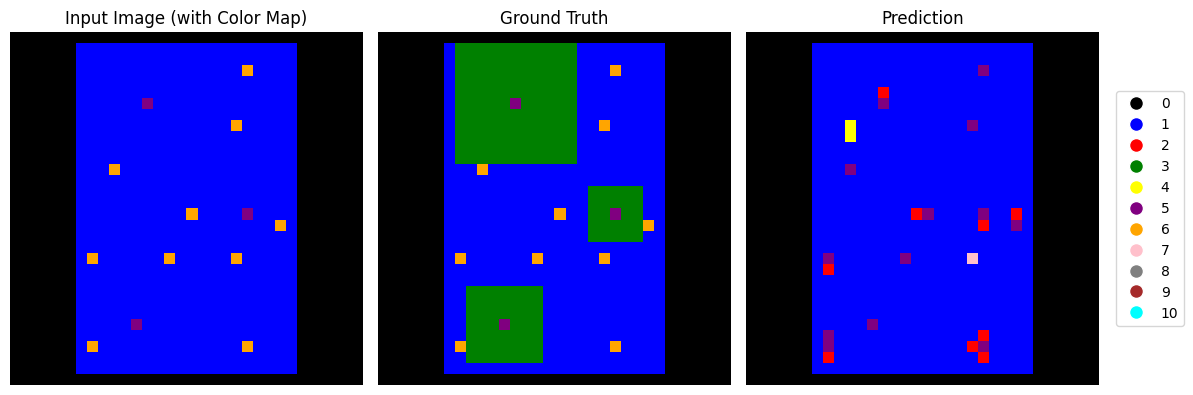


Epoch [161/1000] Complete
Average Loss: 0.008033
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



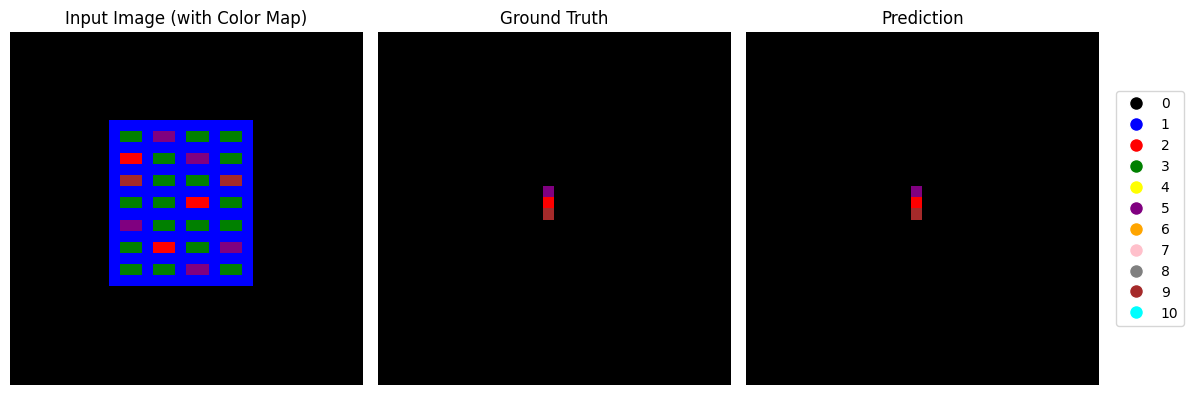

Test Average Loss: 5.781431
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.95%




Epoch [162/1000] Complete
Average Loss: 0.006483
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.78%



Test Average Loss: 5.571318
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.63%




Epoch [163/1000] Complete
Average Loss: 0.007507
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.73%



Test Average Loss: 6.161606
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.75%




Epoch [164/1000] Complete
Average Loss: 0.008828
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 5.863468
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.95%




Epoch [165/1000] Complete
Average Loss: 0.008495
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.69%



Test Average Loss: 5.395535
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.23%




Epoch [166/1000] Complete
Average Loss: 0.011093
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 6.055344
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.03%




Epoch [167/1000] Complete
Average Loss: 0.009189
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 6.253775
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.57%




Epoch [168/1000] Complete
Average Loss: 0.008383
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 5.704714
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.01%




Epoch [169/1000] Complete
Average Loss: 0.010232
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.69%



Test Average Loss: 5.641756
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.89%




Epoch [170/1000] Complete
Average Loss: 0.044232
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.07%



Test Average Loss: 5.066323
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.23%



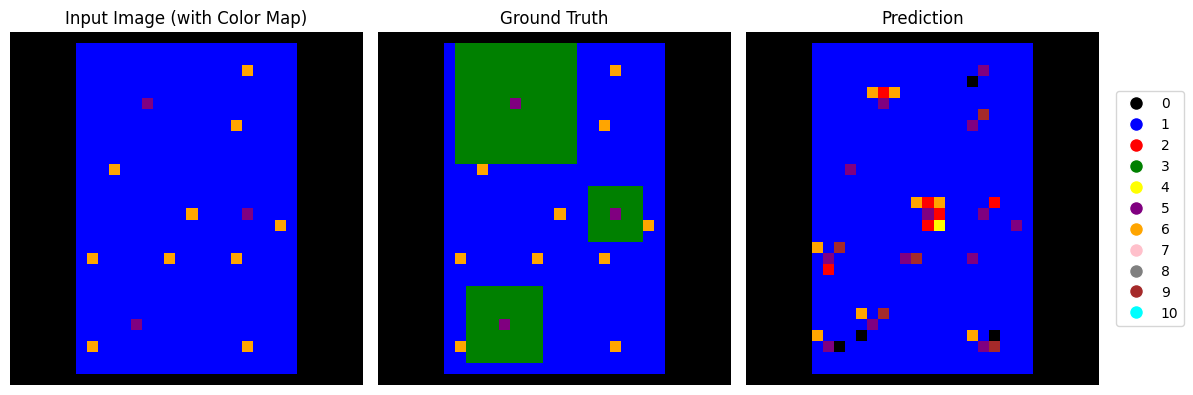


Epoch [171/1000] Complete
Average Loss: 0.214185
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.42%



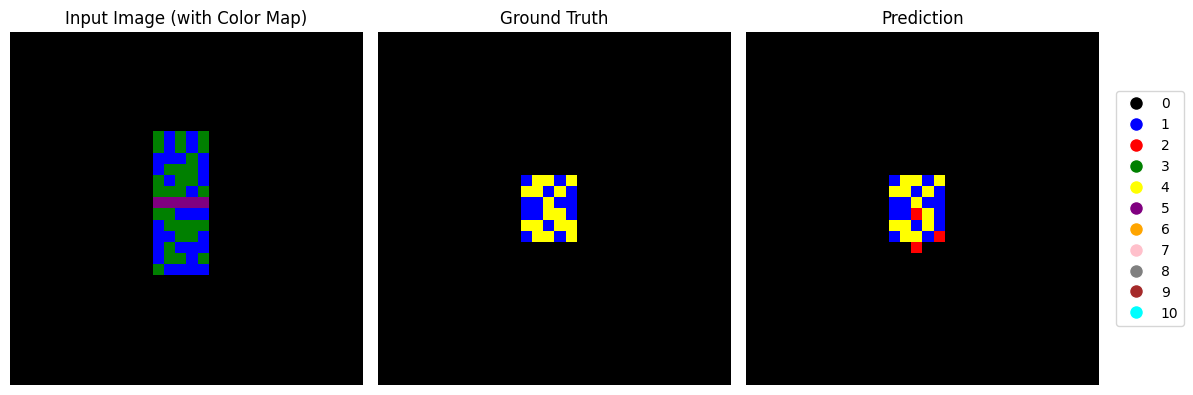

Test Average Loss: 4.154397
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.65%




Epoch [172/1000] Complete
Average Loss: 0.308864
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.48%



Test Average Loss: 4.869526
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.06%




Epoch [173/1000] Complete
Average Loss: 0.281151
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.93%



Test Average Loss: 3.715599
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.37%




Epoch [174/1000] Complete
Average Loss: 0.115725
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.17%



Test Average Loss: 4.131191
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.97%




Epoch [175/1000] Complete
Average Loss: 0.090535
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.22%



Test Average Loss: 4.454923
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.67%




Epoch [176/1000] Complete
Average Loss: 0.067606
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.26%



Test Average Loss: 4.321622
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.22%




Epoch [177/1000] Complete
Average Loss: 0.038442
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.43%



Test Average Loss: 4.851670
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.83%




Epoch [178/1000] Complete
Average Loss: 0.030467
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.61%



Test Average Loss: 4.386331
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.23%




Epoch [179/1000] Complete
Average Loss: 0.019986
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.20%



Test Average Loss: 4.528001
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.76%




Epoch [180/1000] Complete
Average Loss: 0.011505
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.55%



Test Average Loss: 4.888215
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.65%



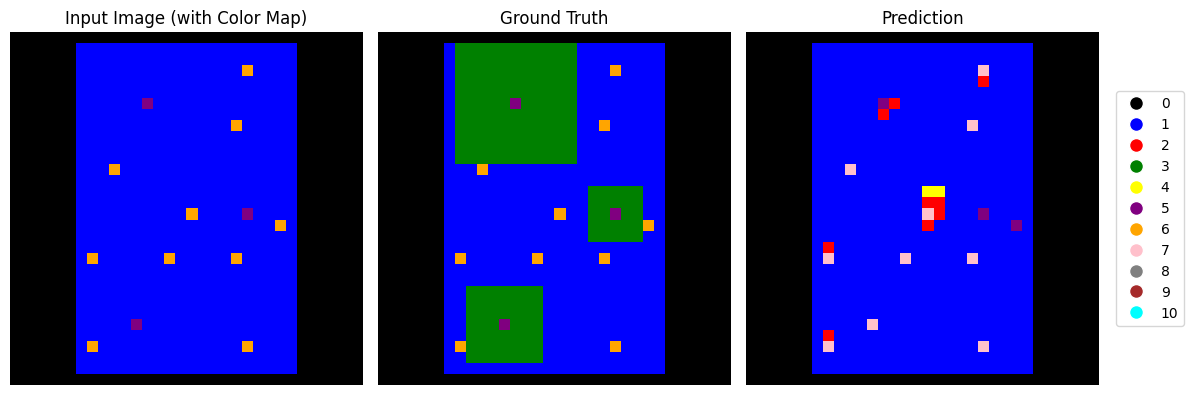


Epoch [181/1000] Complete
Average Loss: 0.007592
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.72%



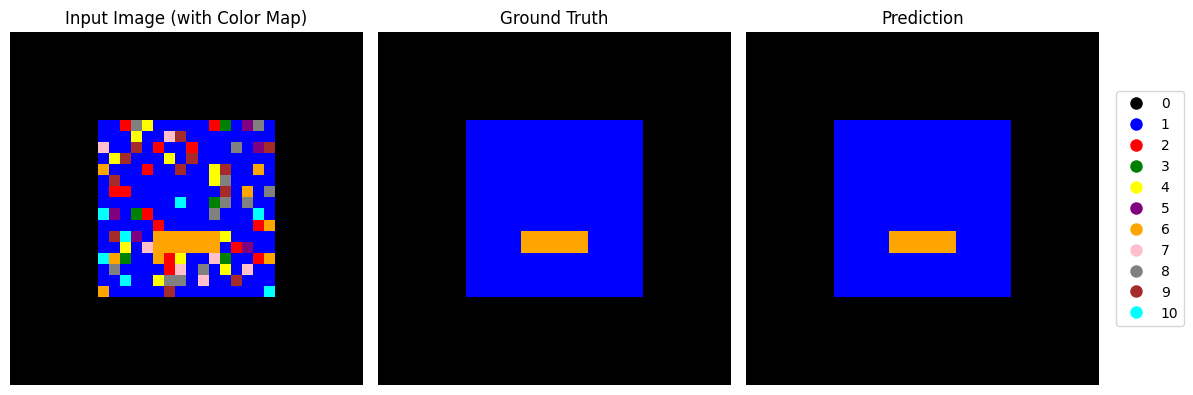

Test Average Loss: 4.817776
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.44%




Epoch [182/1000] Complete
Average Loss: 0.009125
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 6.407948
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.82%




Epoch [183/1000] Complete
Average Loss: 0.006460
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.73%



Test Average Loss: 6.078311
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.66%




Epoch [184/1000] Complete
Average Loss: 0.004667
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 5.335533
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.74%




Epoch [185/1000] Complete
Average Loss: 0.006330
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 6.049793
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 60.24%




Epoch [186/1000] Complete
Average Loss: 0.009944
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 5.608394
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.08%




Epoch [187/1000] Complete
Average Loss: 0.007077
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



Test Average Loss: 5.740574
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.60%




Epoch [188/1000] Complete
Average Loss: 0.010075
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.68%



Test Average Loss: 5.362468
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.94%




Epoch [189/1000] Complete
Average Loss: 0.015567
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.46%



Test Average Loss: 5.506049
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.71%




Epoch [190/1000] Complete
Average Loss: 0.010688
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 5.607006
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.17%



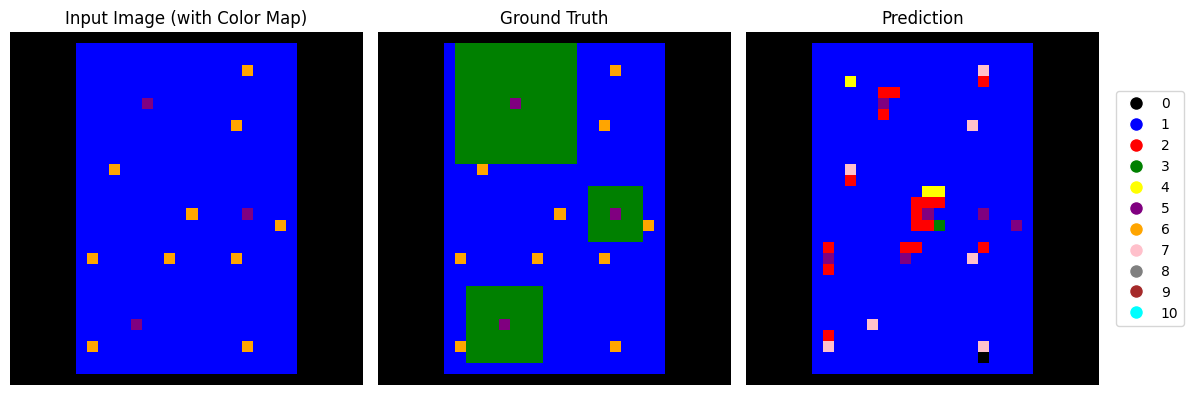


Epoch [191/1000] Complete
Average Loss: 0.007855
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.72%



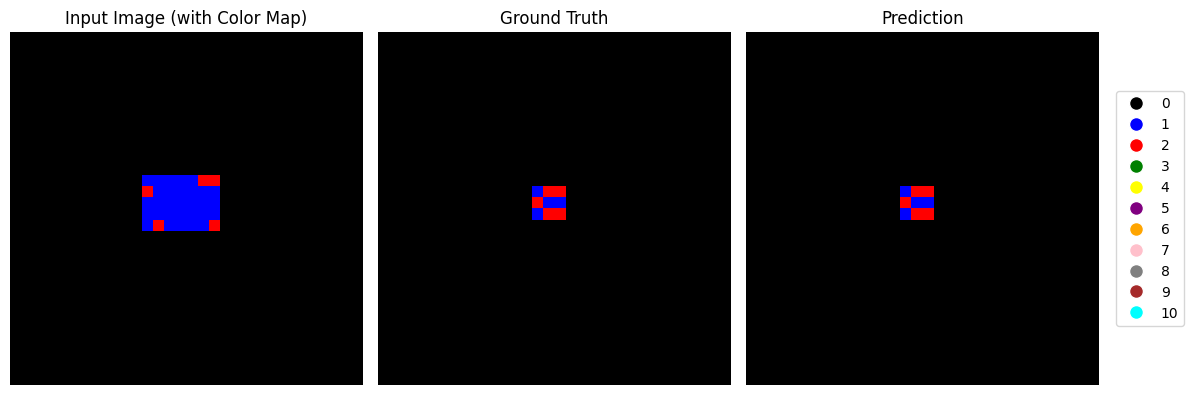

Test Average Loss: 5.360134
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.80%




Epoch [192/1000] Complete
Average Loss: 0.006513
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 5.849618
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.05%




Epoch [193/1000] Complete
Average Loss: 0.014702
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 7.372373
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.34%




Epoch [194/1000] Complete
Average Loss: 0.010747
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.56%



Test Average Loss: 5.849626
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.59%




Epoch [195/1000] Complete
Average Loss: 0.011480
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 6.710487
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.72%




Epoch [196/1000] Complete
Average Loss: 0.007985
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.71%



Test Average Loss: 6.010593
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.32%




Epoch [197/1000] Complete
Average Loss: 0.009085
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.69%



Test Average Loss: 6.595817
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.01%




Epoch [198/1000] Complete
Average Loss: 0.009729
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 6.701176
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.40%




Epoch [199/1000] Complete
Average Loss: 0.010671
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 5.707647
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.79%




Epoch [200/1000] Complete
Average Loss: 0.019739
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.21%



Test Average Loss: 5.025201
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.23%



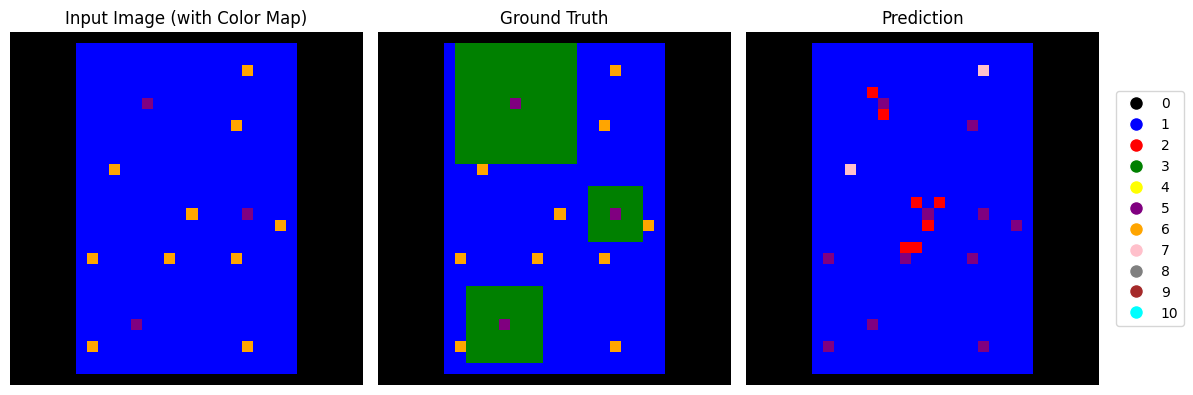


Epoch [201/1000] Complete
Average Loss: 0.024434
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.04%



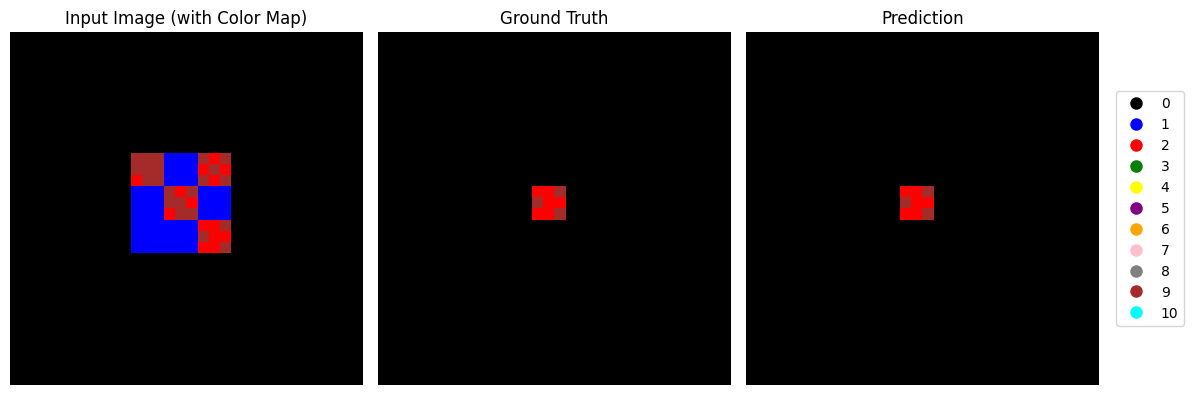

Test Average Loss: 6.235156
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.54%




Epoch [202/1000] Complete
Average Loss: 0.022925
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.05%



Test Average Loss: 5.228694
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.84%




Epoch [203/1000] Complete
Average Loss: 0.022407
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.07%



Test Average Loss: 5.480703
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.60%




Epoch [204/1000] Complete
Average Loss: 0.016518
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.31%



Test Average Loss: 4.707049
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.88%




Epoch [205/1000] Complete
Average Loss: 0.012399
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 5.962533
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.66%




Epoch [206/1000] Complete
Average Loss: 0.011850
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 5.152633
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.41%




Epoch [207/1000] Complete
Average Loss: 0.013193
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 5.947709
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.55%




Epoch [208/1000] Complete
Average Loss: 0.010870
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 5.837416
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.71%




Epoch [209/1000] Complete
Average Loss: 0.014112
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.51%



Test Average Loss: 6.814439
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.07%




Epoch [210/1000] Complete
Average Loss: 0.014318
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.50%



Test Average Loss: 6.984786
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.28%



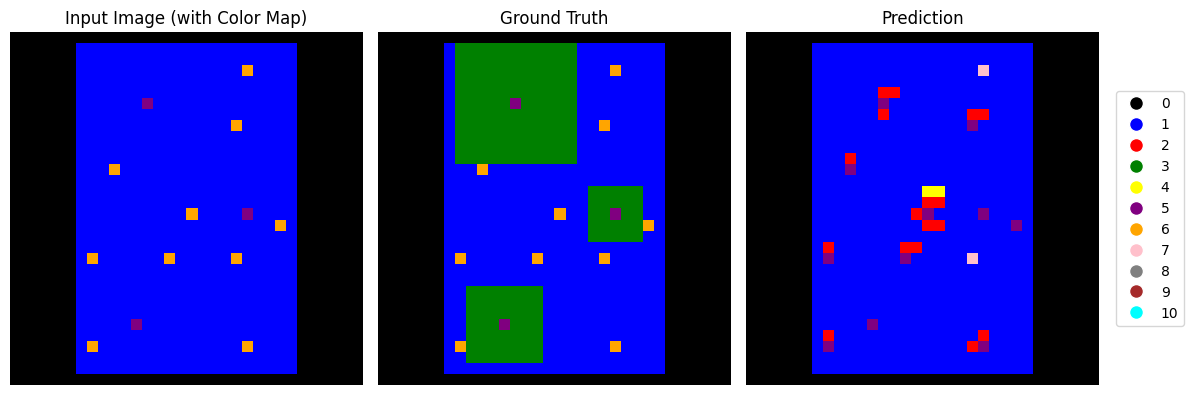


Epoch [211/1000] Complete
Average Loss: 0.012740
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.58%



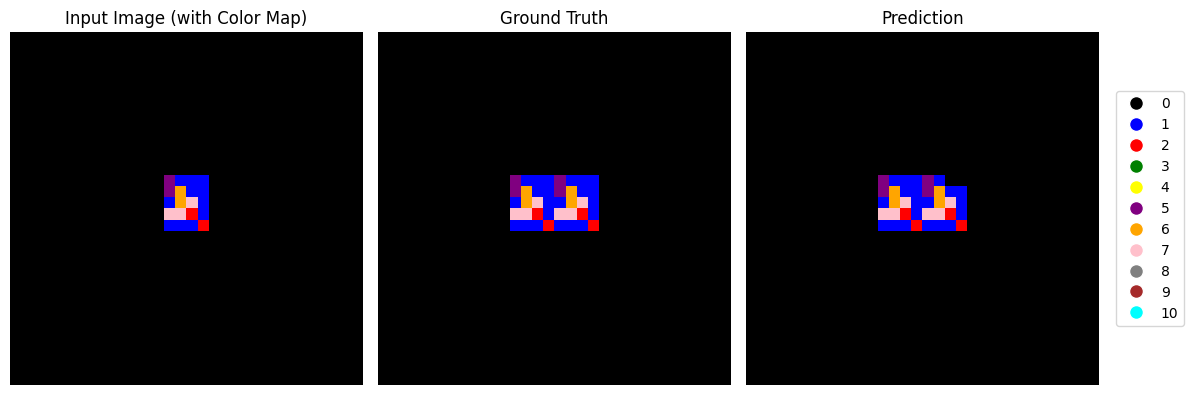

Test Average Loss: 6.160577
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.53%




Epoch [212/1000] Complete
Average Loss: 0.009669
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 6.413649
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.39%




Epoch [213/1000] Complete
Average Loss: 0.006073
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 6.028963
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.34%




Epoch [214/1000] Complete
Average Loss: 0.008128
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 6.228521
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.67%




Epoch [215/1000] Complete
Average Loss: 0.009054
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 6.497561
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.88%




Epoch [216/1000] Complete
Average Loss: 0.013185
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.55%



Test Average Loss: 6.413509
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.72%




Epoch [217/1000] Complete
Average Loss: 0.010008
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 6.860367
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.55%




Epoch [218/1000] Complete
Average Loss: 0.006423
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



Test Average Loss: 6.631998
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.05%




Epoch [219/1000] Complete
Average Loss: 0.014577
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.49%



Test Average Loss: 6.156412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.25%




Epoch [220/1000] Complete
Average Loss: 0.058830
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.84%



Test Average Loss: 4.531066
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.53%



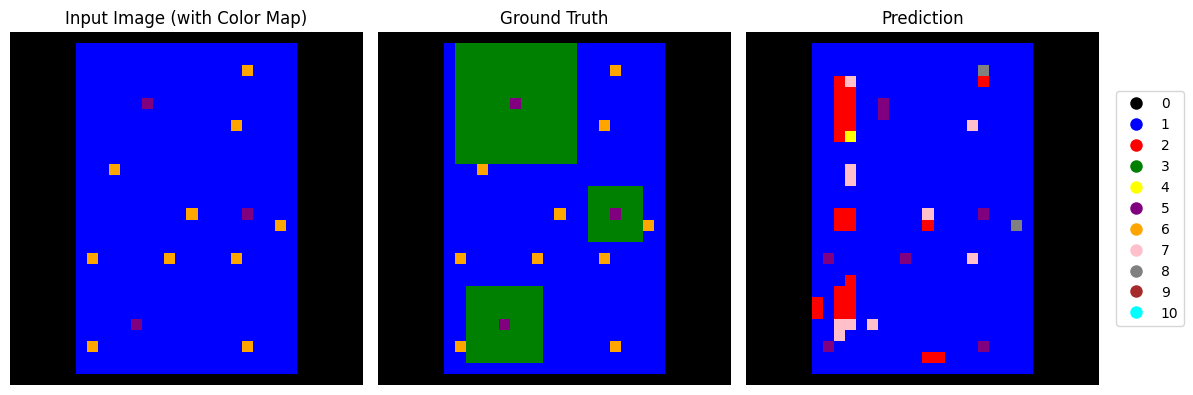


Epoch [221/1000] Complete
Average Loss: 0.150682
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.10%



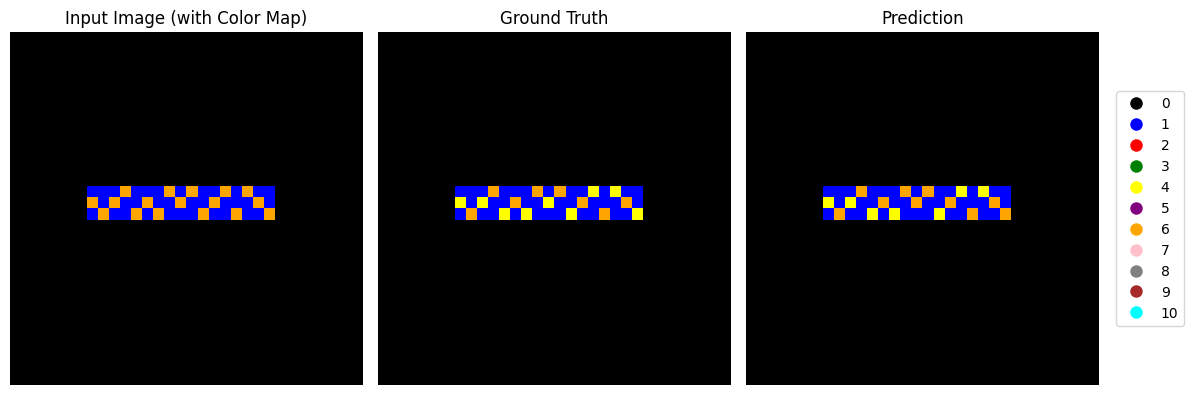

Test Average Loss: 5.482412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.09%




Epoch [222/1000] Complete
Average Loss: 0.259702
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.73%



Test Average Loss: 3.408700
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.11%




Epoch [223/1000] Complete
Average Loss: 0.239851
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.62%



Test Average Loss: 5.226949
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.89%




Epoch [224/1000] Complete
Average Loss: 0.138010
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.54%



Test Average Loss: 5.839632
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.07%




Epoch [225/1000] Complete
Average Loss: 0.069533
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.24%



Test Average Loss: 5.502022
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.29%




Epoch [226/1000] Complete
Average Loss: 0.036718
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.53%



Test Average Loss: 5.357645
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.72%




Epoch [227/1000] Complete
Average Loss: 0.024025
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.08%



Test Average Loss: 5.345699
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.24%




Epoch [228/1000] Complete
Average Loss: 0.015079
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.41%



Test Average Loss: 5.243334
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.17%




Epoch [229/1000] Complete
Average Loss: 0.009846
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.56%



Test Average Loss: 5.592087
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.14%




Epoch [230/1000] Complete
Average Loss: 0.008188
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.69%



Test Average Loss: 6.268020
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.31%



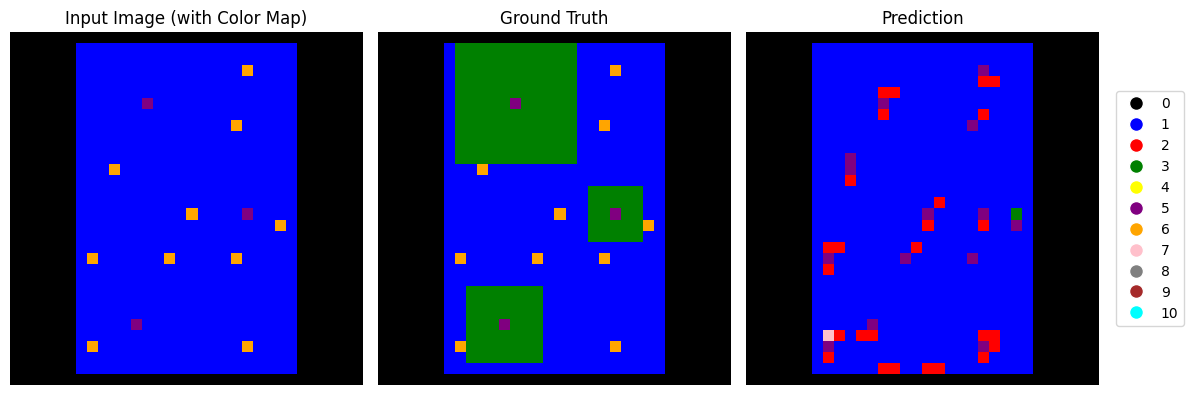


Epoch [231/1000] Complete
Average Loss: 0.005234
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



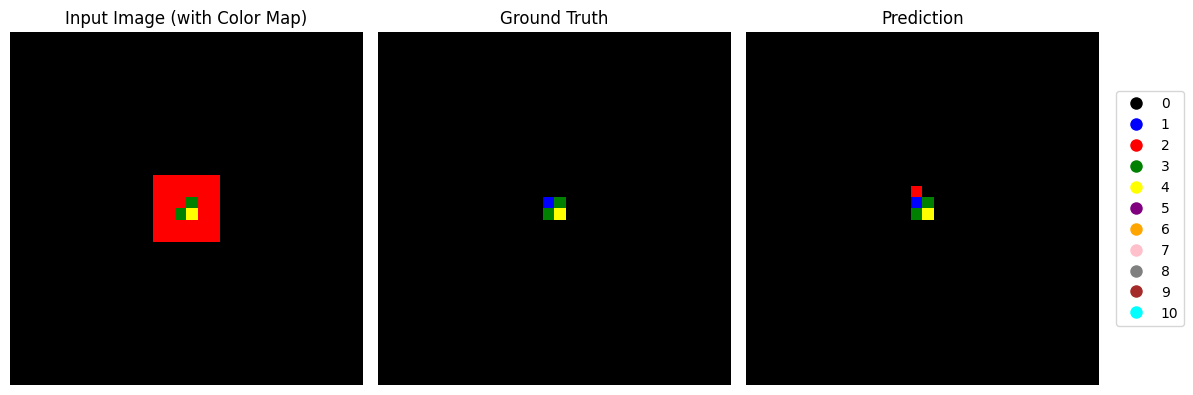

Test Average Loss: 6.414371
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.61%




Epoch [232/1000] Complete
Average Loss: 0.003650
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 6.480648
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.00%




Epoch [233/1000] Complete
Average Loss: 0.003369
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 6.122667
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.22%




Epoch [234/1000] Complete
Average Loss: 0.004410
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.84%



Test Average Loss: 7.121127
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.40%




Epoch [235/1000] Complete
Average Loss: 0.003916
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.84%



Test Average Loss: 7.019176
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.02%




Epoch [236/1000] Complete
Average Loss: 0.002905
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 7.322474
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.13%




Epoch [237/1000] Complete
Average Loss: 0.004987
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.82%



Test Average Loss: 7.574719
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.33%




Epoch [238/1000] Complete
Average Loss: 0.005939
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



Test Average Loss: 7.580504
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.77%




Epoch [239/1000] Complete
Average Loss: 0.007824
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 6.809249
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.47%




Epoch [240/1000] Complete
Average Loss: 0.006611
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



Test Average Loss: 7.524131
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.86%



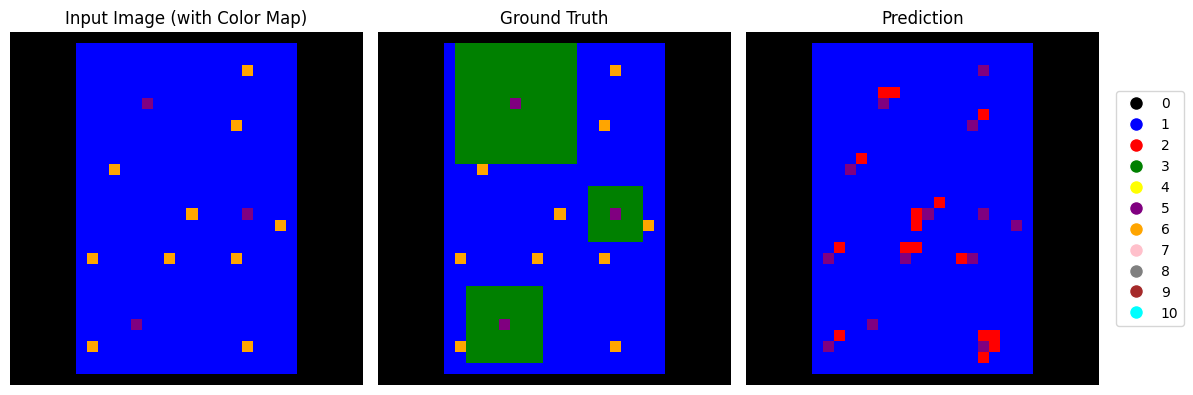


Epoch [241/1000] Complete
Average Loss: 0.011298
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.62%



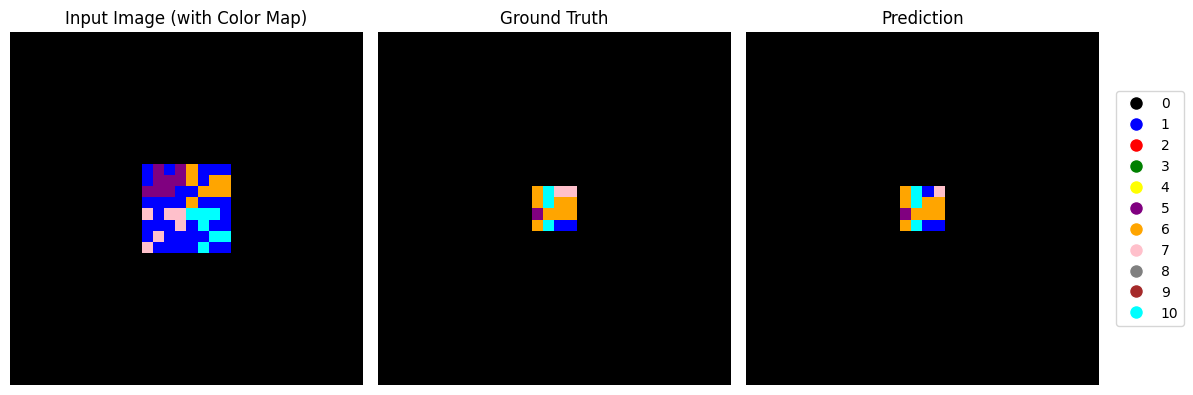

Test Average Loss: 6.329219
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.74%




Epoch [242/1000] Complete
Average Loss: 0.009599
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 6.123636
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.44%




Epoch [243/1000] Complete
Average Loss: 0.007466
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.77%



Test Average Loss: 6.677277
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.73%




Epoch [244/1000] Complete
Average Loss: 0.005481
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 6.202046
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.05%




Epoch [245/1000] Complete
Average Loss: 0.003464
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 6.773651
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.58%




Epoch [246/1000] Complete
Average Loss: 0.001595
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 6.606847
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.94%




Epoch [247/1000] Complete
Average Loss: 0.001167
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 6.595341
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.78%




Epoch [248/1000] Complete
Average Loss: 0.001678
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 6.351892
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.16%




Epoch [249/1000] Complete
Average Loss: 0.001688
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 6.714398
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.73%




Epoch [250/1000] Complete
Average Loss: 0.001840
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 7.316130
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.07%



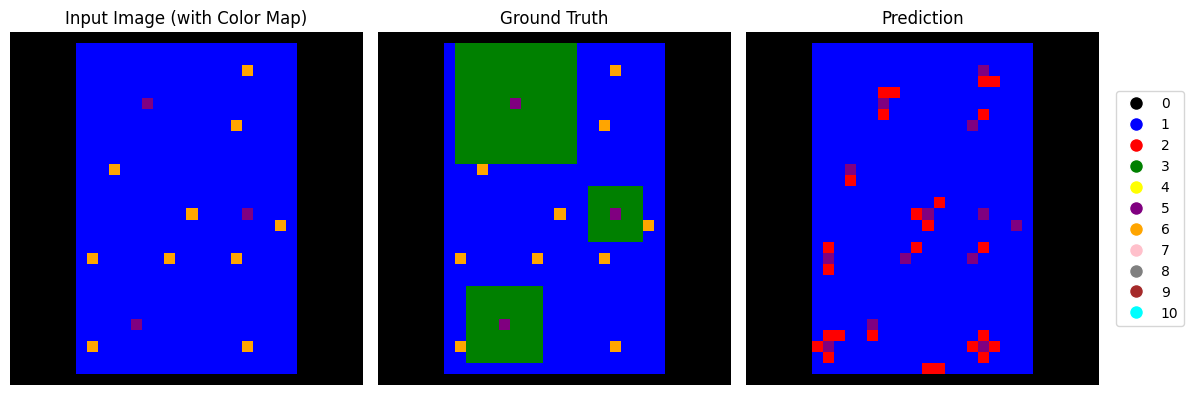


Epoch [251/1000] Complete
Average Loss: 0.002291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



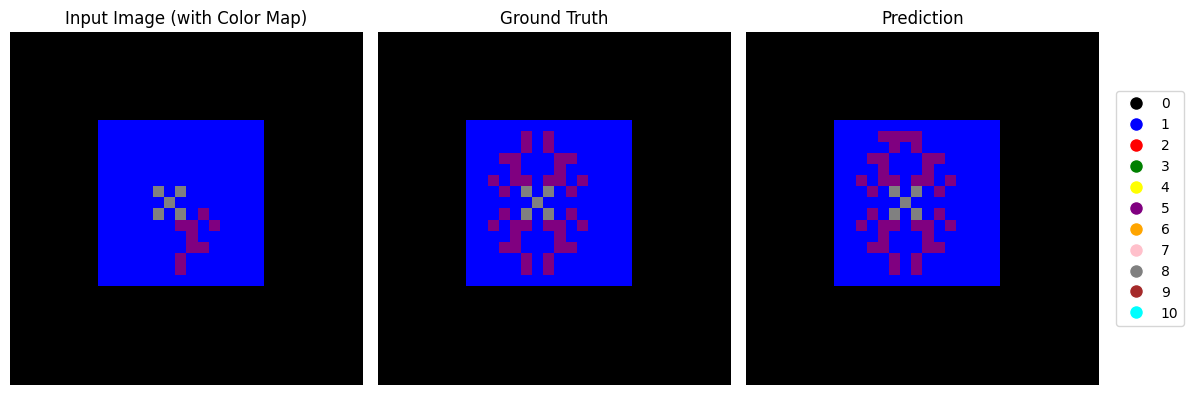

Test Average Loss: 7.219982
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.93%




Epoch [252/1000] Complete
Average Loss: 0.002661
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 7.187347
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.41%




Epoch [253/1000] Complete
Average Loss: 0.006891
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 5.758485
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.49%




Epoch [254/1000] Complete
Average Loss: 0.006075
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



Test Average Loss: 6.019035
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.73%




Epoch [255/1000] Complete
Average Loss: 0.010016
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.59%



Test Average Loss: 7.281497
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.04%




Epoch [256/1000] Complete
Average Loss: 0.011485
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.58%



Test Average Loss: 6.504696
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.19%




Epoch [257/1000] Complete
Average Loss: 0.037235
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.52%



Test Average Loss: 5.519808
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.05%




Epoch [258/1000] Complete
Average Loss: 0.043546
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.22%



Test Average Loss: 6.136081
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.25%




Epoch [259/1000] Complete
Average Loss: 0.038868
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.43%



Test Average Loss: 6.204476
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.05%




Epoch [260/1000] Complete
Average Loss: 0.042304
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.38%



Test Average Loss: 5.673814
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.96%



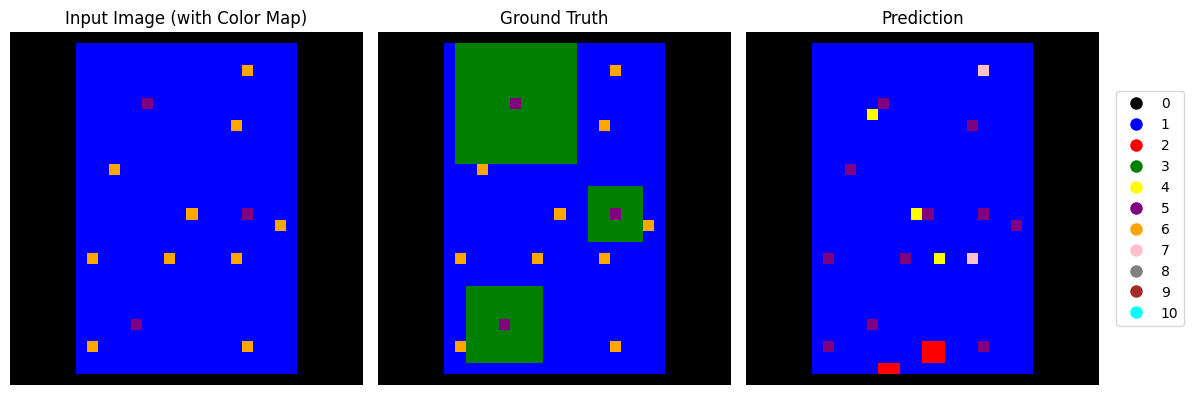


Epoch [261/1000] Complete
Average Loss: 0.037861
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.62%



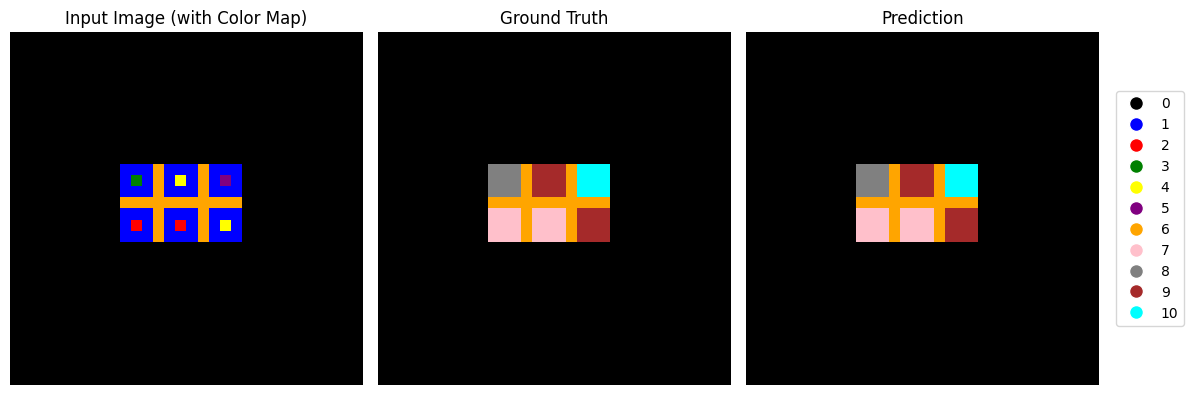

Test Average Loss: 5.739585
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.03%




Epoch [262/1000] Complete
Average Loss: 0.035361
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.63%



Test Average Loss: 5.939701
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.95%




Epoch [263/1000] Complete
Average Loss: 0.020888
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.15%



Test Average Loss: 6.260801
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.33%




Epoch [264/1000] Complete
Average Loss: 0.026860
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.11%



Test Average Loss: 5.527004
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.89%




Epoch [265/1000] Complete
Average Loss: 0.018750
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.33%



Test Average Loss: 6.442681
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.21%




Epoch [266/1000] Complete
Average Loss: 0.012758
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.52%



Test Average Loss: 6.060940
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.39%




Epoch [267/1000] Complete
Average Loss: 0.009562
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.62%



Test Average Loss: 6.659413
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.98%




Epoch [268/1000] Complete
Average Loss: 0.011480
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.61%



Test Average Loss: 6.332879
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.04%




Epoch [269/1000] Complete
Average Loss: 0.013350
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.47%



Test Average Loss: 6.802132
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.26%




Epoch [270/1000] Complete
Average Loss: 0.022088
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.15%



Test Average Loss: 6.795154
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.05%



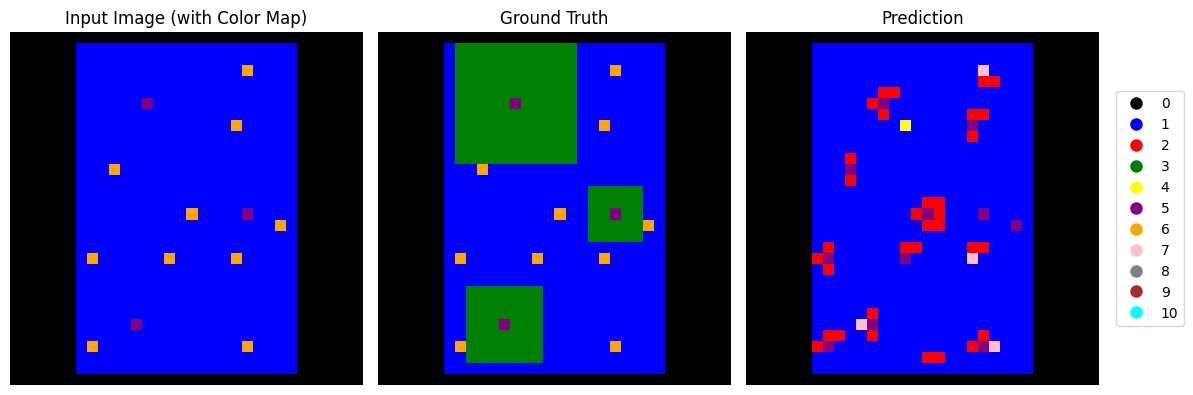


Epoch [271/1000] Complete
Average Loss: 0.061906
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.74%



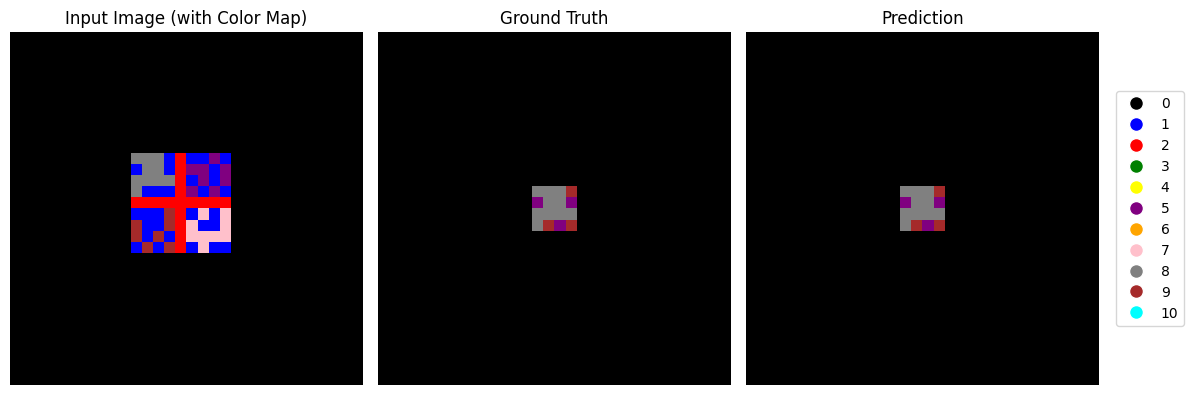

Test Average Loss: 3.896252
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.59%




Epoch [272/1000] Complete
Average Loss: 0.050696
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.05%



Test Average Loss: 6.625930
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.86%




Epoch [273/1000] Complete
Average Loss: 0.097561
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.56%



Test Average Loss: 7.016935
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.29%




Epoch [274/1000] Complete
Average Loss: 0.062047
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.56%



Test Average Loss: 6.778509
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.55%




Epoch [275/1000] Complete
Average Loss: 0.034640
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.77%



Test Average Loss: 6.631238
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.29%




Epoch [276/1000] Complete
Average Loss: 0.026348
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.19%



Test Average Loss: 6.992876
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.33%




Epoch [277/1000] Complete
Average Loss: 0.036464
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.60%



Test Average Loss: 6.363654
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.93%




Epoch [278/1000] Complete
Average Loss: 0.030330
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.88%



Test Average Loss: 8.754717
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.23%




Epoch [279/1000] Complete
Average Loss: 0.015275
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.44%



Test Average Loss: 7.169309
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.77%




Epoch [280/1000] Complete
Average Loss: 0.008220
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 7.889592
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.63%



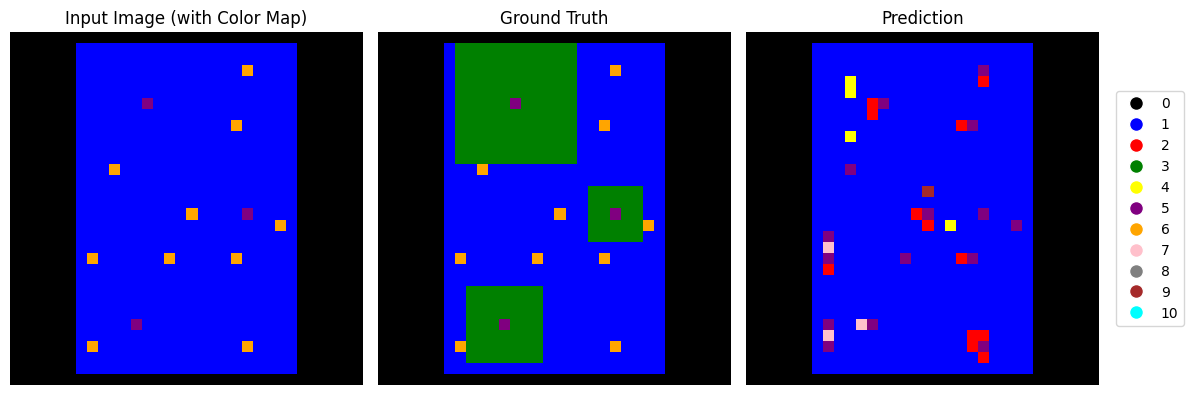


Epoch [281/1000] Complete
Average Loss: 0.004815
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



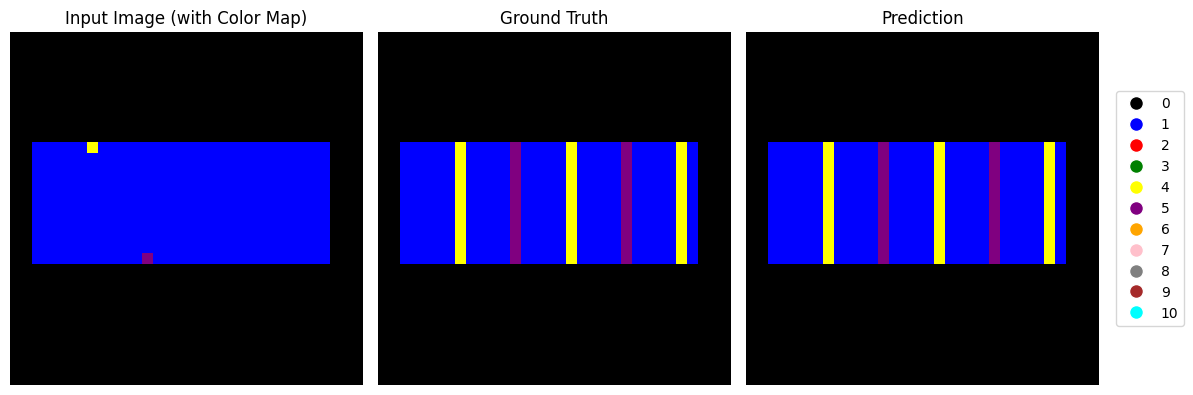

Test Average Loss: 7.214235
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.54%




Epoch [282/1000] Complete
Average Loss: 0.003725
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 7.627331
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.54%




Epoch [283/1000] Complete
Average Loss: 0.002385
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.90%



Test Average Loss: 8.009130
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.26%




Epoch [284/1000] Complete
Average Loss: 0.002291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 7.552793
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.37%




Epoch [285/1000] Complete
Average Loss: 0.001986
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 7.292218
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.19%




Epoch [286/1000] Complete
Average Loss: 0.002618
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 7.116931
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.86%




Epoch [287/1000] Complete
Average Loss: 0.021549
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.36%



Test Average Loss: 7.406885
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.27%




Epoch [288/1000] Complete
Average Loss: 0.009398
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 8.178016
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.39%




Epoch [289/1000] Complete
Average Loss: 0.006005
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 6.653672
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.55%




Epoch [290/1000] Complete
Average Loss: 0.006159
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.78%



Test Average Loss: 6.636109
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.40%



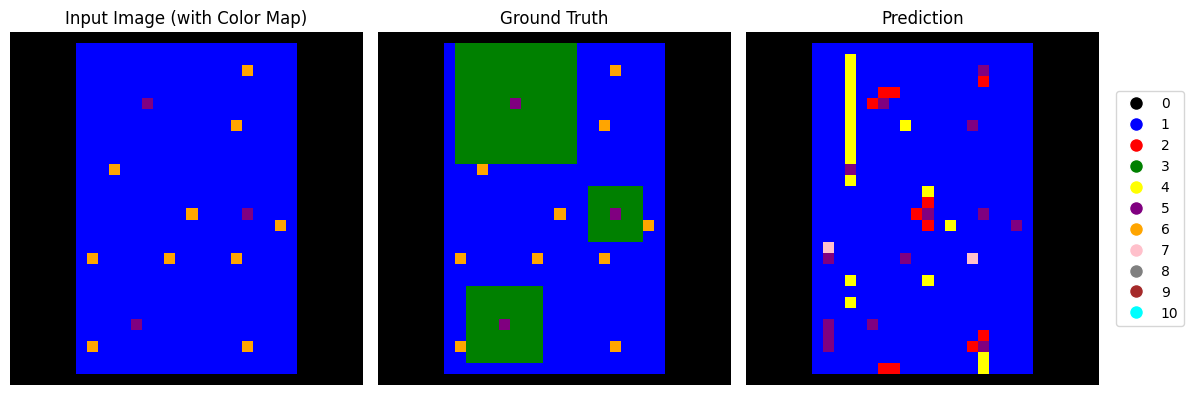


Epoch [291/1000] Complete
Average Loss: 0.010722
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.61%



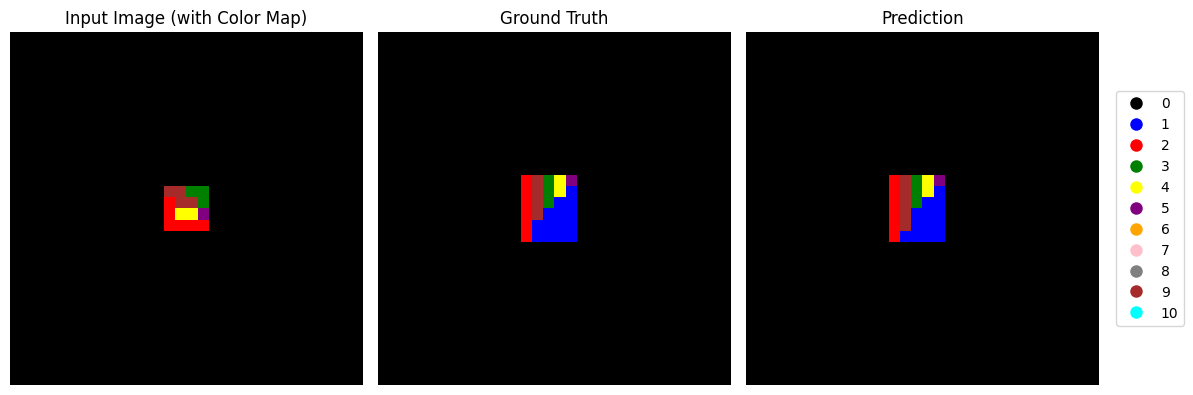

Test Average Loss: 7.396290
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.26%




Epoch [292/1000] Complete
Average Loss: 0.006149
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.77%



Test Average Loss: 7.580853
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.89%




Epoch [293/1000] Complete
Average Loss: 0.004381
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 6.705316
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.57%




Epoch [294/1000] Complete
Average Loss: 0.001820
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 7.633174
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.32%




Epoch [295/1000] Complete
Average Loss: 0.001647
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 7.214387
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.99%




Epoch [296/1000] Complete
Average Loss: 0.002535
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 7.556175
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.01%




Epoch [297/1000] Complete
Average Loss: 0.002046
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 8.468018
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.12%




Epoch [298/1000] Complete
Average Loss: 0.000867
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 7.690452
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.13%




Epoch [299/1000] Complete
Average Loss: 0.000742
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 7.461058
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.46%




Epoch [300/1000] Complete
Average Loss: 0.001588
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 7.785102
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.99%



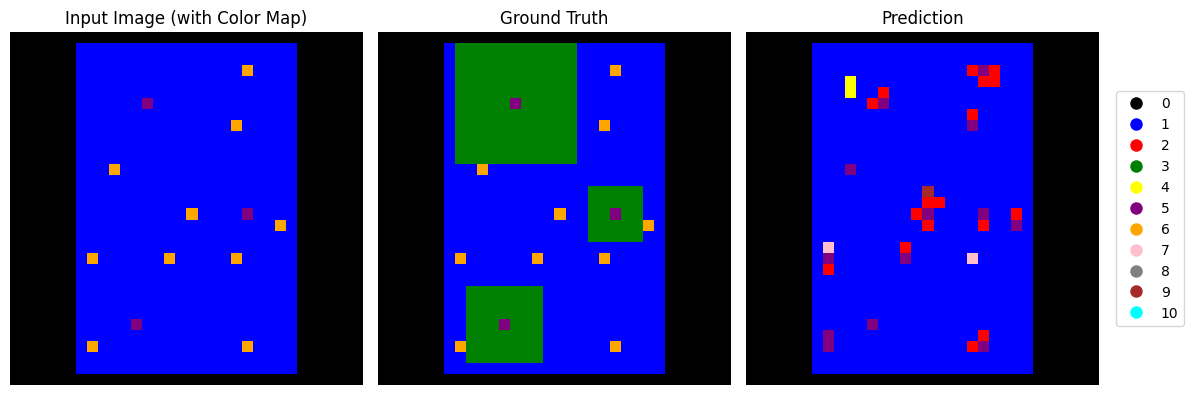


Epoch [301/1000] Complete
Average Loss: 0.001930
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



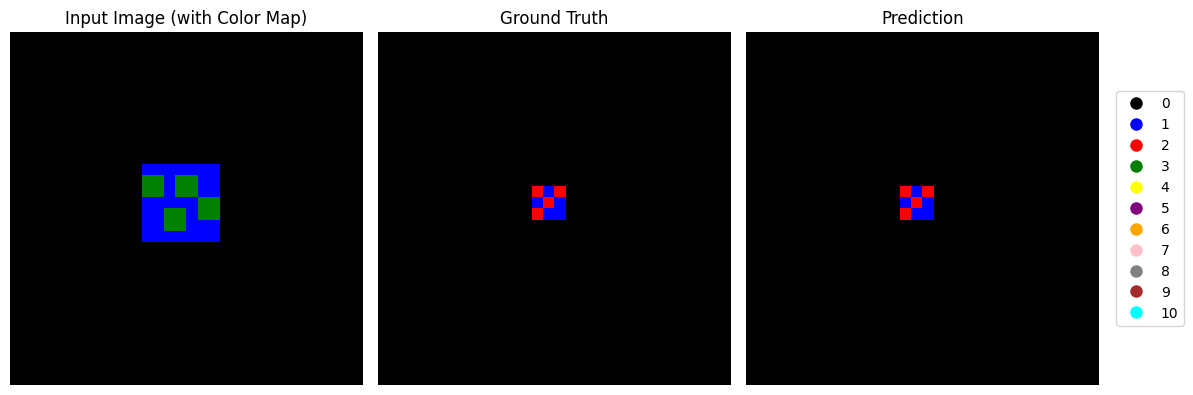

Test Average Loss: 6.972568
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.37%




Epoch [302/1000] Complete
Average Loss: 0.001888
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 8.561897
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.05%




Epoch [303/1000] Complete
Average Loss: 0.000670
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 8.251641
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.08%




Epoch [304/1000] Complete
Average Loss: 0.000731
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 8.195368
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.34%




Epoch [305/1000] Complete
Average Loss: 0.003151
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 7.506219
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.52%




Epoch [306/1000] Complete
Average Loss: 0.086342
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.95%



Test Average Loss: 7.297302
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.09%




Epoch [307/1000] Complete
Average Loss: 1.033097
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 75.11%



Test Average Loss: 2.818230
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.54%




Epoch [308/1000] Complete
Average Loss: 10.132894
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 33.46%



Test Average Loss: 11.454079
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.46%




Epoch [309/1000] Complete
Average Loss: 2.767616
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 47.50%



Test Average Loss: 3.293733
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.67%




Epoch [310/1000] Complete
Average Loss: 1.335650
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 55.12%



Test Average Loss: 2.658833
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.52%



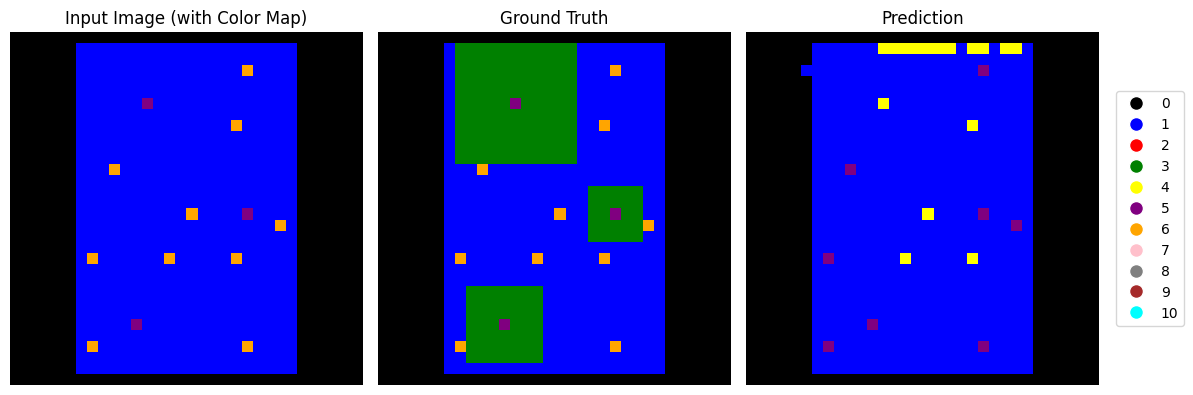


Epoch [311/1000] Complete
Average Loss: 1.116446
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 57.60%



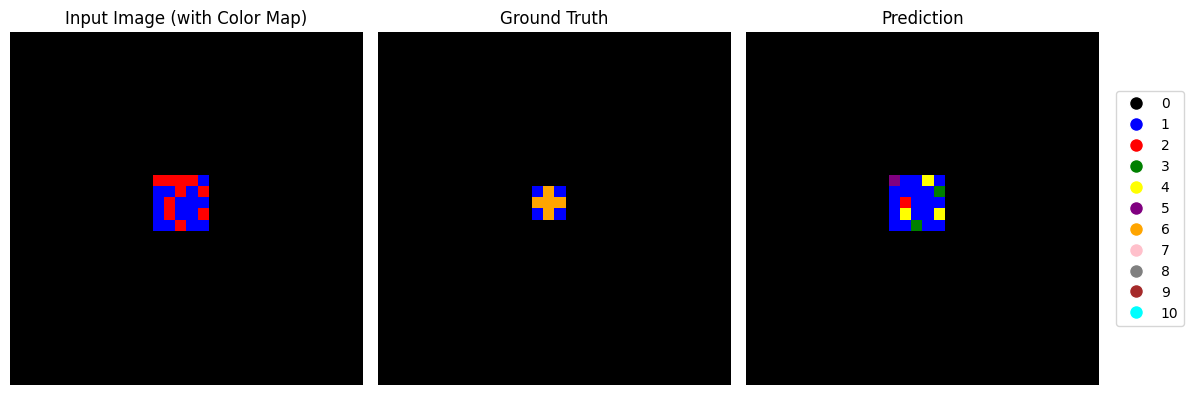

Test Average Loss: 2.922048
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.85%




Epoch [312/1000] Complete
Average Loss: 1.075609
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 59.94%



Test Average Loss: 2.816825
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.06%




Epoch [313/1000] Complete
Average Loss: 1.031361
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 61.14%



Test Average Loss: 2.829645
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.92%




Epoch [314/1000] Complete
Average Loss: 0.995834
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 62.34%



Test Average Loss: 2.753438
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.11%




Epoch [315/1000] Complete
Average Loss: 0.969412
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 63.34%



Test Average Loss: 3.072820
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 44.29%




Epoch [316/1000] Complete
Average Loss: 0.947552
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 64.58%



Test Average Loss: 3.077065
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.72%




Epoch [317/1000] Complete
Average Loss: 0.934914
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 65.43%



Test Average Loss: 3.177178
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 58.17%




Epoch [318/1000] Complete
Average Loss: 0.926290
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 64.77%



Test Average Loss: 3.140640
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 45.42%




Epoch [319/1000] Complete
Average Loss: 0.903469
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 66.68%



Test Average Loss: 3.030542
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.59%




Epoch [320/1000] Complete
Average Loss: 0.887720
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 66.26%



Test Average Loss: 3.267198
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.27%



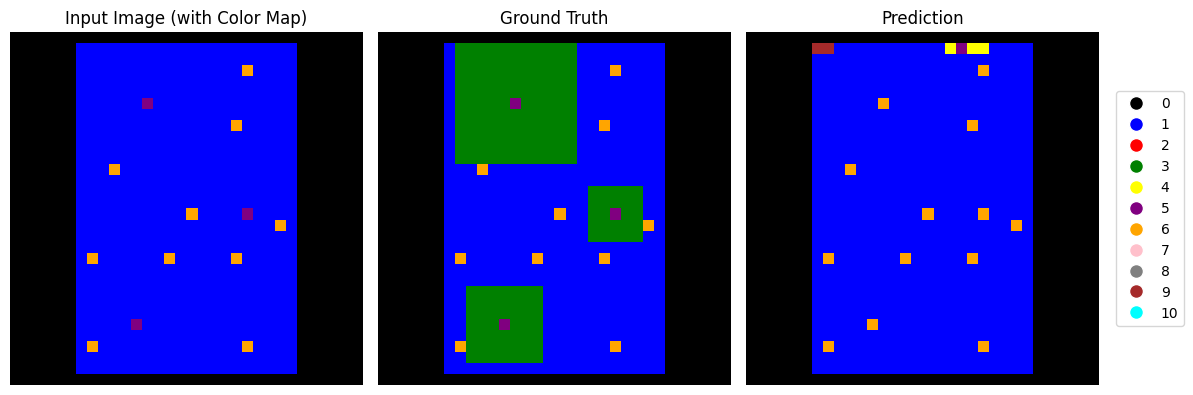


Epoch [321/1000] Complete
Average Loss: 0.866535
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 67.61%



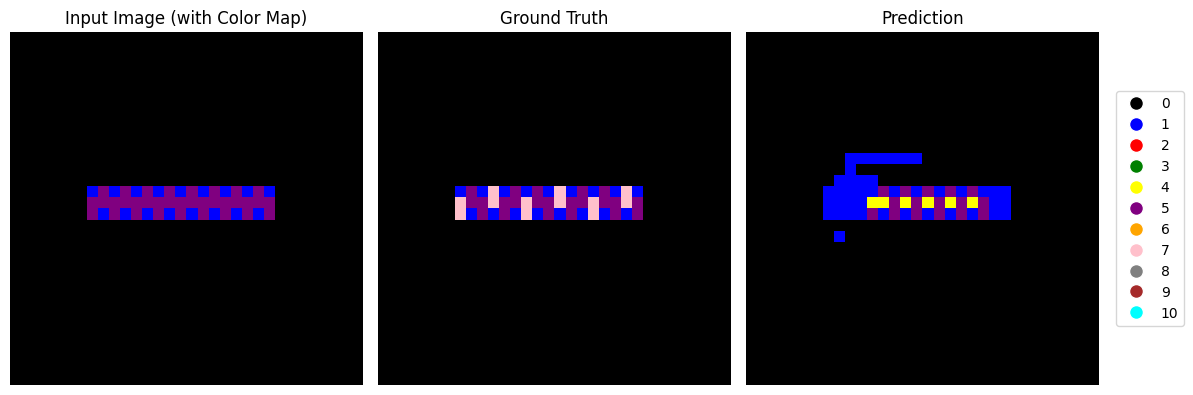

Test Average Loss: 3.260112
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.48%




Epoch [322/1000] Complete
Average Loss: 0.851095
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 68.16%



Test Average Loss: 3.464509
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.88%




Epoch [323/1000] Complete
Average Loss: 0.843536
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 68.52%



Test Average Loss: 3.611554
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.79%




Epoch [324/1000] Complete
Average Loss: 0.813171
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 69.50%



Test Average Loss: 3.811081
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.51%




Epoch [325/1000] Complete
Average Loss: 0.804559
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 69.80%



Test Average Loss: 3.572331
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.94%




Epoch [326/1000] Complete
Average Loss: 0.783165
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 70.40%



Test Average Loss: 4.143798
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.58%




Epoch [327/1000] Complete
Average Loss: 0.765884
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 71.02%



Test Average Loss: 3.323753
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.69%




Epoch [328/1000] Complete
Average Loss: 0.757766
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 71.85%



Test Average Loss: 3.760747
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 59.96%




Epoch [329/1000] Complete
Average Loss: 0.748428
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 71.86%



Test Average Loss: 3.989067
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.02%




Epoch [330/1000] Complete
Average Loss: 0.703972
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 73.94%



Test Average Loss: 3.702508
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.86%



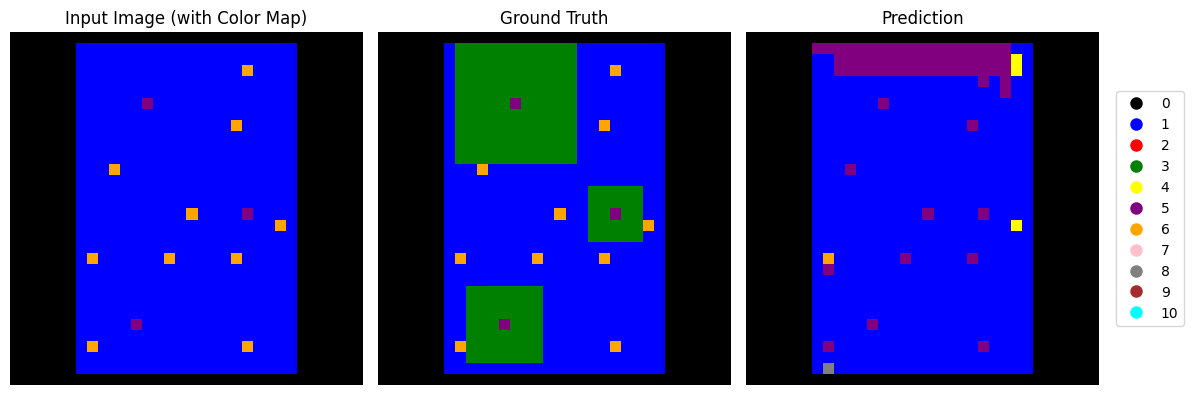


Epoch [331/1000] Complete
Average Loss: 0.699162
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 73.79%



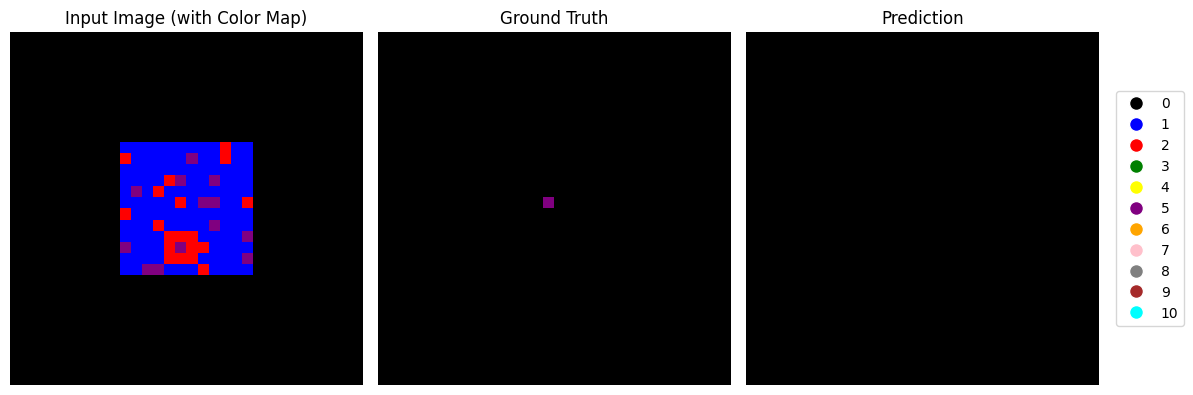

Test Average Loss: 4.052765
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.06%




Epoch [332/1000] Complete
Average Loss: 0.685188
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 74.96%



Test Average Loss: 4.519300
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.62%




Epoch [333/1000] Complete
Average Loss: 0.678061
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 74.67%



Test Average Loss: 4.396411
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 42.85%




Epoch [334/1000] Complete
Average Loss: 0.649980
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 76.30%



Test Average Loss: 4.239659
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.06%




Epoch [335/1000] Complete
Average Loss: 0.619099
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.08%



Test Average Loss: 4.274600
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 47.05%




Epoch [336/1000] Complete
Average Loss: 0.601518
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.94%



Test Average Loss: 4.338611
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.05%




Epoch [337/1000] Complete
Average Loss: 0.603679
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.23%



Test Average Loss: 4.322043
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.93%




Epoch [338/1000] Complete
Average Loss: 0.648751
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 76.07%



Test Average Loss: 4.289796
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.24%




Epoch [339/1000] Complete
Average Loss: 0.596725
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 77.87%



Test Average Loss: 4.026159
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.73%




Epoch [340/1000] Complete
Average Loss: 0.560799
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 78.72%



Test Average Loss: 4.121307
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.42%



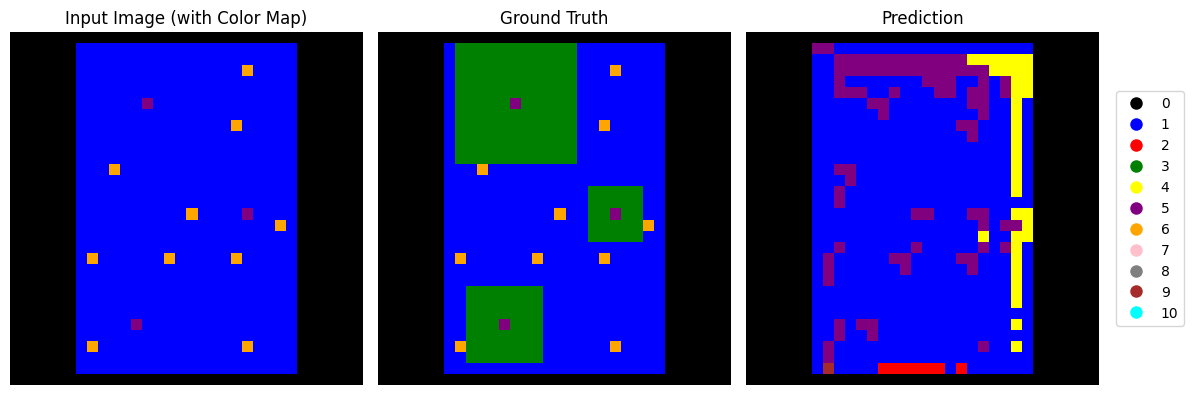


Epoch [341/1000] Complete
Average Loss: 0.542583
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 79.44%



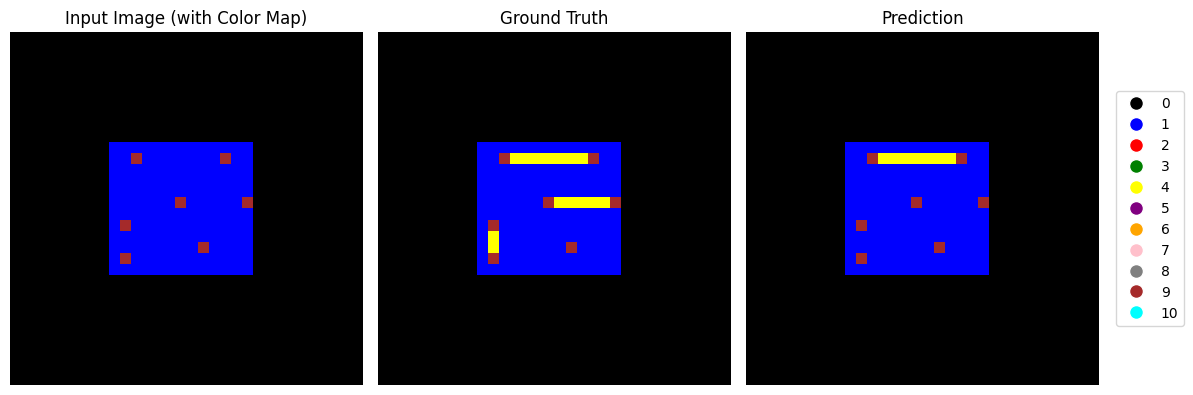

Test Average Loss: 4.319355
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.23%




Epoch [342/1000] Complete
Average Loss: 0.520156
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 80.36%



Test Average Loss: 4.435348
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.16%




Epoch [343/1000] Complete
Average Loss: 0.516310
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 80.36%



Test Average Loss: 4.582937
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.08%




Epoch [344/1000] Complete
Average Loss: 0.507119
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 80.73%



Test Average Loss: 4.328033
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.63%




Epoch [345/1000] Complete
Average Loss: 0.483837
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 81.61%



Test Average Loss: 4.662523
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 47.22%




Epoch [346/1000] Complete
Average Loss: 0.457812
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.33%



Test Average Loss: 4.756877
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.75%




Epoch [347/1000] Complete
Average Loss: 0.448264
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.89%



Test Average Loss: 5.054815
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 43.07%




Epoch [348/1000] Complete
Average Loss: 0.426030
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 83.46%



Test Average Loss: 4.712174
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.33%




Epoch [349/1000] Complete
Average Loss: 0.441956
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 82.85%



Test Average Loss: 4.698980
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.90%




Epoch [350/1000] Complete
Average Loss: 0.407288
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 84.36%



Test Average Loss: 4.922138
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.80%



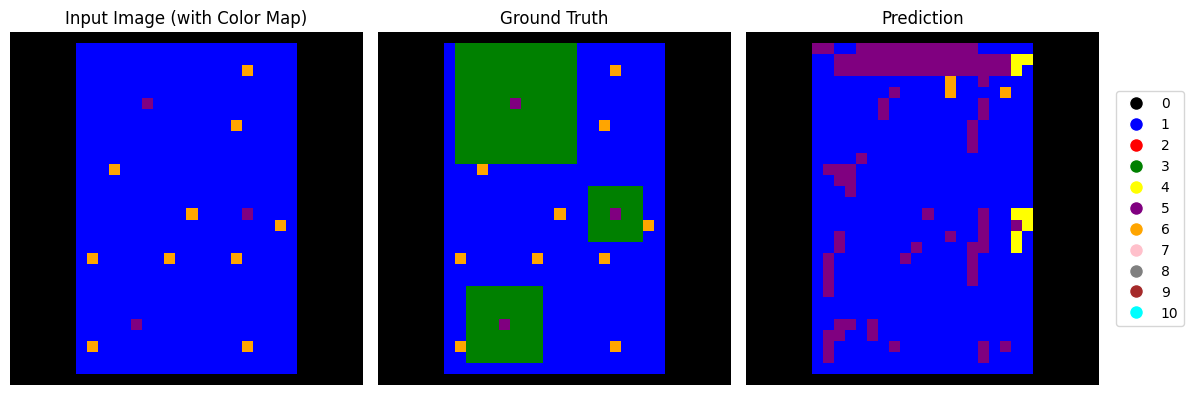


Epoch [351/1000] Complete
Average Loss: 0.371291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 85.27%



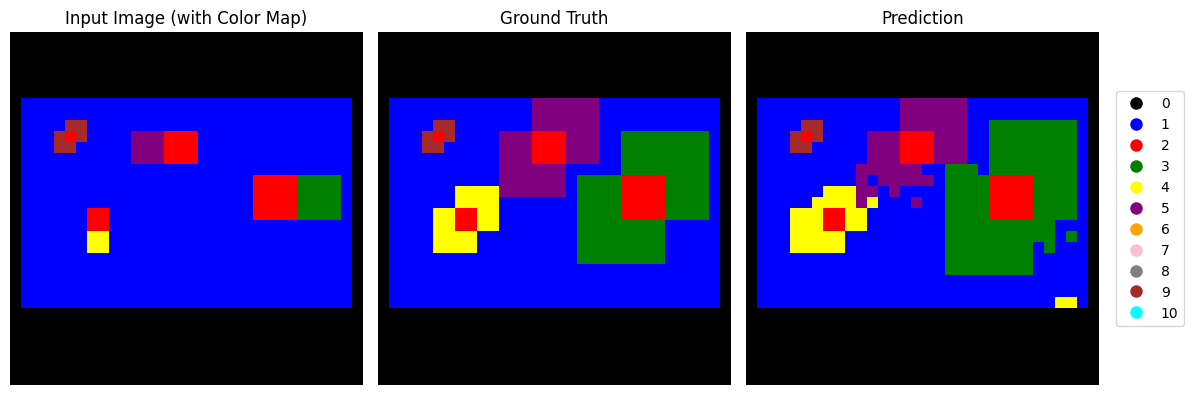

Test Average Loss: 5.495735
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.11%




Epoch [352/1000] Complete
Average Loss: 0.352270
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 85.86%



Test Average Loss: 5.372053
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 42.99%




Epoch [353/1000] Complete
Average Loss: 0.356450
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 85.56%



Test Average Loss: 5.611740
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.72%




Epoch [354/1000] Complete
Average Loss: 0.339280
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 86.16%



Test Average Loss: 5.405051
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 47.16%




Epoch [355/1000] Complete
Average Loss: 0.302420
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 87.33%



Test Average Loss: 5.391870
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.95%




Epoch [356/1000] Complete
Average Loss: 0.308164
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 86.94%



Test Average Loss: 5.779558
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.27%




Epoch [357/1000] Complete
Average Loss: 0.292673
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.05%



Test Average Loss: 5.766516
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.34%




Epoch [358/1000] Complete
Average Loss: 0.288617
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 87.99%



Test Average Loss: 6.173723
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 45.60%




Epoch [359/1000] Complete
Average Loss: 0.288245
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.01%



Test Average Loss: 6.302078
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 47.88%




Epoch [360/1000] Complete
Average Loss: 0.310784
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 86.95%



Test Average Loss: 5.881973
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.89%



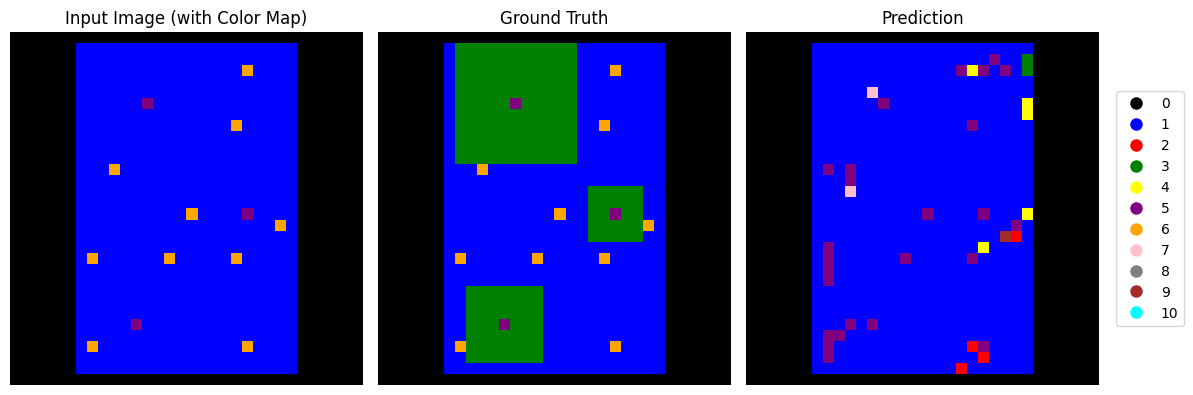


Epoch [361/1000] Complete
Average Loss: 0.281128
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 88.48%



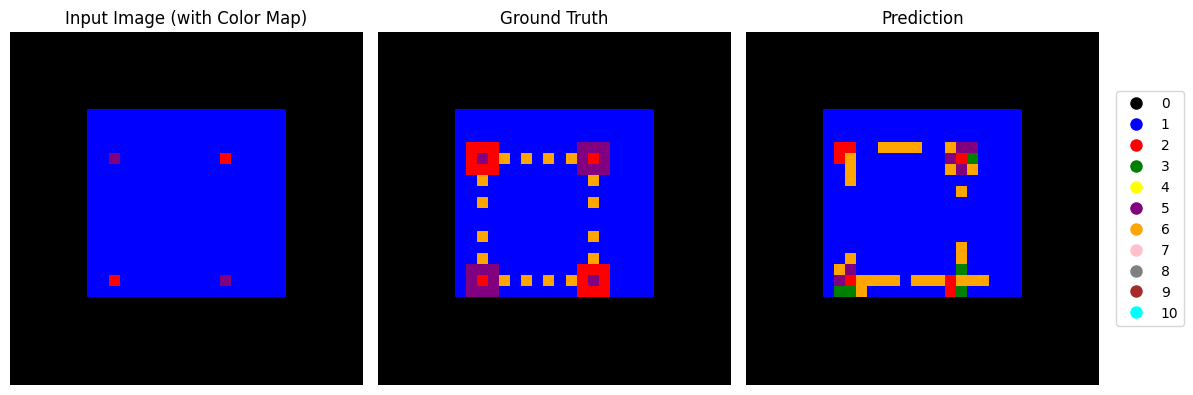

Test Average Loss: 6.555241
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.08%




Epoch [362/1000] Complete
Average Loss: 0.258669
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.22%



Test Average Loss: 6.230240
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.41%




Epoch [363/1000] Complete
Average Loss: 0.225960
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.24%



Test Average Loss: 6.776851
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.76%




Epoch [364/1000] Complete
Average Loss: 0.232212
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.89%



Test Average Loss: 6.262899
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.08%




Epoch [365/1000] Complete
Average Loss: 0.232297
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.75%



Test Average Loss: 6.933756
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.01%




Epoch [366/1000] Complete
Average Loss: 0.224512
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.40%



Test Average Loss: 6.566892
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.91%




Epoch [367/1000] Complete
Average Loss: 0.212389
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 90.85%



Test Average Loss: 6.915324
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.73%




Epoch [368/1000] Complete
Average Loss: 0.194879
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.29%



Test Average Loss: 7.025735
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.86%




Epoch [369/1000] Complete
Average Loss: 0.203543
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.32%



Test Average Loss: 7.036502
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.62%




Epoch [370/1000] Complete
Average Loss: 0.189120
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.83%



Test Average Loss: 7.090289
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.96%



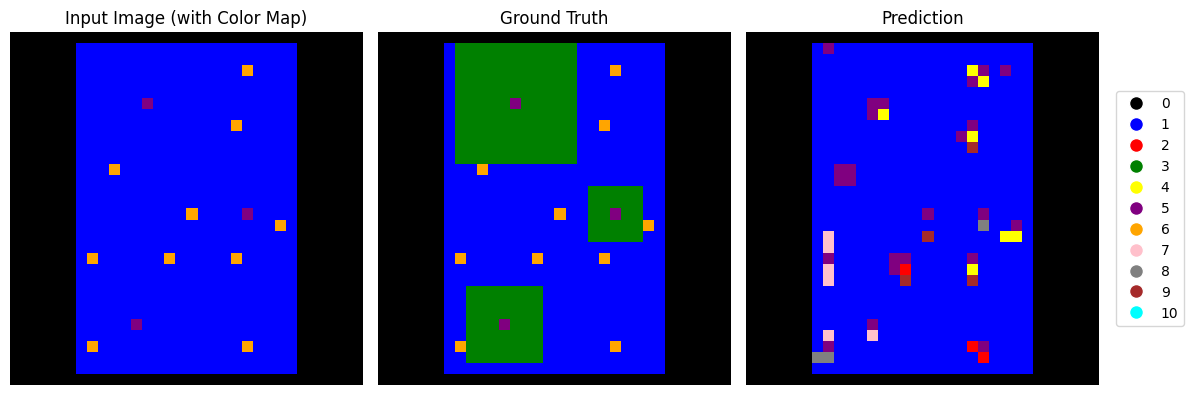


Epoch [371/1000] Complete
Average Loss: 0.177483
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.44%



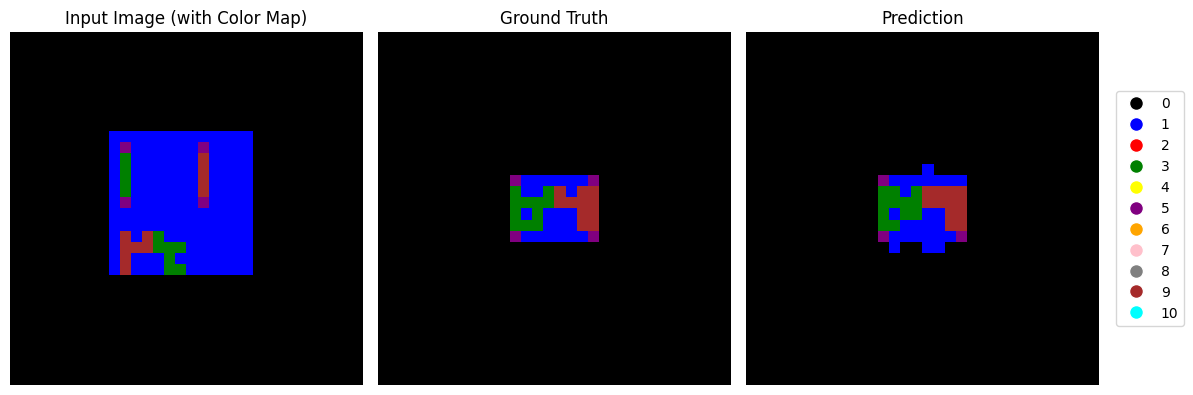

Test Average Loss: 7.438143
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.14%




Epoch [372/1000] Complete
Average Loss: 0.159876
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.83%



Test Average Loss: 7.538379
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.31%




Epoch [373/1000] Complete
Average Loss: 0.166679
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.53%



Test Average Loss: 7.509252
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.32%




Epoch [374/1000] Complete
Average Loss: 0.175716
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.19%



Test Average Loss: 7.495983
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.35%




Epoch [375/1000] Complete
Average Loss: 0.161547
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.68%



Test Average Loss: 7.130264
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.68%




Epoch [376/1000] Complete
Average Loss: 0.136399
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.65%



Test Average Loss: 7.264822
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.69%




Epoch [377/1000] Complete
Average Loss: 0.138401
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.92%



Test Average Loss: 7.791862
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.93%




Epoch [378/1000] Complete
Average Loss: 0.128900
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.17%



Test Average Loss: 7.937464
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.96%




Epoch [379/1000] Complete
Average Loss: 0.136870
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.69%



Test Average Loss: 7.738698
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.41%




Epoch [380/1000] Complete
Average Loss: 0.160138
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.81%



Test Average Loss: 7.335518
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.82%



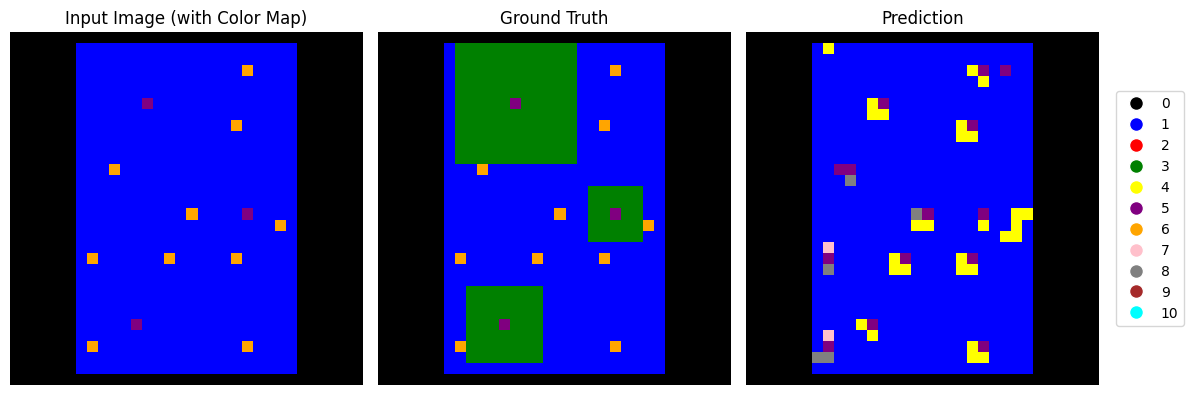


Epoch [381/1000] Complete
Average Loss: 0.164184
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.93%



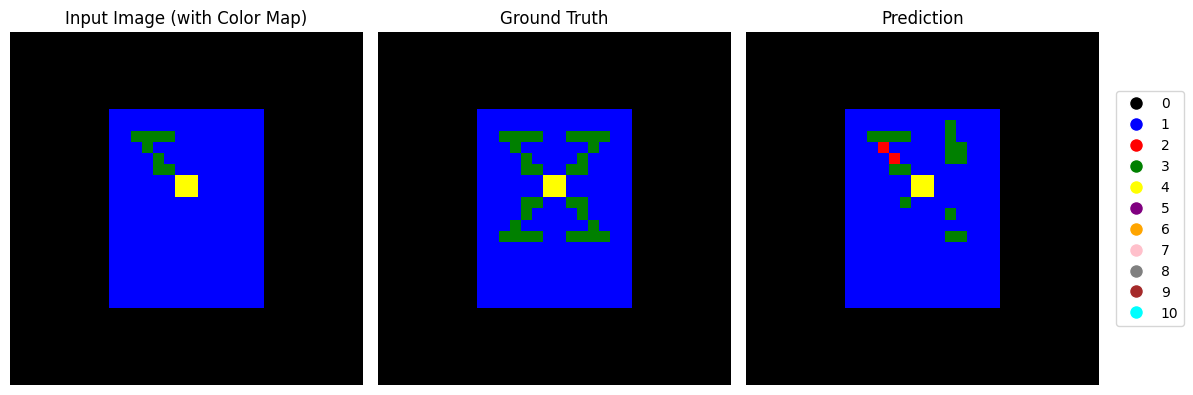

Test Average Loss: 7.296479
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.15%




Epoch [382/1000] Complete
Average Loss: 0.148226
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.23%



Test Average Loss: 6.966689
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.43%




Epoch [383/1000] Complete
Average Loss: 0.122153
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.53%



Test Average Loss: 8.006608
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.50%




Epoch [384/1000] Complete
Average Loss: 0.114421
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.85%



Test Average Loss: 7.884466
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.91%




Epoch [385/1000] Complete
Average Loss: 0.107265
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.96%



Test Average Loss: 7.091472
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.71%




Epoch [386/1000] Complete
Average Loss: 0.109825
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.07%



Test Average Loss: 8.663681
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.83%




Epoch [387/1000] Complete
Average Loss: 0.092708
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.80%



Test Average Loss: 8.825092
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.00%




Epoch [388/1000] Complete
Average Loss: 0.276351
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.37%



Test Average Loss: 7.005993
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.57%




Epoch [389/1000] Complete
Average Loss: 0.188298
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.29%



Test Average Loss: 5.621792
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.73%




Epoch [390/1000] Complete
Average Loss: 0.129414
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.46%



Test Average Loss: 6.610057
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.37%



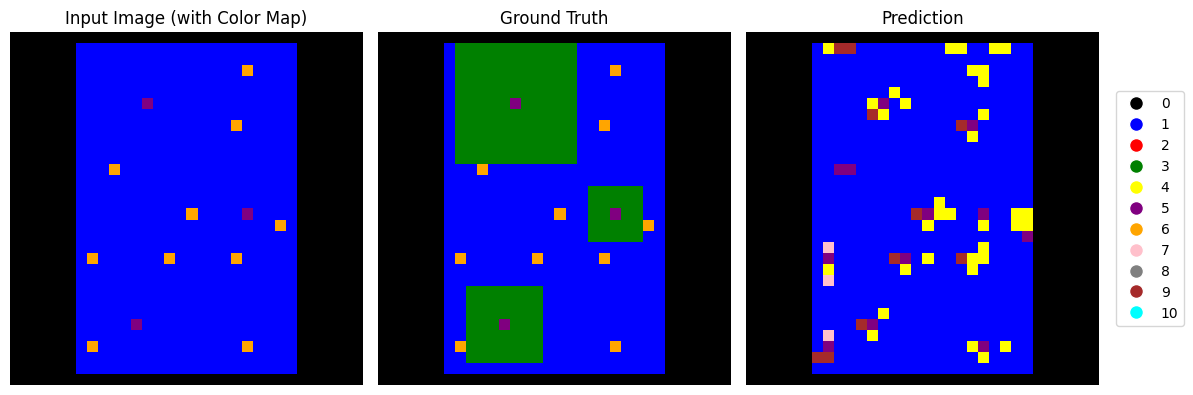


Epoch [391/1000] Complete
Average Loss: 0.099959
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.44%



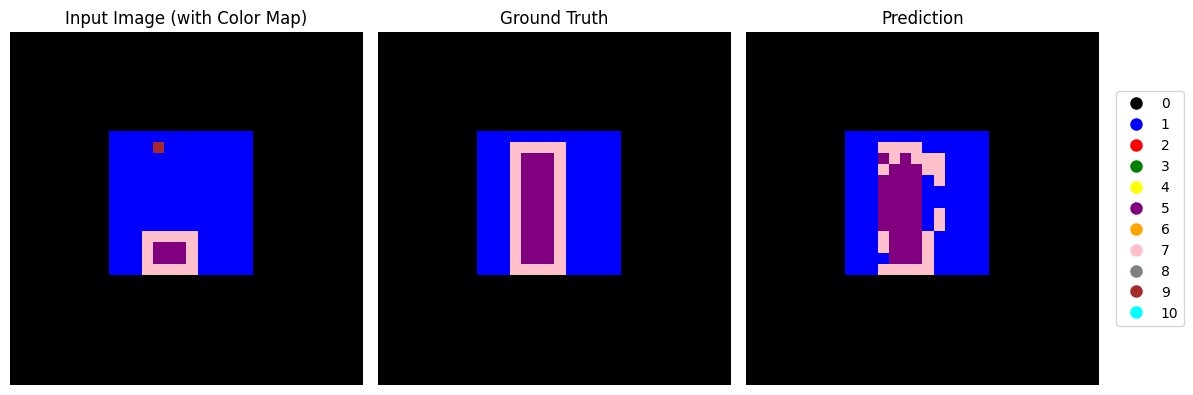

Test Average Loss: 6.830137
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.24%




Epoch [392/1000] Complete
Average Loss: 0.086494
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.18%



Test Average Loss: 7.874528
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.62%




Epoch [393/1000] Complete
Average Loss: 0.085879
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.06%



Test Average Loss: 7.824949
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.32%




Epoch [394/1000] Complete
Average Loss: 0.080708
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.47%



Test Average Loss: 7.665212
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.96%




Epoch [395/1000] Complete
Average Loss: 0.090385
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.84%



Test Average Loss: 7.702783
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.52%




Epoch [396/1000] Complete
Average Loss: 0.079900
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.35%



Test Average Loss: 7.927073
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.21%




Epoch [397/1000] Complete
Average Loss: 0.071481
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.62%



Test Average Loss: 8.033761
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.88%




Epoch [398/1000] Complete
Average Loss: 0.062676
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.09%



Test Average Loss: 7.974831
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.63%




Epoch [399/1000] Complete
Average Loss: 0.059495
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.22%



Test Average Loss: 8.487811
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.89%




Epoch [400/1000] Complete
Average Loss: 0.054744
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.48%



Test Average Loss: 9.064454
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.02%



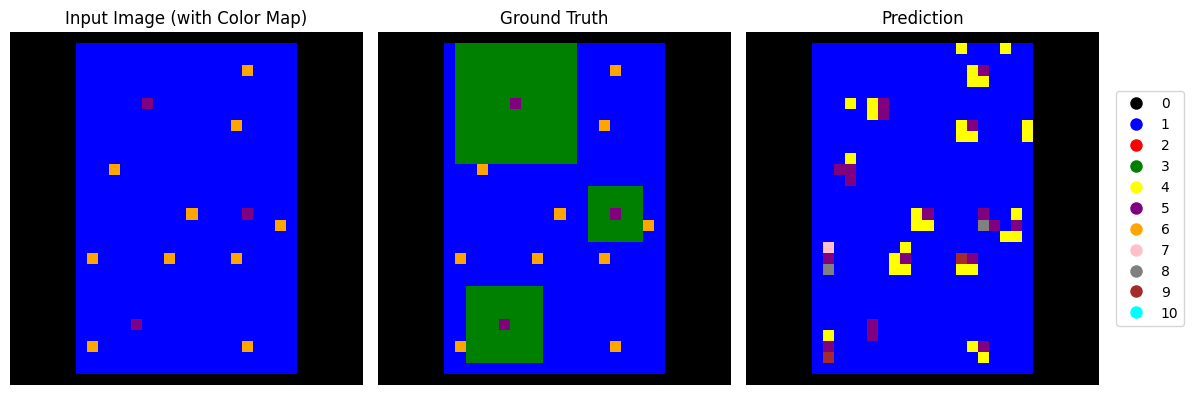


Epoch [401/1000] Complete
Average Loss: 0.058362
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.34%



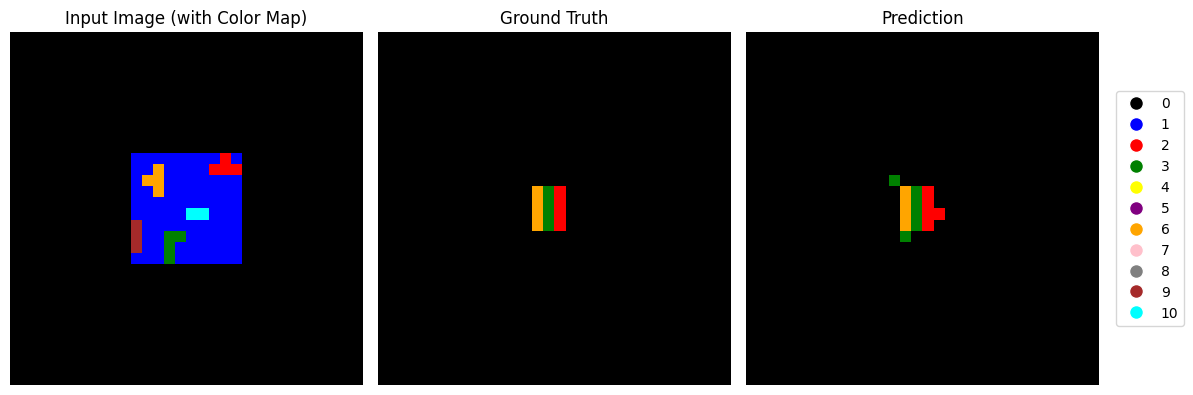

Test Average Loss: 8.571758
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.46%




Epoch [402/1000] Complete
Average Loss: 0.069000
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.94%



Test Average Loss: 8.156500
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.10%




Epoch [403/1000] Complete
Average Loss: 0.073384
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.80%



Test Average Loss: 8.220275
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.51%




Epoch [404/1000] Complete
Average Loss: 0.058605
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.32%



Test Average Loss: 8.561512
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.15%




Epoch [405/1000] Complete
Average Loss: 0.055668
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.48%



Test Average Loss: 8.871918
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.12%




Epoch [406/1000] Complete
Average Loss: 0.050746
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.75%



Test Average Loss: 8.815510
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.01%




Epoch [407/1000] Complete
Average Loss: 0.050742
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.70%



Test Average Loss: 8.774038
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.51%




Epoch [408/1000] Complete
Average Loss: 0.062637
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.26%



Test Average Loss: 9.698678
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.52%




Epoch [409/1000] Complete
Average Loss: 0.058110
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.27%



Test Average Loss: 8.616424
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.25%




Epoch [410/1000] Complete
Average Loss: 0.047933
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.81%



Test Average Loss: 8.841837
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.45%



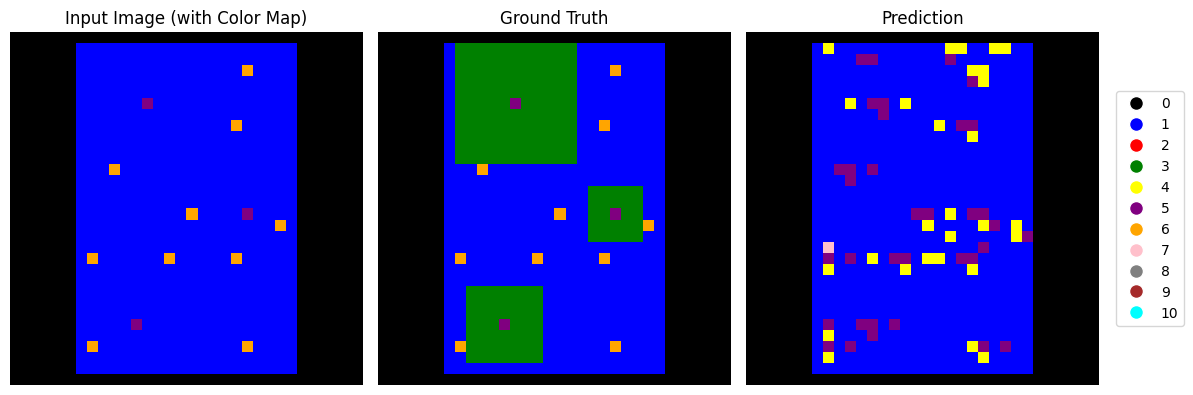


Epoch [411/1000] Complete
Average Loss: 0.052271
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.74%



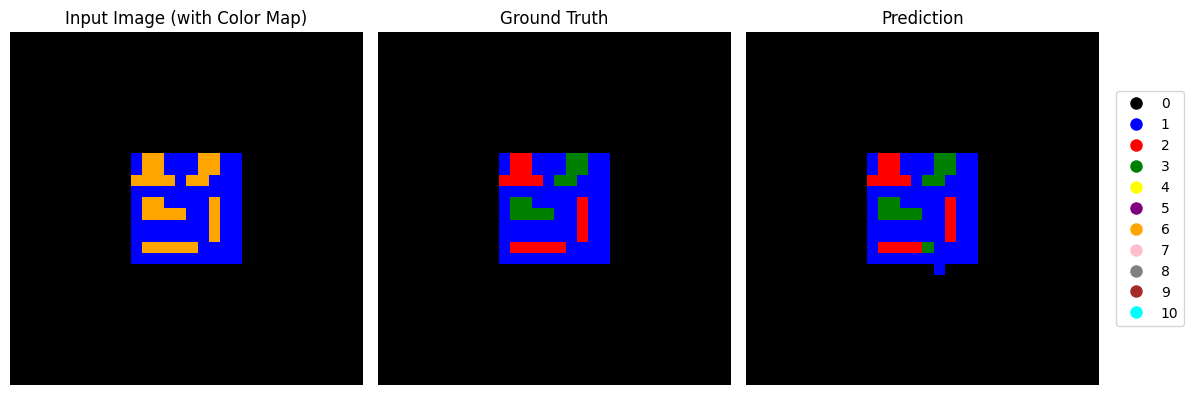

Test Average Loss: 8.796038
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.66%




Epoch [412/1000] Complete
Average Loss: 0.055778
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.45%



Test Average Loss: 8.429706
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.24%




Epoch [413/1000] Complete
Average Loss: 0.058763
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.39%



Test Average Loss: 8.884494
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.72%




Epoch [414/1000] Complete
Average Loss: 0.061153
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.47%



Test Average Loss: 9.008946
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.64%




Epoch [415/1000] Complete
Average Loss: 0.048602
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.84%



Test Average Loss: 9.035452
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.57%




Epoch [416/1000] Complete
Average Loss: 0.056617
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.51%



Test Average Loss: 8.520046
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.77%




Epoch [417/1000] Complete
Average Loss: 0.038930
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.21%



Test Average Loss: 8.430274
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.68%




Epoch [418/1000] Complete
Average Loss: 0.102936
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.89%



Test Average Loss: 7.716649
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.85%




Epoch [419/1000] Complete
Average Loss: 0.129770
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.04%



Test Average Loss: 5.982001
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.47%




Epoch [420/1000] Complete
Average Loss: 0.063359
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.27%



Test Average Loss: 5.824557
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.05%



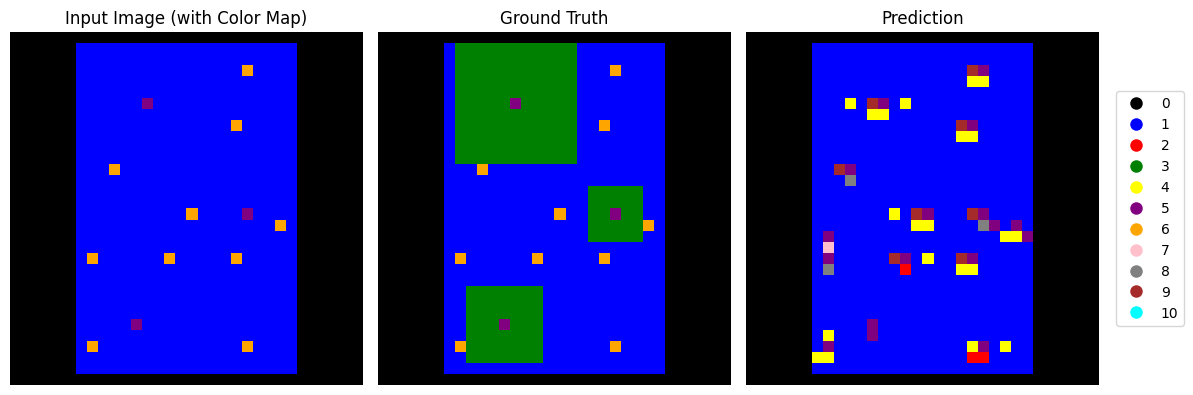


Epoch [421/1000] Complete
Average Loss: 0.065612
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.15%



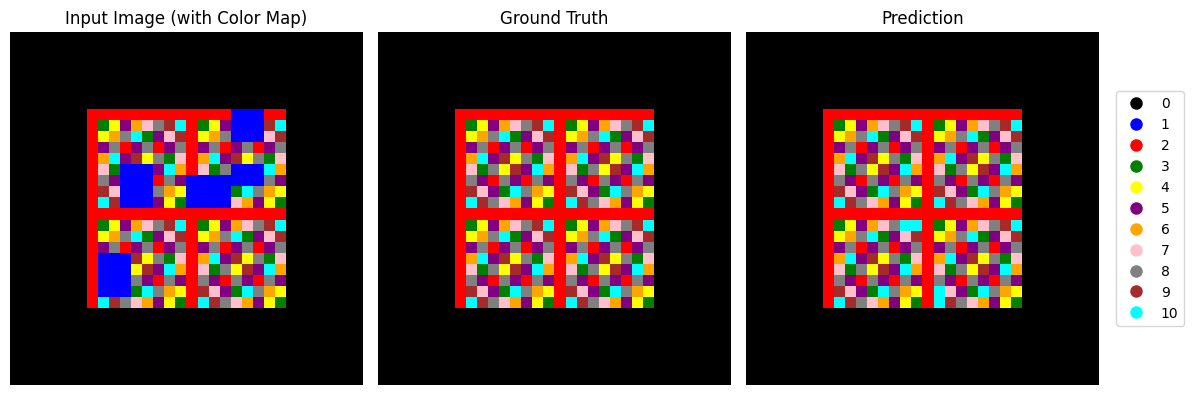

Test Average Loss: 9.213672
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.29%




Epoch [422/1000] Complete
Average Loss: 0.048510
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.97%



Test Average Loss: 8.921412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.25%




Epoch [423/1000] Complete
Average Loss: 0.045613
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.97%



Test Average Loss: 7.751397
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.30%




Epoch [424/1000] Complete
Average Loss: 0.045667
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.02%



Test Average Loss: 8.868205
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.11%




Epoch [425/1000] Complete
Average Loss: 0.051920
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.03%



Test Average Loss: 8.964947
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.91%




Epoch [426/1000] Complete
Average Loss: 0.058764
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.65%



Test Average Loss: 8.484879
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.20%




Epoch [427/1000] Complete
Average Loss: 0.074391
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.98%



Test Average Loss: 9.238020
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.23%




Epoch [428/1000] Complete
Average Loss: 0.050733
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.78%



Test Average Loss: 8.502123
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.24%




Epoch [429/1000] Complete
Average Loss: 0.035357
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.48%



Test Average Loss: 8.497706
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.91%




Epoch [430/1000] Complete
Average Loss: 0.026165
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.83%



Test Average Loss: 8.837165
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.91%



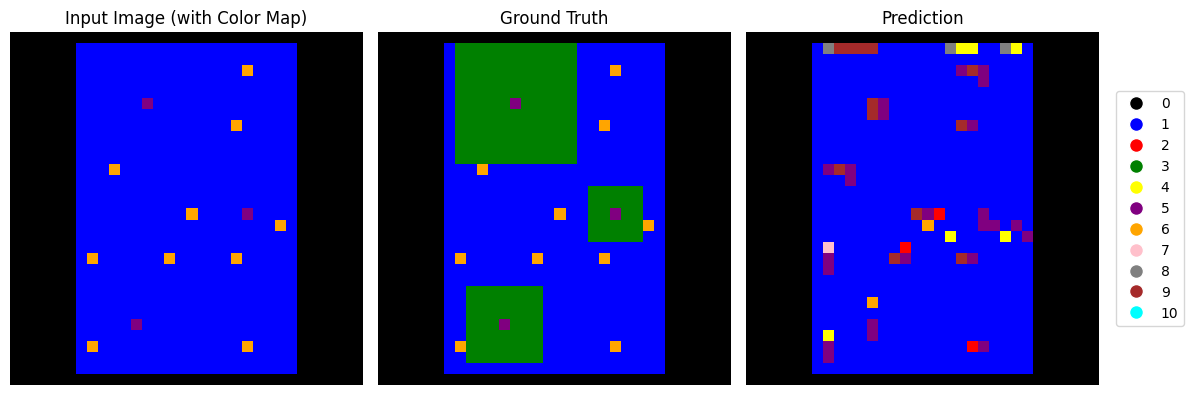


Epoch [431/1000] Complete
Average Loss: 0.019823
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.10%



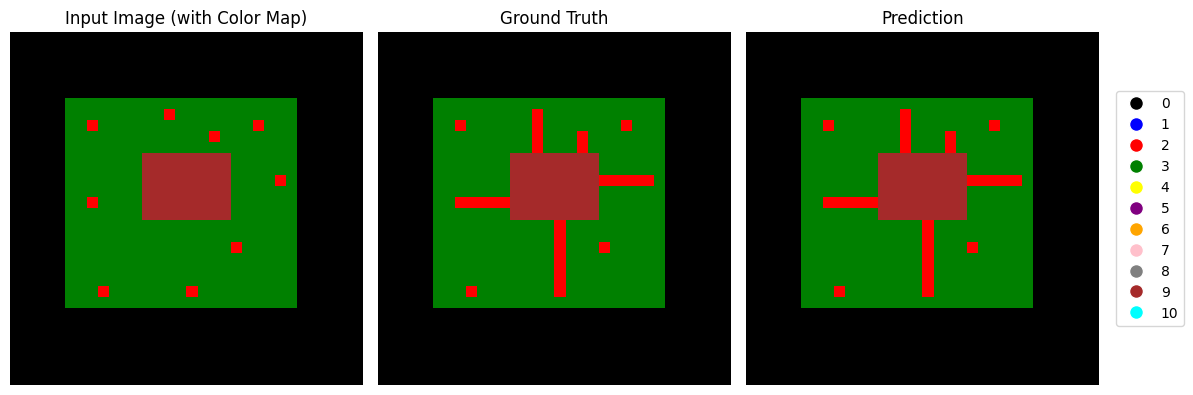

Test Average Loss: 9.390886
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.01%




Epoch [432/1000] Complete
Average Loss: 0.021210
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.14%



Test Average Loss: 9.239908
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.00%




Epoch [433/1000] Complete
Average Loss: 0.017678
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.31%



Test Average Loss: 9.840822
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.07%




Epoch [434/1000] Complete
Average Loss: 0.015921
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.27%



Test Average Loss: 9.971036
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.40%




Epoch [435/1000] Complete
Average Loss: 0.022299
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.12%



Test Average Loss: 9.384496
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.83%




Epoch [436/1000] Complete
Average Loss: 0.021306
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.13%



Test Average Loss: 8.883578
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.19%




Epoch [437/1000] Complete
Average Loss: 0.025593
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.93%



Test Average Loss: 9.621266
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.24%




Epoch [438/1000] Complete
Average Loss: 0.027749
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.86%



Test Average Loss: 9.334900
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.05%




Epoch [439/1000] Complete
Average Loss: 0.023735
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.00%



Test Average Loss: 8.721522
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.38%




Epoch [440/1000] Complete
Average Loss: 0.040182
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.40%



Test Average Loss: 8.519785
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.51%



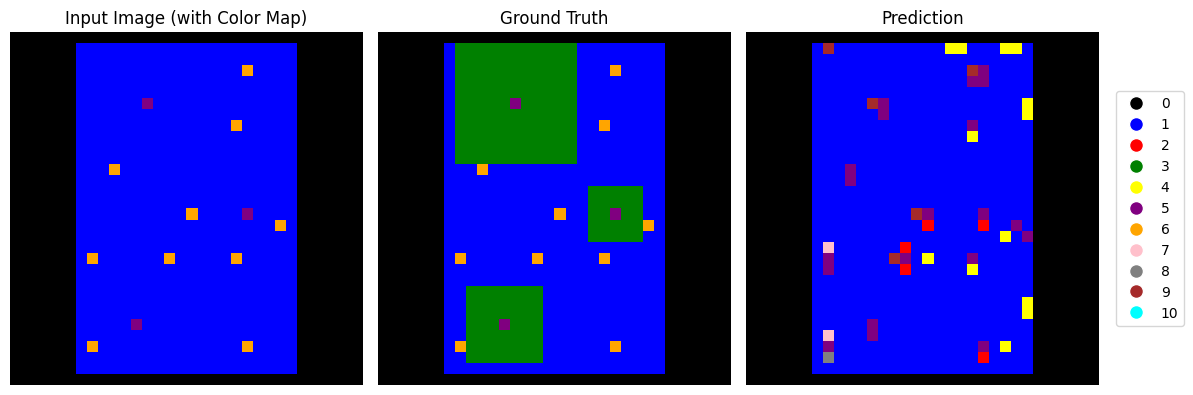


Epoch [441/1000] Complete
Average Loss: 0.044963
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.38%



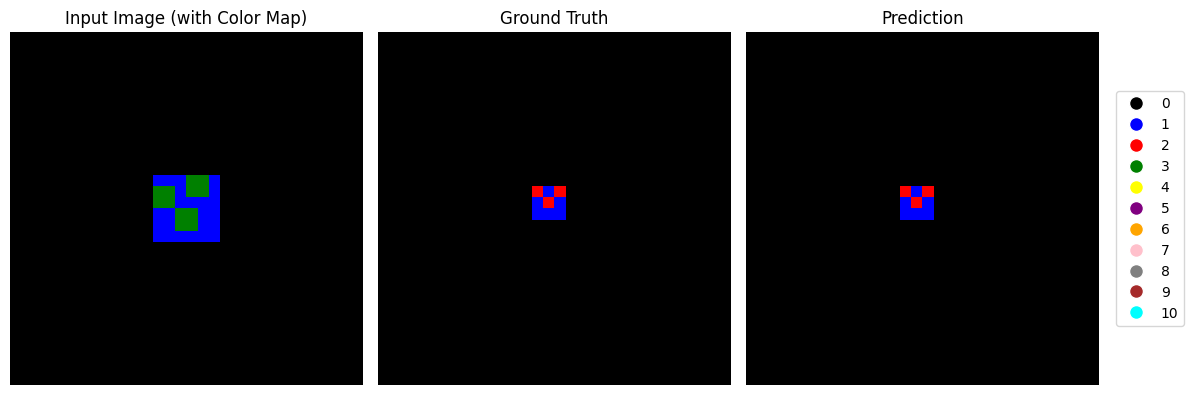

Test Average Loss: 8.361346
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.54%




Epoch [442/1000] Complete
Average Loss: 0.121671
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.03%



Test Average Loss: 9.067169
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.84%




Epoch [443/1000] Complete
Average Loss: 0.138733
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.61%



Test Average Loss: 8.282626
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.43%




Epoch [444/1000] Complete
Average Loss: 0.082218
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.39%



Test Average Loss: 7.125255
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.26%




Epoch [445/1000] Complete
Average Loss: 0.059907
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.65%



Test Average Loss: 8.204672
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.96%




Epoch [446/1000] Complete
Average Loss: 0.076002
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.07%



Test Average Loss: 8.534697
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.62%




Epoch [447/1000] Complete
Average Loss: 0.045077
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.19%



Test Average Loss: 8.021109
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.72%




Epoch [448/1000] Complete
Average Loss: 0.021705
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.09%



Test Average Loss: 7.675186
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.55%




Epoch [449/1000] Complete
Average Loss: 0.017530
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.30%



Test Average Loss: 8.538884
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.32%




Epoch [450/1000] Complete
Average Loss: 0.018541
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.30%



Test Average Loss: 9.184684
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.43%



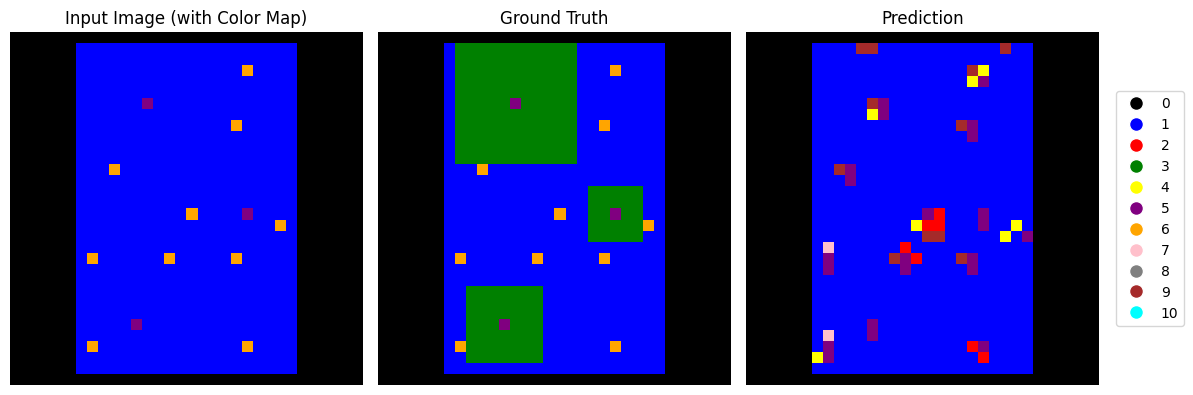


Epoch [451/1000] Complete
Average Loss: 0.014459
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.42%



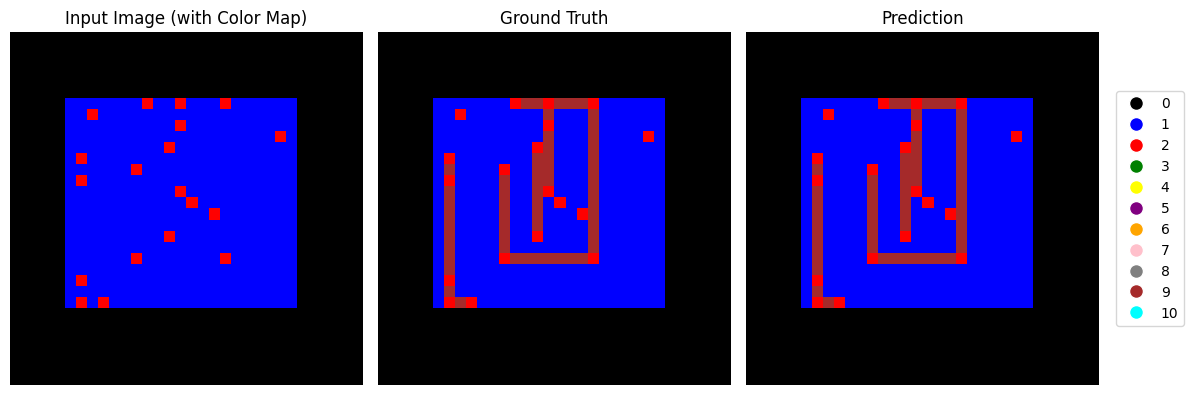

Test Average Loss: 9.495770
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.35%




Epoch [452/1000] Complete
Average Loss: 0.009840
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.61%



Test Average Loss: 9.469443
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.11%




Epoch [453/1000] Complete
Average Loss: 0.009864
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.62%



Test Average Loss: 9.742134
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.10%




Epoch [454/1000] Complete
Average Loss: 0.033687
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.82%



Test Average Loss: 8.940043
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.43%




Epoch [455/1000] Complete
Average Loss: 0.016689
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.34%



Test Average Loss: 9.303442
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.98%




Epoch [456/1000] Complete
Average Loss: 0.012255
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.52%



Test Average Loss: 9.450491
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.79%




Epoch [457/1000] Complete
Average Loss: 0.011787
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.54%



Test Average Loss: 10.209727
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.40%




Epoch [458/1000] Complete
Average Loss: 0.017190
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.32%



Test Average Loss: 7.878793
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.63%




Epoch [459/1000] Complete
Average Loss: 0.043809
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.26%



Test Average Loss: 8.603880
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.71%




Epoch [460/1000] Complete
Average Loss: 0.024456
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.01%



Test Average Loss: 9.190509
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.21%



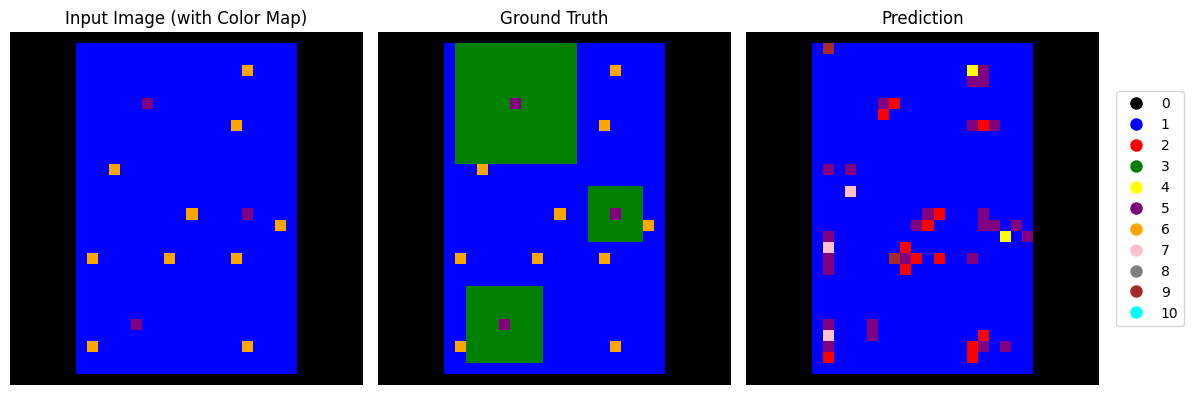


Epoch [461/1000] Complete
Average Loss: 0.018415
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.21%



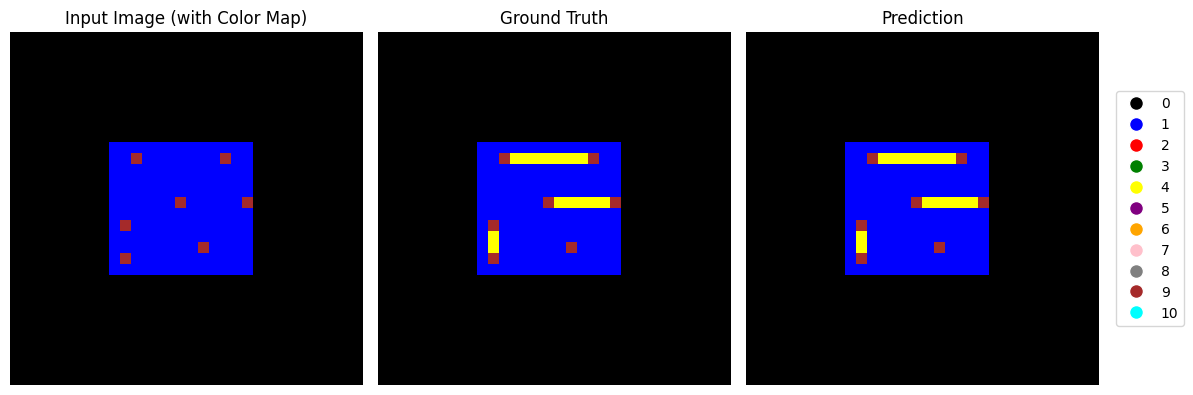

Test Average Loss: 9.459041
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.33%




Epoch [462/1000] Complete
Average Loss: 0.024205
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.12%



Test Average Loss: 9.442915
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.83%




Epoch [463/1000] Complete
Average Loss: 0.033018
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.67%



Test Average Loss: 11.527495
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.83%




Epoch [464/1000] Complete
Average Loss: 0.038816
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.42%



Test Average Loss: 9.857385
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.62%




Epoch [465/1000] Complete
Average Loss: 0.035364
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.54%



Test Average Loss: 7.351712
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.56%




Epoch [466/1000] Complete
Average Loss: 0.031531
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.86%



Test Average Loss: 8.586495
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.66%




Epoch [467/1000] Complete
Average Loss: 0.032126
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.45%



Test Average Loss: 9.920674
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.30%




Epoch [468/1000] Complete
Average Loss: 0.071949
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.89%



Test Average Loss: 7.864745
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 45.06%




Epoch [469/1000] Complete
Average Loss: 0.206739
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.83%



Test Average Loss: 8.761559
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.77%




Epoch [470/1000] Complete
Average Loss: 0.102624
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.93%



Test Average Loss: 8.712799
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.00%



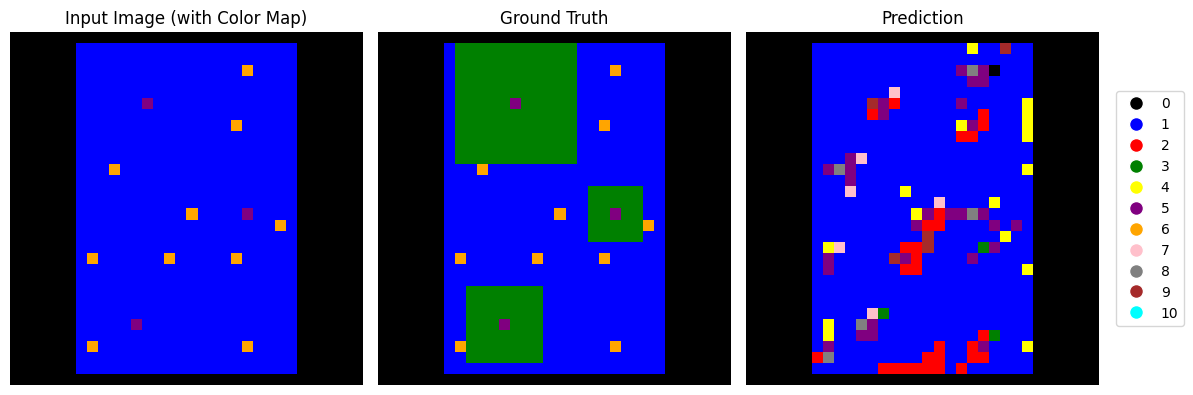


Epoch [471/1000] Complete
Average Loss: 0.049732
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.02%



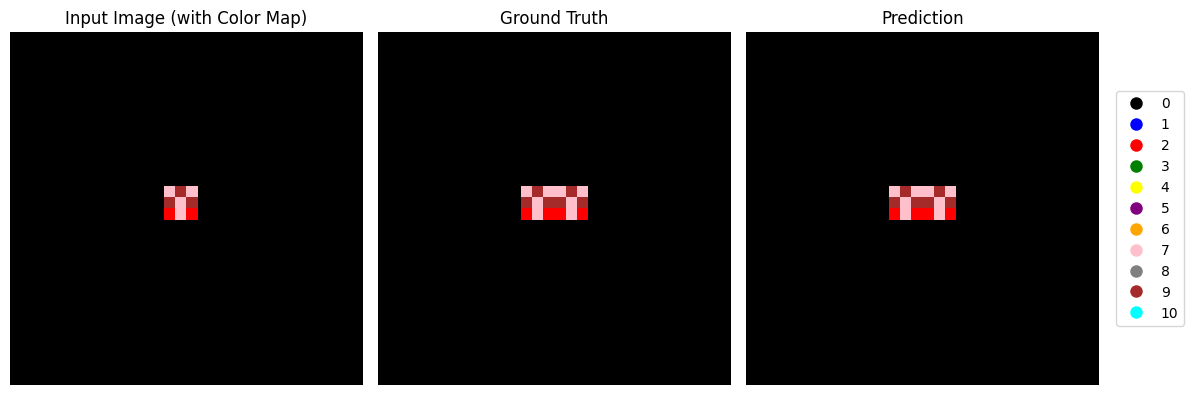

Test Average Loss: 7.755957
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.47%




Epoch [472/1000] Complete
Average Loss: 0.024692
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.01%



Test Average Loss: 8.470878
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.39%




Epoch [473/1000] Complete
Average Loss: 0.016938
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.34%



Test Average Loss: 9.433055
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.91%




Epoch [474/1000] Complete
Average Loss: 0.012403
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 8.710511
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.56%




Epoch [475/1000] Complete
Average Loss: 0.012214
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.55%



Test Average Loss: 10.233806
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.55%




Epoch [476/1000] Complete
Average Loss: 0.009150
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.68%



Test Average Loss: 10.359286
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.90%




Epoch [477/1000] Complete
Average Loss: 0.005732
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 10.652050
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.50%




Epoch [478/1000] Complete
Average Loss: 0.006202
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 9.868282
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.80%




Epoch [479/1000] Complete
Average Loss: 0.012431
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 11.390291
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.49%




Epoch [480/1000] Complete
Average Loss: 0.009582
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 10.521546
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.38%



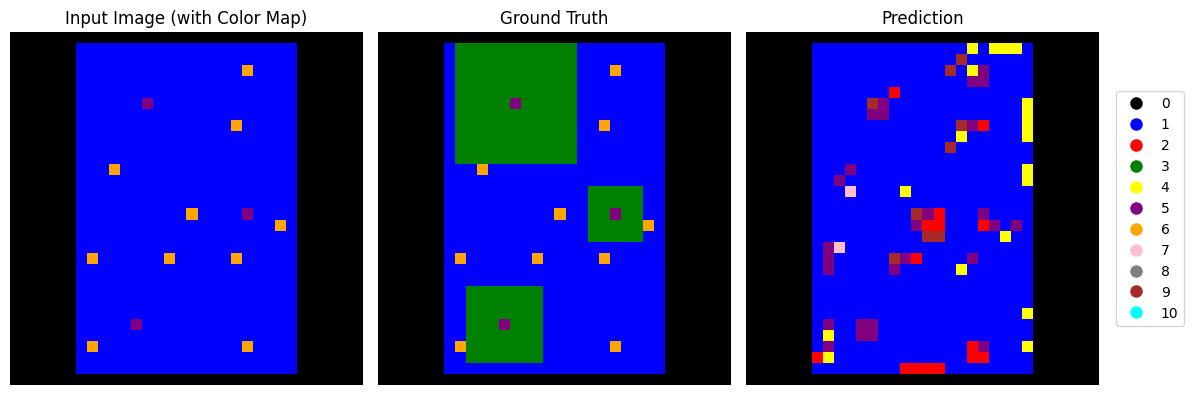


Epoch [481/1000] Complete
Average Loss: 0.008921
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



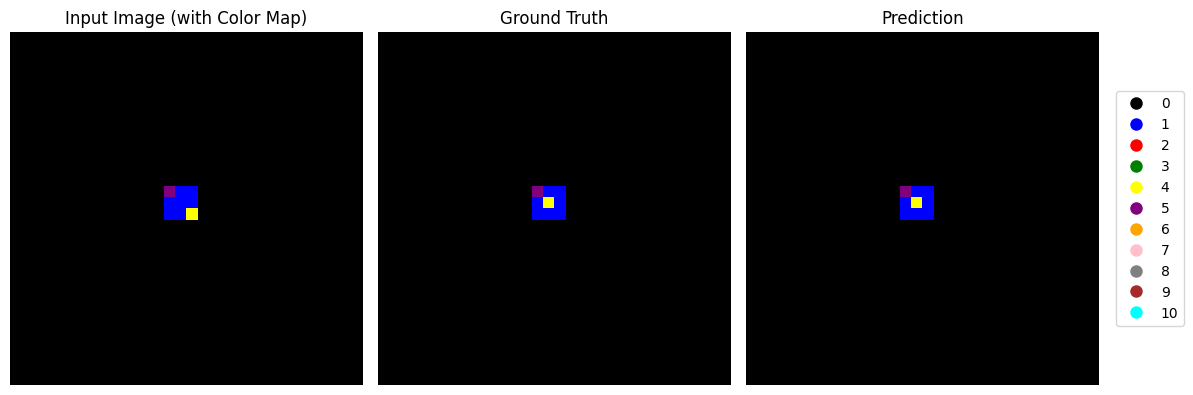

Test Average Loss: 10.686396
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.12%




Epoch [482/1000] Complete
Average Loss: 0.007521
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 11.219790
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.05%




Epoch [483/1000] Complete
Average Loss: 0.005914
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.78%



Test Average Loss: 10.654746
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.09%




Epoch [484/1000] Complete
Average Loss: 0.006354
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 10.381230
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.99%




Epoch [485/1000] Complete
Average Loss: 0.005890
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 12.035858
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.06%




Epoch [486/1000] Complete
Average Loss: 0.008350
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.72%



Test Average Loss: 10.018797
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.33%




Epoch [487/1000] Complete
Average Loss: 0.008842
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 10.675417
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.94%




Epoch [488/1000] Complete
Average Loss: 0.008700
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 11.359146
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.25%




Epoch [489/1000] Complete
Average Loss: 0.007110
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.73%



Test Average Loss: 11.518458
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.87%




Epoch [490/1000] Complete
Average Loss: 0.010556
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



Test Average Loss: 10.877763
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.50%



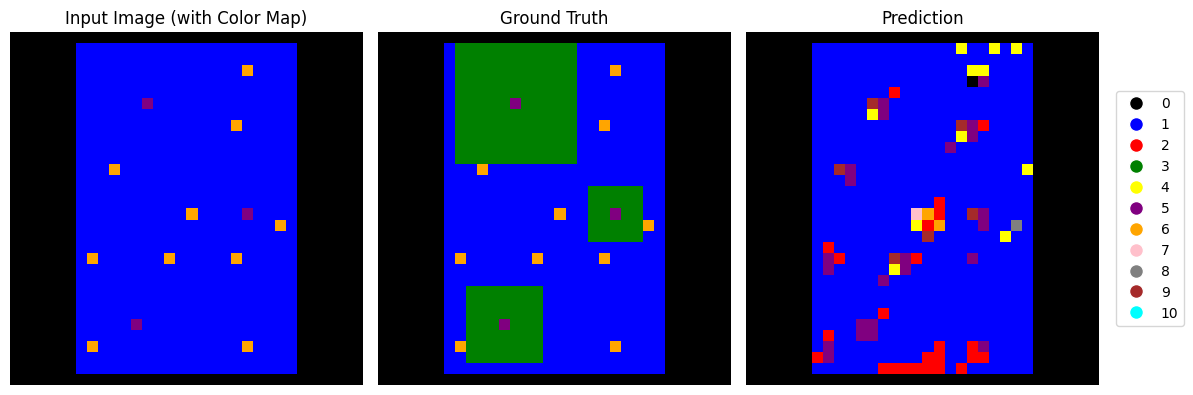


Epoch [491/1000] Complete
Average Loss: 0.010241
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.63%



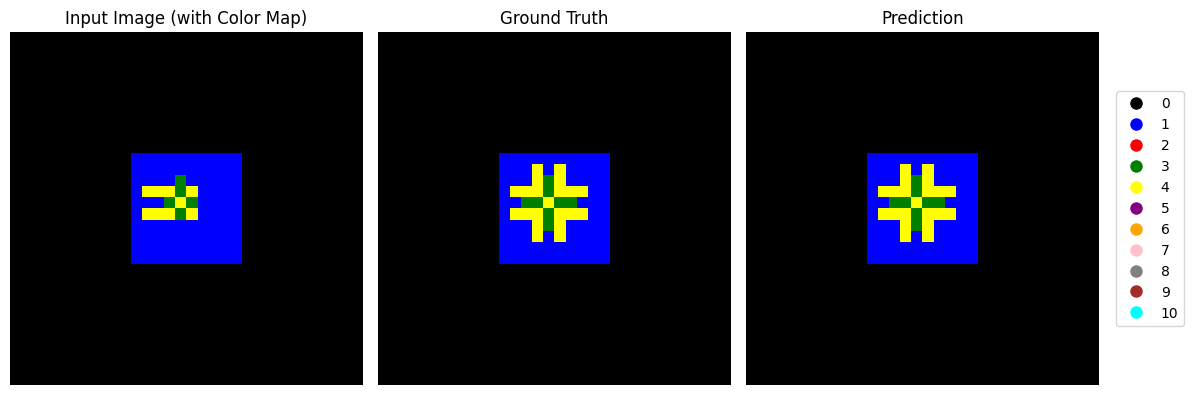

Test Average Loss: 11.080998
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.52%




Epoch [492/1000] Complete
Average Loss: 0.019611
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.23%



Test Average Loss: 9.431668
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.36%




Epoch [493/1000] Complete
Average Loss: 0.024299
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.08%



Test Average Loss: 8.486907
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.62%




Epoch [494/1000] Complete
Average Loss: 0.016876
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.29%



Test Average Loss: 9.986307
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.96%




Epoch [495/1000] Complete
Average Loss: 0.020140
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.18%



Test Average Loss: 9.924705
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.42%




Epoch [496/1000] Complete
Average Loss: 0.033068
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.66%



Test Average Loss: 9.518922
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.84%




Epoch [497/1000] Complete
Average Loss: 0.054280
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.75%



Test Average Loss: 9.602902
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.52%




Epoch [498/1000] Complete
Average Loss: 0.070083
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.12%



Test Average Loss: 8.560988
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.98%




Epoch [499/1000] Complete
Average Loss: 0.067777
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.79%



Test Average Loss: 12.028208
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.10%




Epoch [500/1000] Complete
Average Loss: 0.085863
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.05%



Test Average Loss: 9.222824
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.01%



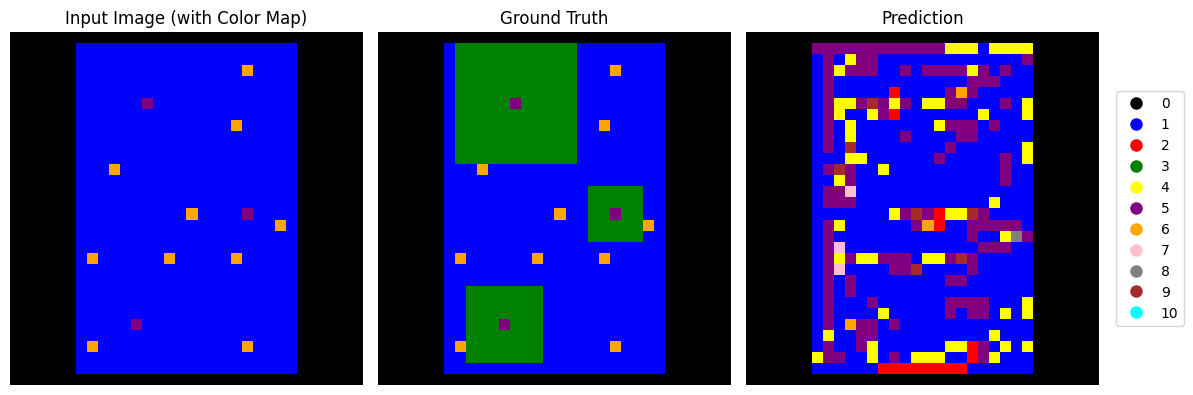


Epoch [501/1000] Complete
Average Loss: 0.076587
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.25%



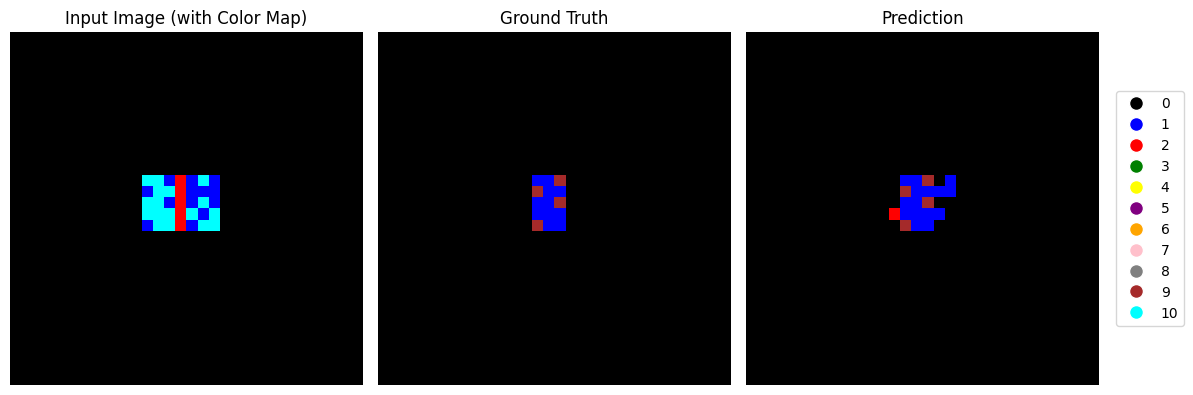

Test Average Loss: 9.959164
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.52%




Epoch [502/1000] Complete
Average Loss: 0.090592
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.54%



Test Average Loss: 9.152334
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.18%




Epoch [503/1000] Complete
Average Loss: 0.087491
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.62%



Test Average Loss: 8.738861
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.96%




Epoch [504/1000] Complete
Average Loss: 0.044560
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.22%



Test Average Loss: 8.388170
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.22%




Epoch [505/1000] Complete
Average Loss: 0.024835
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.10%



Test Average Loss: 7.795530
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.41%




Epoch [506/1000] Complete
Average Loss: 0.010525
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.55%



Test Average Loss: 9.170550
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.92%




Epoch [507/1000] Complete
Average Loss: 0.012357
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 9.659794
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.59%




Epoch [508/1000] Complete
Average Loss: 0.014102
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 10.505685
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.73%




Epoch [509/1000] Complete
Average Loss: 0.011704
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.52%



Test Average Loss: 11.792284
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.40%




Epoch [510/1000] Complete
Average Loss: 0.007378
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.73%



Test Average Loss: 13.654657
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.91%



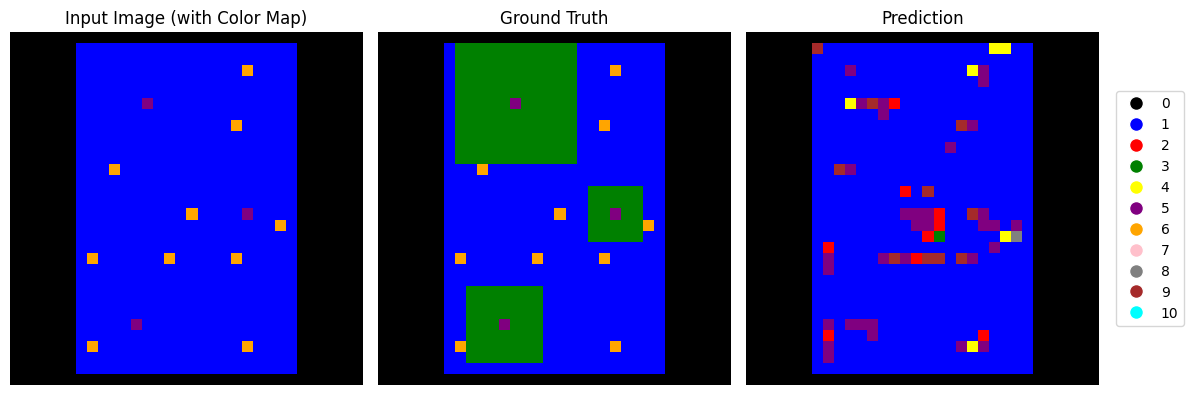


Epoch [511/1000] Complete
Average Loss: 0.004532
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.82%



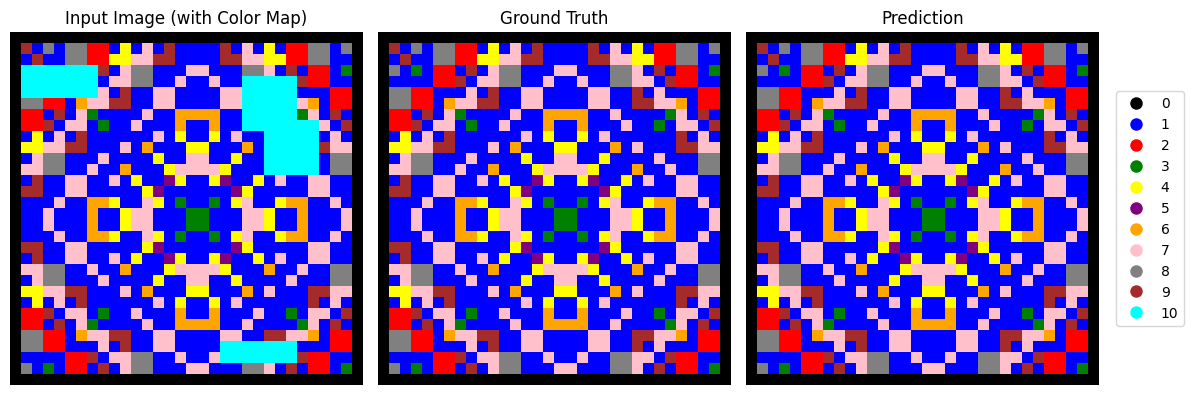

Test Average Loss: 11.248504
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.08%




Epoch [512/1000] Complete
Average Loss: 0.005150
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 10.401524
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.26%




Epoch [513/1000] Complete
Average Loss: 0.004407
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



Test Average Loss: 11.961895
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.08%




Epoch [514/1000] Complete
Average Loss: 0.004662
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



Test Average Loss: 10.114395
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.68%




Epoch [515/1000] Complete
Average Loss: 0.004357
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



Test Average Loss: 11.439581
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.24%




Epoch [516/1000] Complete
Average Loss: 0.002334
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 10.887362
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.72%




Epoch [517/1000] Complete
Average Loss: 0.001694
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 10.513249
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.68%




Epoch [518/1000] Complete
Average Loss: 0.002554
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 11.442341
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.11%




Epoch [519/1000] Complete
Average Loss: 0.003323
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 12.332407
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.21%




Epoch [520/1000] Complete
Average Loss: 0.002929
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 12.669302
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.51%



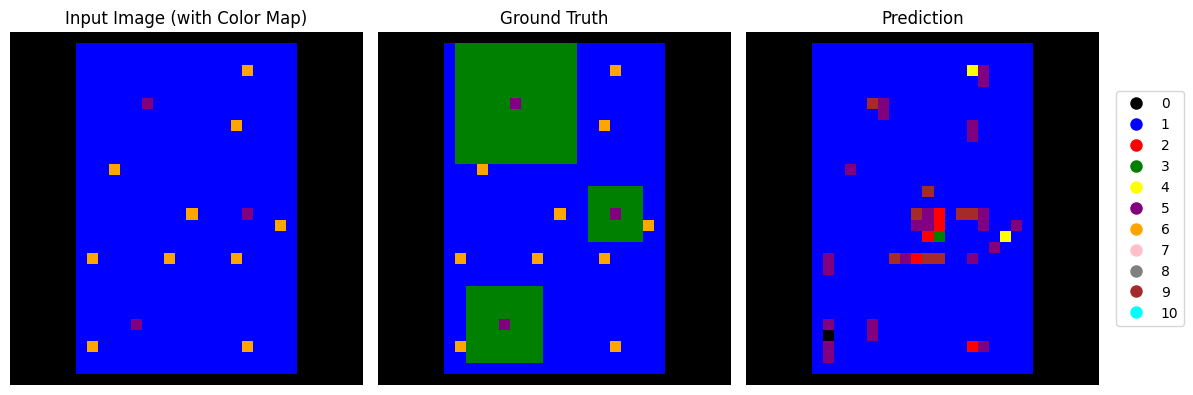


Epoch [521/1000] Complete
Average Loss: 0.002697
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



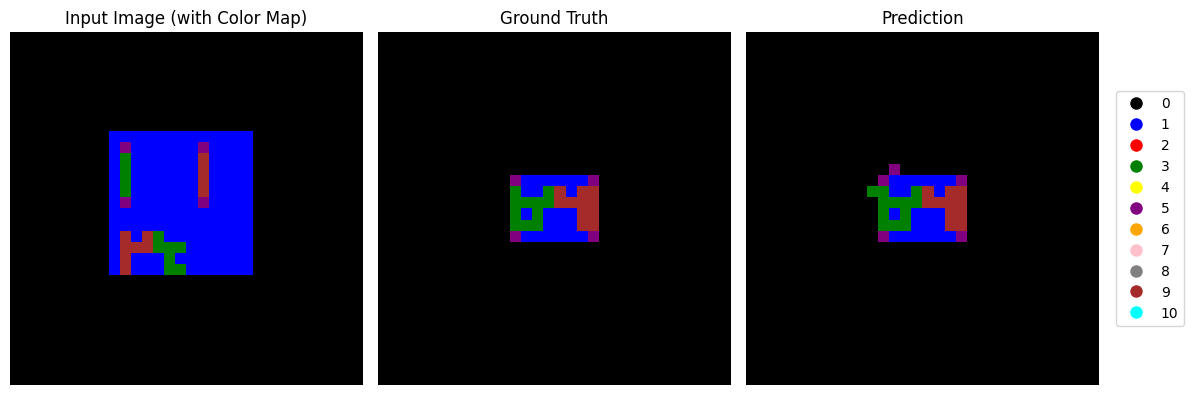

Test Average Loss: 11.075735
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.37%




Epoch [522/1000] Complete
Average Loss: 0.003119
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 10.647633
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.44%




Epoch [523/1000] Complete
Average Loss: 0.015647
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.49%



Test Average Loss: 9.234377
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.64%




Epoch [524/1000] Complete
Average Loss: 0.022074
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.17%



Test Average Loss: 9.153200
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.27%




Epoch [525/1000] Complete
Average Loss: 0.015805
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.41%



Test Average Loss: 8.899702
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.29%




Epoch [526/1000] Complete
Average Loss: 0.011915
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.51%



Test Average Loss: 8.813406
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.82%




Epoch [527/1000] Complete
Average Loss: 0.009395
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 9.686831
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.74%




Epoch [528/1000] Complete
Average Loss: 0.014345
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.49%



Test Average Loss: 10.129151
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.05%




Epoch [529/1000] Complete
Average Loss: 0.025708
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.08%



Test Average Loss: 7.938310
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.09%




Epoch [530/1000] Complete
Average Loss: 0.019821
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.29%



Test Average Loss: 9.317593
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.28%



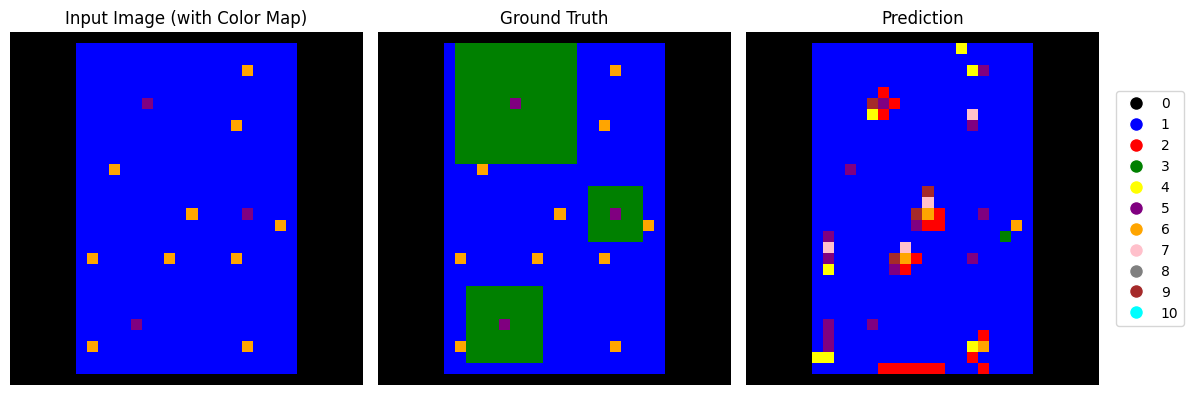


Epoch [531/1000] Complete
Average Loss: 0.022015
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.15%



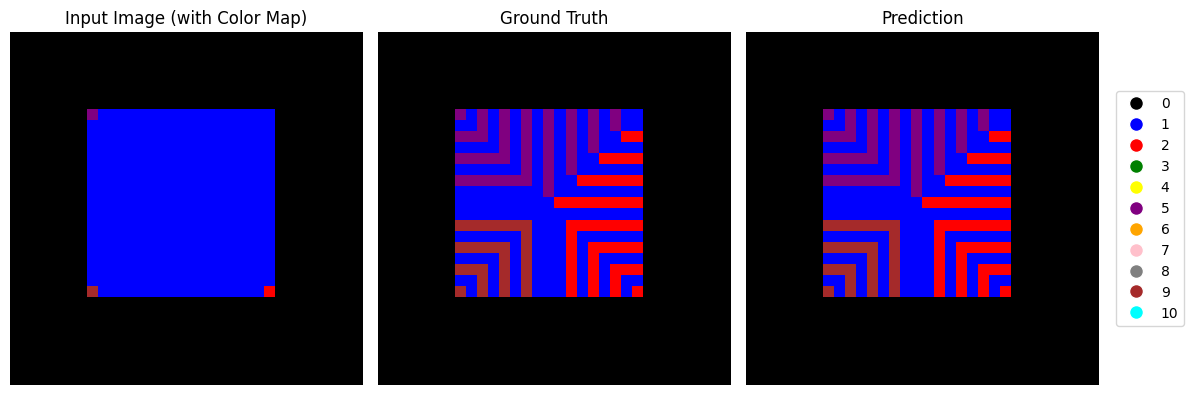

Test Average Loss: 10.754551
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.66%




Epoch [532/1000] Complete
Average Loss: 0.019297
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.29%



Test Average Loss: 10.263638
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.64%




Epoch [533/1000] Complete
Average Loss: 0.025019
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.15%



Test Average Loss: 11.047473
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.80%




Epoch [534/1000] Complete
Average Loss: 0.015446
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.46%



Test Average Loss: 9.451048
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.52%




Epoch [535/1000] Complete
Average Loss: 0.025609
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.11%



Test Average Loss: 10.527575
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.25%




Epoch [536/1000] Complete
Average Loss: 0.040573
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.50%



Test Average Loss: 11.036224
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.30%




Epoch [537/1000] Complete
Average Loss: 0.034140
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.70%



Test Average Loss: 10.875224
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.80%




Epoch [538/1000] Complete
Average Loss: 0.025414
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.08%



Test Average Loss: 10.819319
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.01%




Epoch [539/1000] Complete
Average Loss: 0.019772
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.24%



Test Average Loss: 9.492295
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.13%




Epoch [540/1000] Complete
Average Loss: 0.016658
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.43%



Test Average Loss: 9.918291
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.49%



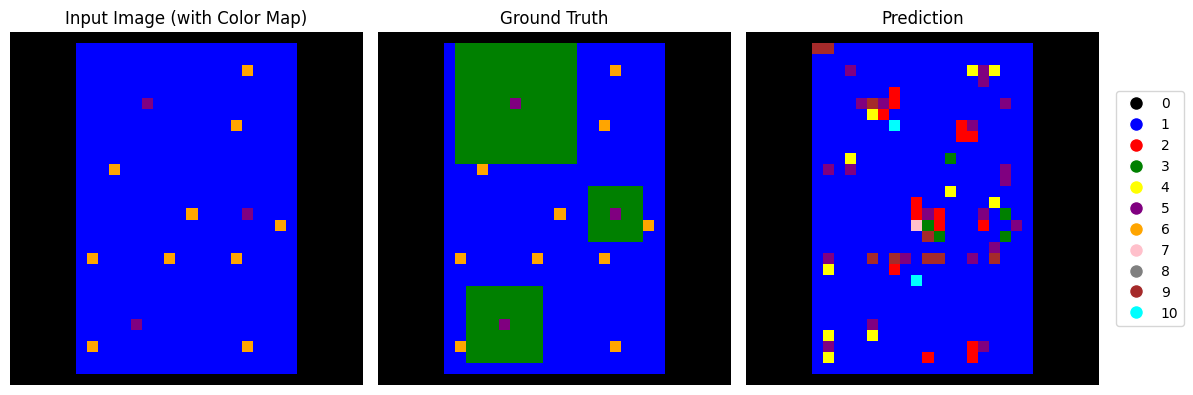


Epoch [541/1000] Complete
Average Loss: 0.013585
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.50%



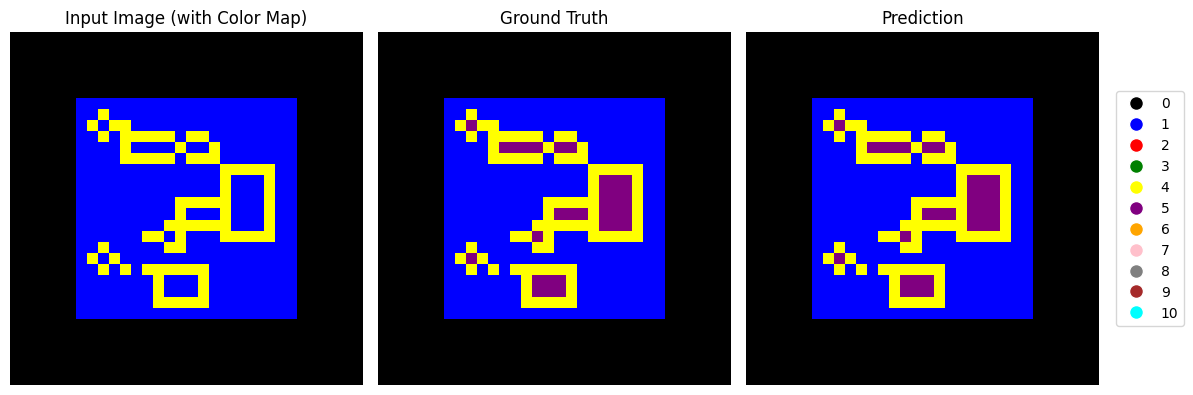

Test Average Loss: 12.161486
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.60%




Epoch [542/1000] Complete
Average Loss: 0.012512
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.56%



Test Average Loss: 11.504296
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.29%




Epoch [543/1000] Complete
Average Loss: 0.068412
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.80%



Test Average Loss: 7.711927
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.48%




Epoch [544/1000] Complete
Average Loss: 0.262754
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.61%



Test Average Loss: 8.054020
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.12%




Epoch [545/1000] Complete
Average Loss: 0.411637
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 86.65%



Test Average Loss: 7.857517
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 45.46%




Epoch [546/1000] Complete
Average Loss: 0.458588
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 84.24%



Test Average Loss: 9.101176
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.54%




Epoch [547/1000] Complete
Average Loss: 0.204173
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.79%



Test Average Loss: 9.436519
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.78%




Epoch [548/1000] Complete
Average Loss: 0.093969
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.27%



Test Average Loss: 9.612833
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.67%




Epoch [549/1000] Complete
Average Loss: 0.053204
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.88%



Test Average Loss: 9.885632
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.28%




Epoch [550/1000] Complete
Average Loss: 0.039292
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.56%



Test Average Loss: 9.248667
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.21%



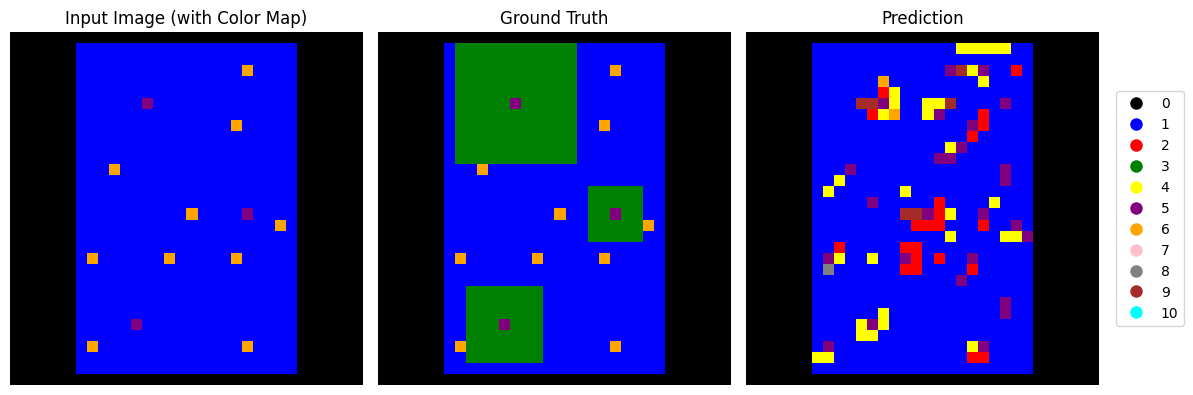


Epoch [551/1000] Complete
Average Loss: 0.039148
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.57%



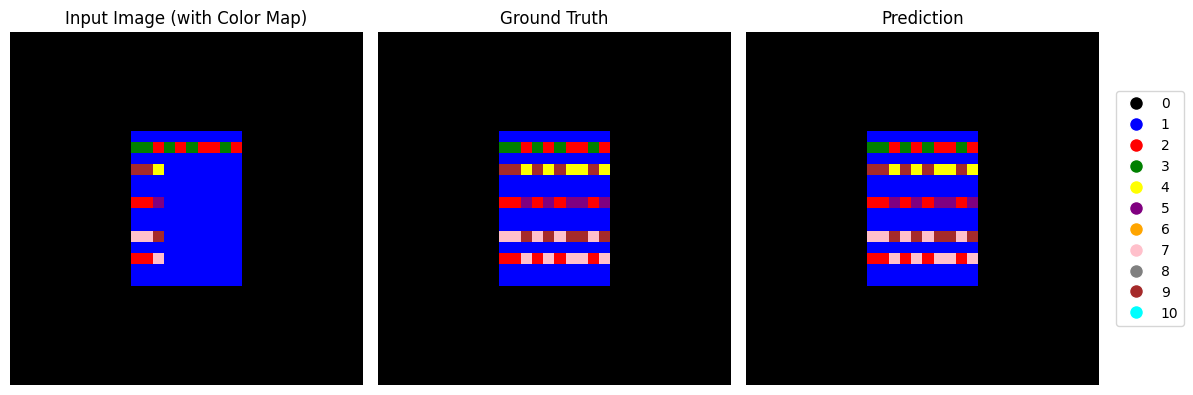

Test Average Loss: 11.639802
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.66%




Epoch [552/1000] Complete
Average Loss: 0.026943
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.02%



Test Average Loss: 10.124411
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.48%




Epoch [553/1000] Complete
Average Loss: 0.020641
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.26%



Test Average Loss: 11.185565
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.28%




Epoch [554/1000] Complete
Average Loss: 0.012972
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 10.660228
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.77%




Epoch [555/1000] Complete
Average Loss: 0.007521
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



Test Average Loss: 10.156818
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.96%




Epoch [556/1000] Complete
Average Loss: 0.005838
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 10.375522
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.81%




Epoch [557/1000] Complete
Average Loss: 0.008164
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.84%



Test Average Loss: 12.019543
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.70%




Epoch [558/1000] Complete
Average Loss: 0.003709
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 12.349213
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.57%




Epoch [559/1000] Complete
Average Loss: 0.003100
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 11.781437
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.31%




Epoch [560/1000] Complete
Average Loss: 0.015091
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.44%



Test Average Loss: 10.799991
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.50%



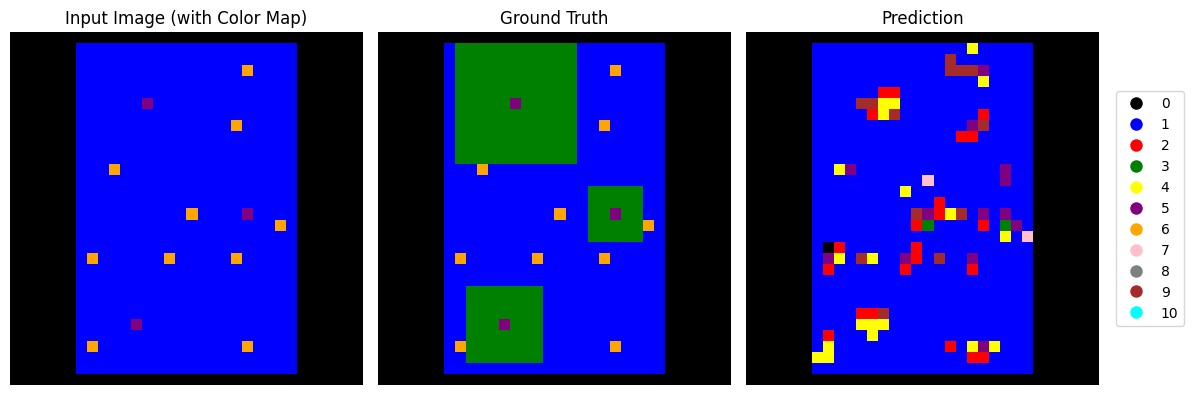


Epoch [561/1000] Complete
Average Loss: 0.009896
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



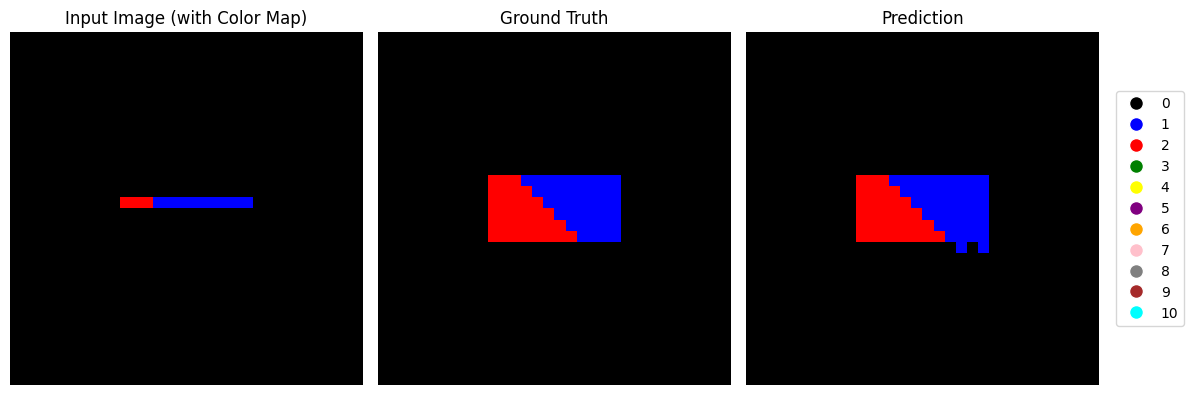

Test Average Loss: 10.767050
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.88%




Epoch [562/1000] Complete
Average Loss: 0.008684
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.66%



Test Average Loss: 11.190318
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.07%




Epoch [563/1000] Complete
Average Loss: 0.004806
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



Test Average Loss: 11.523854
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.61%




Epoch [564/1000] Complete
Average Loss: 0.003766
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 11.385244
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.12%




Epoch [565/1000] Complete
Average Loss: 0.002442
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.90%



Test Average Loss: 11.980865
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.64%




Epoch [566/1000] Complete
Average Loss: 0.002926
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 10.885494
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.43%




Epoch [567/1000] Complete
Average Loss: 0.001730
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 11.257012
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.11%




Epoch [568/1000] Complete
Average Loss: 0.002397
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 10.549014
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.91%




Epoch [569/1000] Complete
Average Loss: 0.003794
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 9.936604
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.93%




Epoch [570/1000] Complete
Average Loss: 0.007017
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 11.015679
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.68%



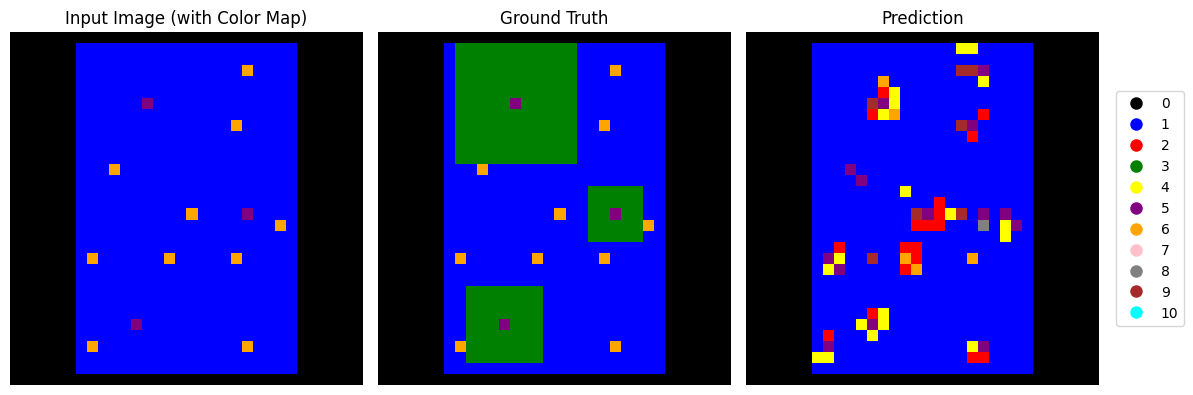


Epoch [571/1000] Complete
Average Loss: 0.005571
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



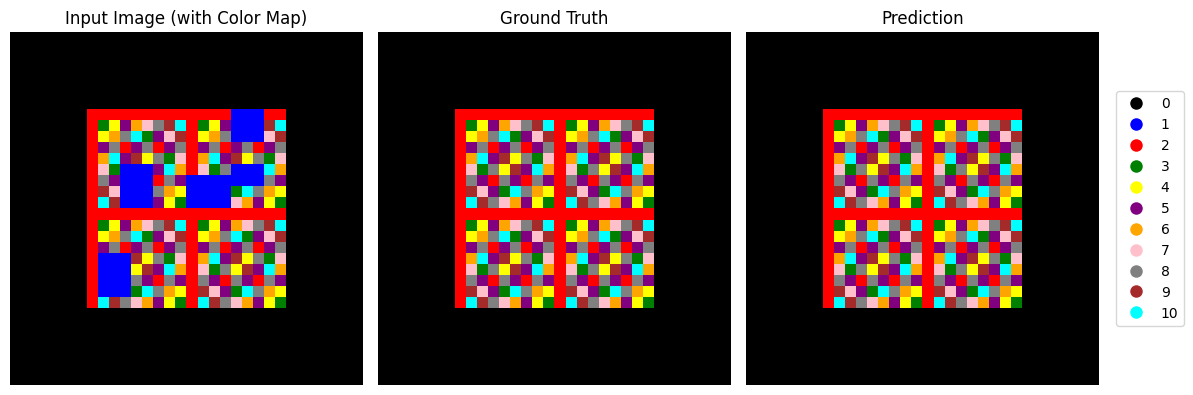

Test Average Loss: 11.799926
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.91%




Epoch [572/1000] Complete
Average Loss: 0.004737
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 11.147916
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.54%




Epoch [573/1000] Complete
Average Loss: 0.003874
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 10.829528
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.83%




Epoch [574/1000] Complete
Average Loss: 0.008245
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 12.363093
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.45%




Epoch [575/1000] Complete
Average Loss: 0.010375
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 11.808485
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.66%




Epoch [576/1000] Complete
Average Loss: 0.009028
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.66%



Test Average Loss: 12.803184
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.02%




Epoch [577/1000] Complete
Average Loss: 0.006009
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 12.493587
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.93%




Epoch [578/1000] Complete
Average Loss: 0.003940
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 11.970707
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.49%




Epoch [579/1000] Complete
Average Loss: 0.003608
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 12.459981
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.14%




Epoch [580/1000] Complete
Average Loss: 0.005387
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



Test Average Loss: 13.498546
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.31%



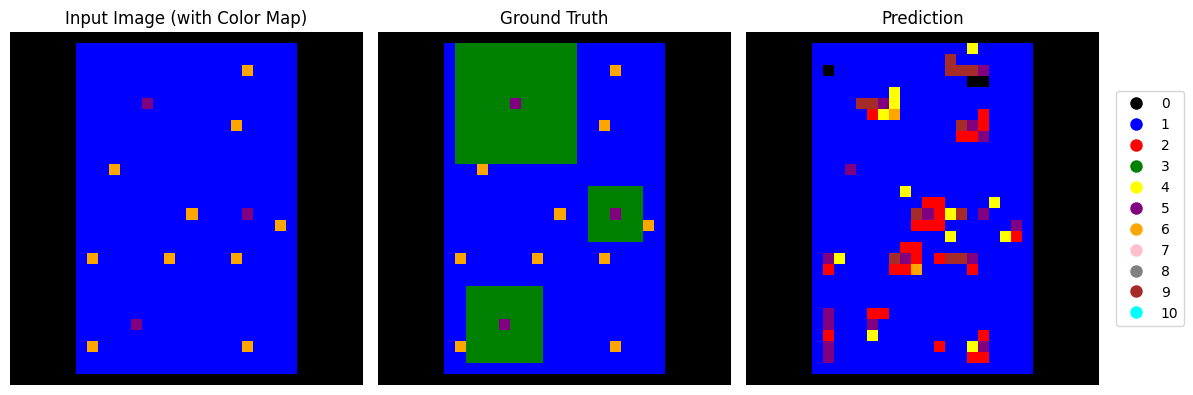


Epoch [581/1000] Complete
Average Loss: 0.003792
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



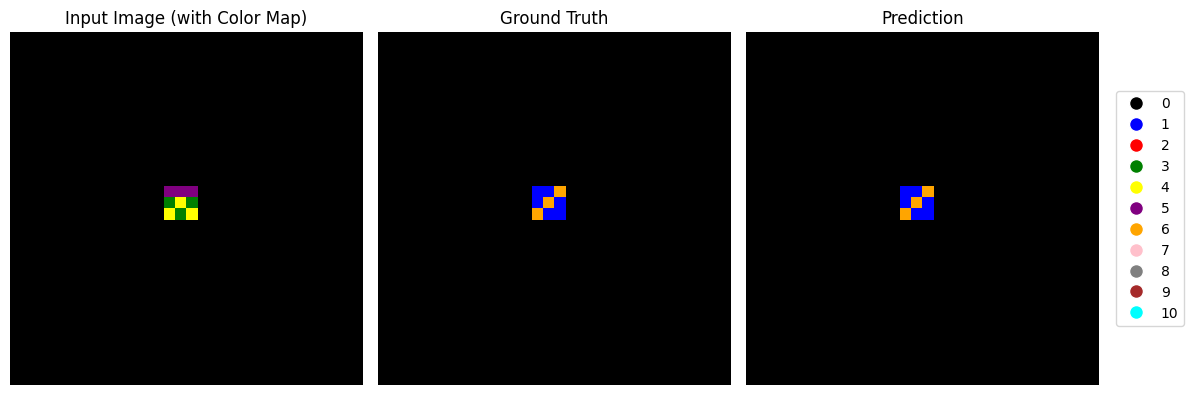

Test Average Loss: 12.212455
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.51%




Epoch [582/1000] Complete
Average Loss: 0.002399
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 12.765721
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.94%




Epoch [583/1000] Complete
Average Loss: 0.001321
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 12.866011
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.70%




Epoch [584/1000] Complete
Average Loss: 0.002817
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 12.578910
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.13%




Epoch [585/1000] Complete
Average Loss: 0.003654
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 12.298770
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.38%




Epoch [586/1000] Complete
Average Loss: 0.003326
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 12.322272
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.64%




Epoch [587/1000] Complete
Average Loss: 0.002016
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 12.661507
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.42%




Epoch [588/1000] Complete
Average Loss: 0.002809
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 12.926741
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.59%




Epoch [589/1000] Complete
Average Loss: 0.007630
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



Test Average Loss: 13.677183
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.03%




Epoch [590/1000] Complete
Average Loss: 0.009919
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 10.958777
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.23%



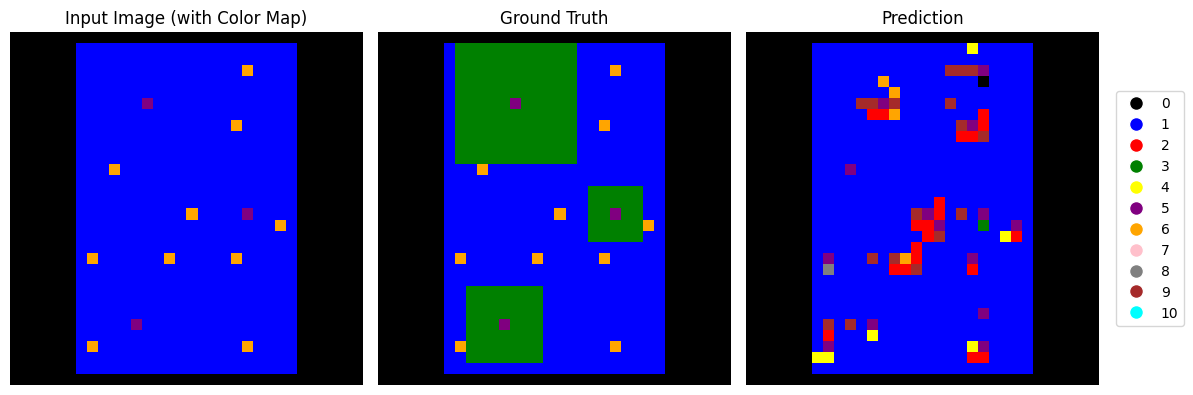


Epoch [591/1000] Complete
Average Loss: 0.016206
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.43%



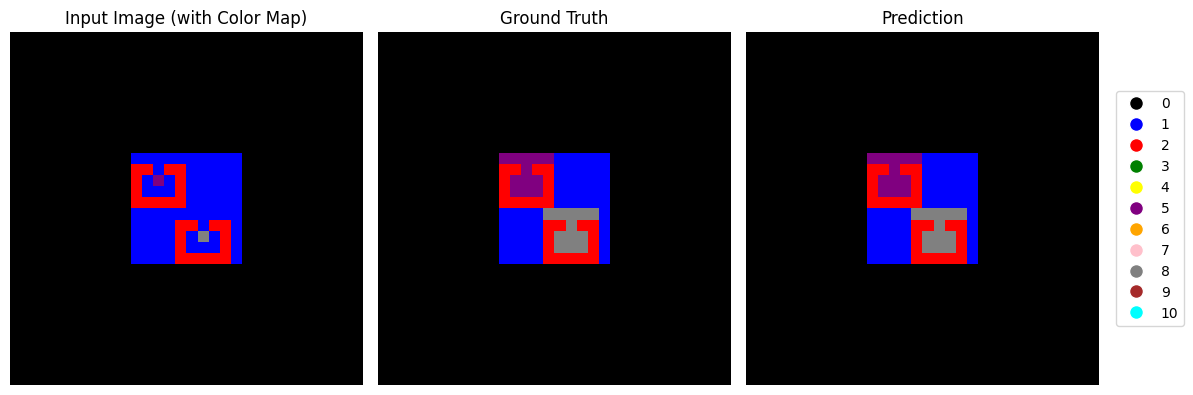

Test Average Loss: 10.118279
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.82%




Epoch [592/1000] Complete
Average Loss: 0.011182
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.60%



Test Average Loss: 10.575560
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.23%




Epoch [593/1000] Complete
Average Loss: 0.010359
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.61%



Test Average Loss: 11.457591
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.58%




Epoch [594/1000] Complete
Average Loss: 0.017801
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.38%



Test Average Loss: 10.460202
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.14%




Epoch [595/1000] Complete
Average Loss: 0.038706
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.48%



Test Average Loss: 11.317703
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.39%




Epoch [596/1000] Complete
Average Loss: 0.047702
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.17%



Test Average Loss: 10.099203
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.41%




Epoch [597/1000] Complete
Average Loss: 0.058431
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.21%



Test Average Loss: 10.427670
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.08%




Epoch [598/1000] Complete
Average Loss: 0.025492
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.96%



Test Average Loss: 10.439531
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.71%




Epoch [599/1000] Complete
Average Loss: 0.014314
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.50%



Test Average Loss: 10.384571
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.98%




Epoch [600/1000] Complete
Average Loss: 0.007966
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.73%



Test Average Loss: 11.518428
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.28%



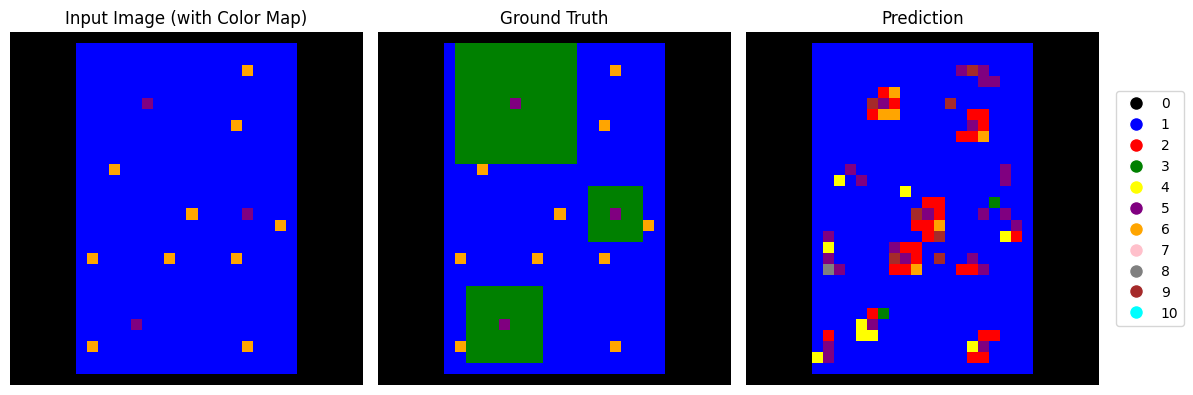


Epoch [601/1000] Complete
Average Loss: 0.006402
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.78%



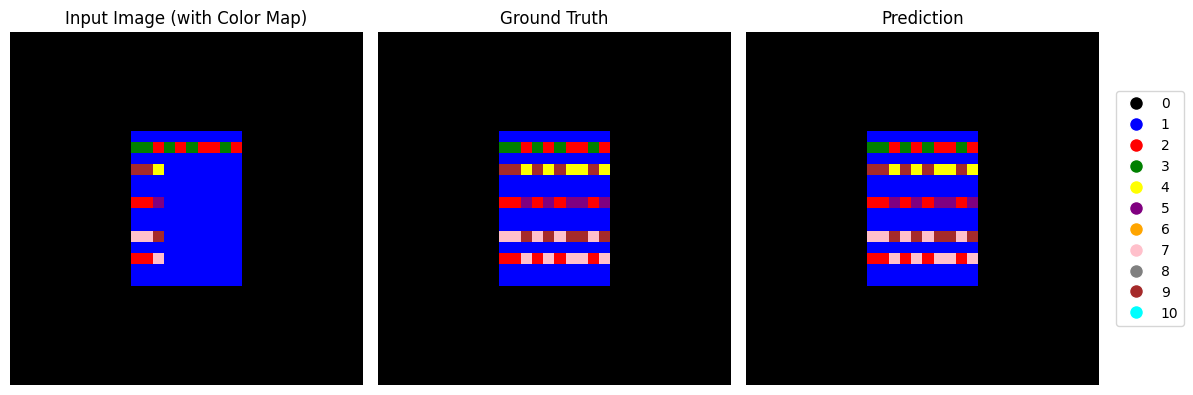

Test Average Loss: 11.967920
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.96%




Epoch [602/1000] Complete
Average Loss: 0.004877
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.84%



Test Average Loss: 12.824267
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [603/1000] Complete
Average Loss: 0.004753
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 11.992783
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.76%




Epoch [604/1000] Complete
Average Loss: 0.003620
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 12.749020
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.83%




Epoch [605/1000] Complete
Average Loss: 0.004361
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 14.145210
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.61%




Epoch [606/1000] Complete
Average Loss: 0.112302
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.24%



Test Average Loss: 9.920388
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 47.82%




Epoch [607/1000] Complete
Average Loss: 0.265050
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 91.32%



Test Average Loss: 15.097710
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.28%




Epoch [608/1000] Complete
Average Loss: 0.086266
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 96.82%



Test Average Loss: 10.907136
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.40%




Epoch [609/1000] Complete
Average Loss: 0.051183
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.42%



Test Average Loss: 11.941150
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.63%




Epoch [610/1000] Complete
Average Loss: 0.017269
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.43%



Test Average Loss: 12.132937
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.64%



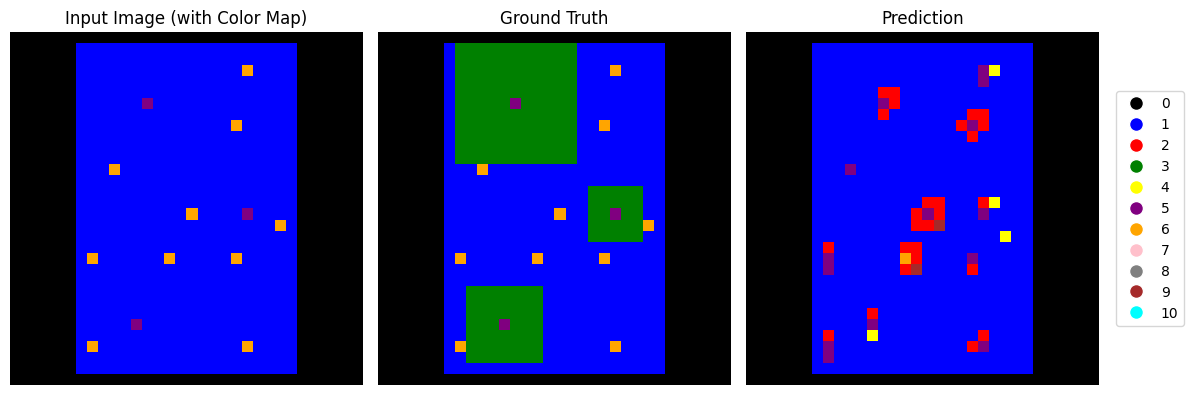


Epoch [611/1000] Complete
Average Loss: 0.008426
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



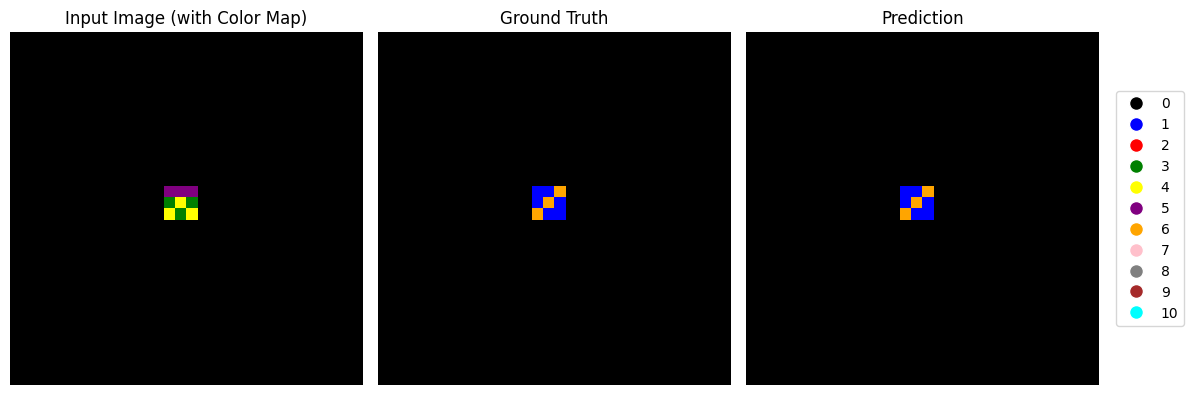

Test Average Loss: 12.764146
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.77%




Epoch [612/1000] Complete
Average Loss: 0.005851
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



Test Average Loss: 13.702026
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.88%




Epoch [613/1000] Complete
Average Loss: 0.003966
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 14.858345
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.81%




Epoch [614/1000] Complete
Average Loss: 0.003656
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 13.888590
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.66%




Epoch [615/1000] Complete
Average Loss: 0.002565
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 15.001516
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.28%




Epoch [616/1000] Complete
Average Loss: 0.002764
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 14.965636
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.42%




Epoch [617/1000] Complete
Average Loss: 0.002443
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 15.077704
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.55%




Epoch [618/1000] Complete
Average Loss: 0.001573
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 15.696148
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.45%




Epoch [619/1000] Complete
Average Loss: 0.001453
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 16.250730
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.55%




Epoch [620/1000] Complete
Average Loss: 0.001197
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 16.257650
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.90%



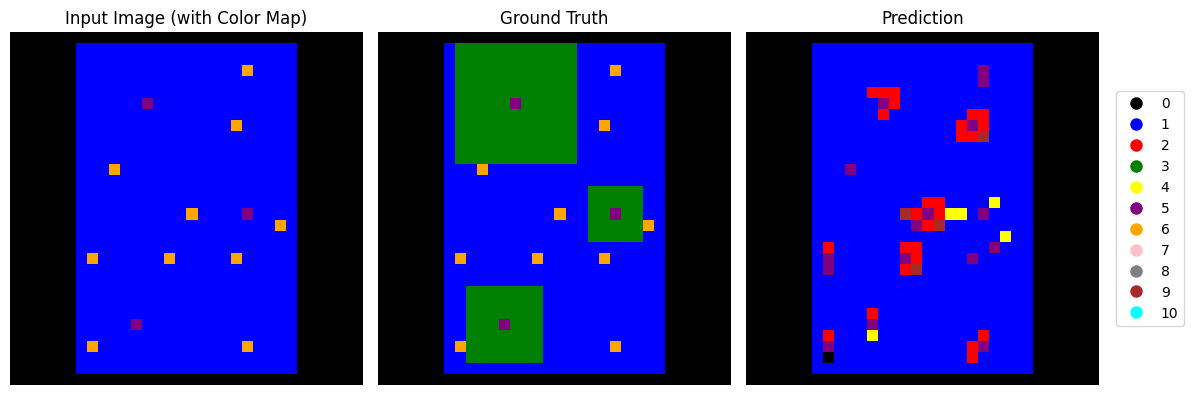


Epoch [621/1000] Complete
Average Loss: 0.001034
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



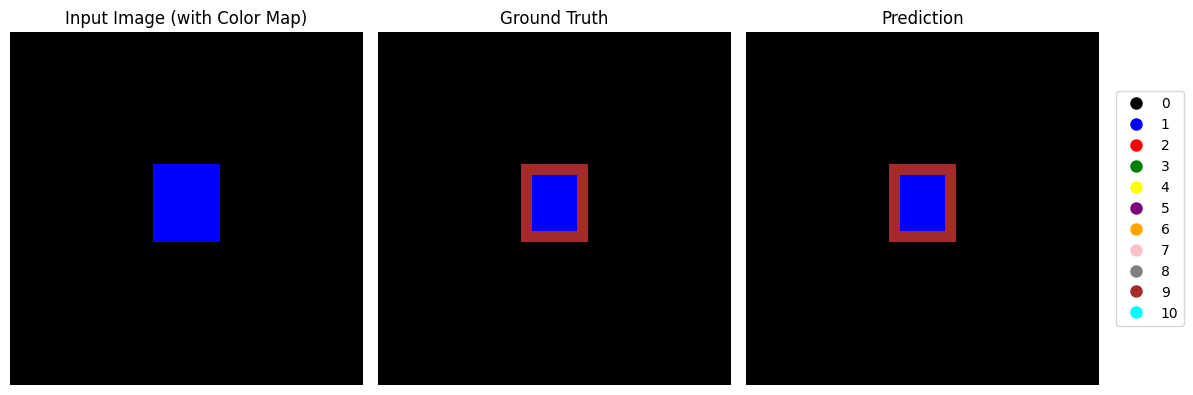

Test Average Loss: 16.348233
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.07%




Epoch [622/1000] Complete
Average Loss: 0.001298
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 16.694574
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.65%




Epoch [623/1000] Complete
Average Loss: 0.001147
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 16.855952
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.57%




Epoch [624/1000] Complete
Average Loss: 0.001182
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 16.670224
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.91%




Epoch [625/1000] Complete
Average Loss: 0.000916
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 17.043247
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.81%




Epoch [626/1000] Complete
Average Loss: 0.000901
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 16.974700
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.18%




Epoch [627/1000] Complete
Average Loss: 0.002916
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 17.538769
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.84%




Epoch [628/1000] Complete
Average Loss: 0.002250
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 17.220865
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.02%




Epoch [629/1000] Complete
Average Loss: 0.002250
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 17.447532
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.77%




Epoch [630/1000] Complete
Average Loss: 0.003110
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.89%



Test Average Loss: 16.795696
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.36%



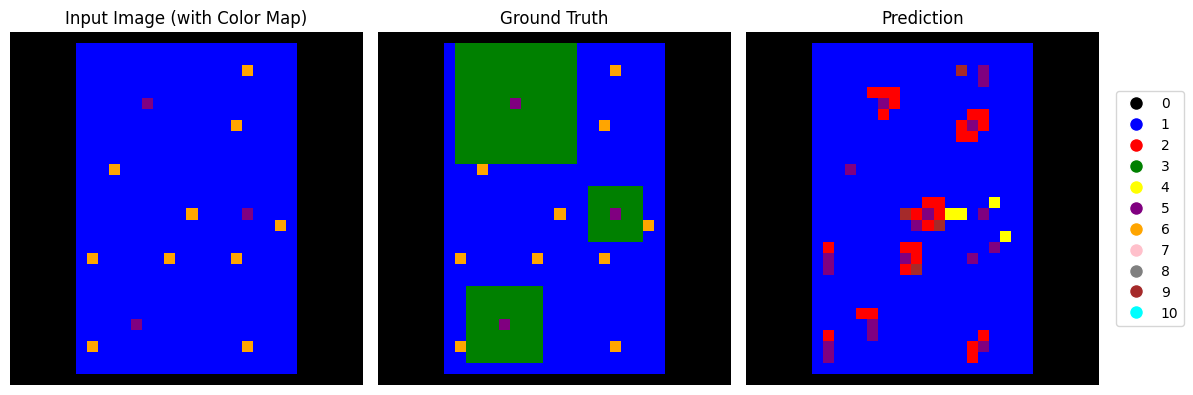


Epoch [631/1000] Complete
Average Loss: 0.006182
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



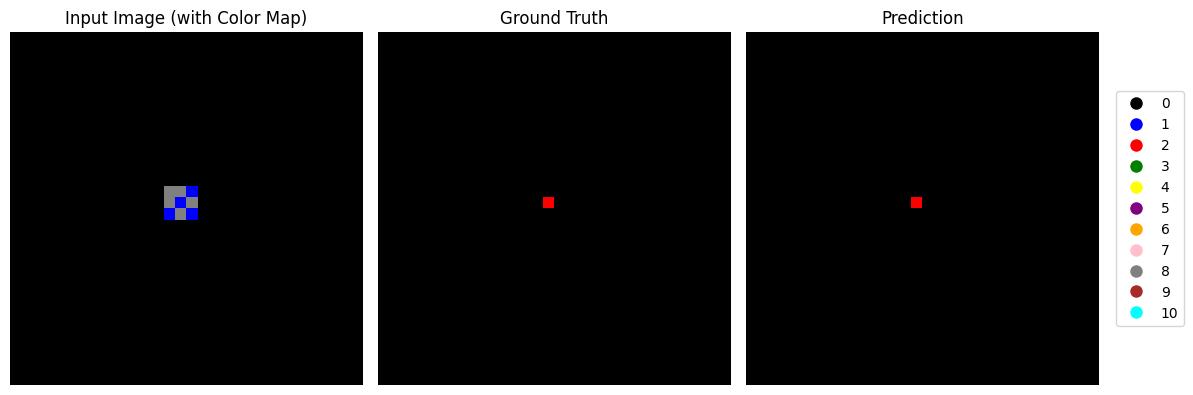

Test Average Loss: 15.354650
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.51%




Epoch [632/1000] Complete
Average Loss: 0.007161
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.74%



Test Average Loss: 15.446145
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.11%




Epoch [633/1000] Complete
Average Loss: 0.009361
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 13.827169
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.82%




Epoch [634/1000] Complete
Average Loss: 0.027183
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.05%



Test Average Loss: 12.751822
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.17%




Epoch [635/1000] Complete
Average Loss: 0.027174
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.02%



Test Average Loss: 12.374978
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.65%




Epoch [636/1000] Complete
Average Loss: 0.012746
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.51%



Test Average Loss: 12.453288
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.29%




Epoch [637/1000] Complete
Average Loss: 0.009291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.70%



Test Average Loss: 13.148724
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.39%




Epoch [638/1000] Complete
Average Loss: 0.008102
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.72%



Test Average Loss: 13.787235
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.10%




Epoch [639/1000] Complete
Average Loss: 0.009703
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.69%



Test Average Loss: 11.152412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.01%




Epoch [640/1000] Complete
Average Loss: 0.005569
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 13.188965
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.17%



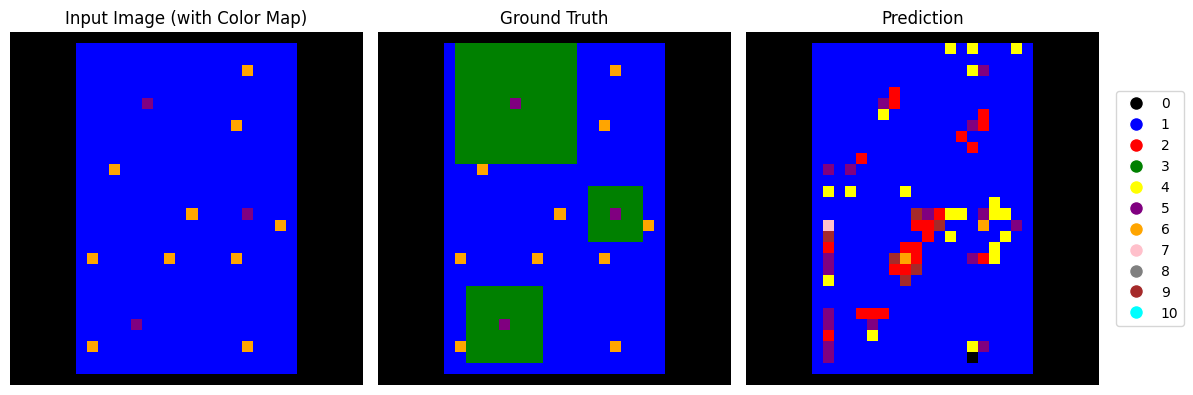


Epoch [641/1000] Complete
Average Loss: 0.004879
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.83%



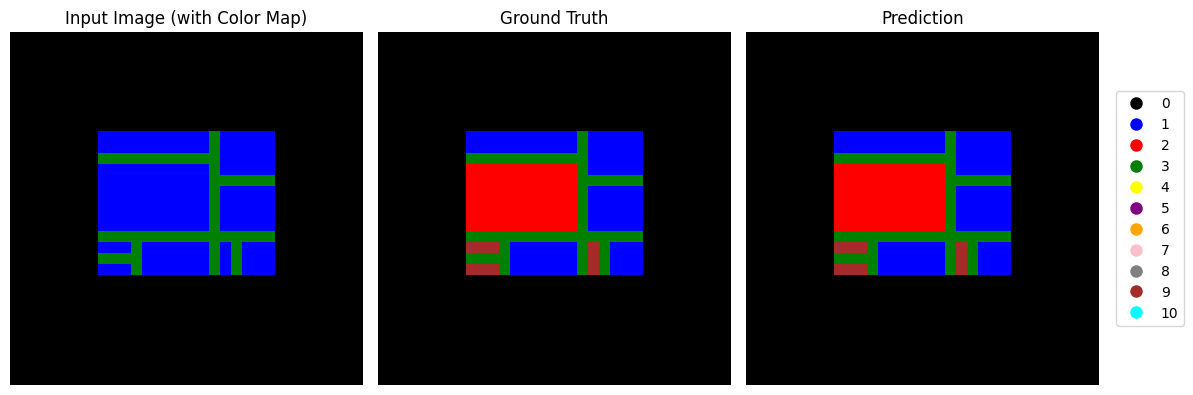

Test Average Loss: 13.922240
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.22%




Epoch [642/1000] Complete
Average Loss: 0.005165
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 13.298571
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.86%




Epoch [643/1000] Complete
Average Loss: 0.004083
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 14.281617
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.21%




Epoch [644/1000] Complete
Average Loss: 0.003811
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.90%



Test Average Loss: 15.209334
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.99%




Epoch [645/1000] Complete
Average Loss: 0.001509
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 15.903118
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.11%




Epoch [646/1000] Complete
Average Loss: 0.002057
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 14.755699
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.65%




Epoch [647/1000] Complete
Average Loss: 0.005592
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 15.110138
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.85%




Epoch [648/1000] Complete
Average Loss: 0.039330
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.55%



Test Average Loss: 14.385403
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.40%




Epoch [649/1000] Complete
Average Loss: 0.028291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.97%



Test Average Loss: 11.543434
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.13%




Epoch [650/1000] Complete
Average Loss: 0.015844
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.44%



Test Average Loss: 11.788513
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.50%



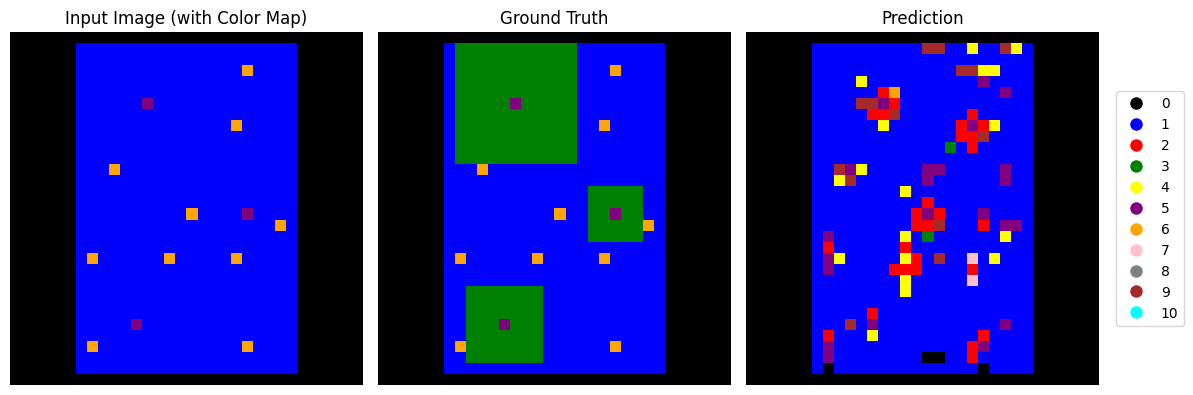


Epoch [651/1000] Complete
Average Loss: 0.040363
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.73%



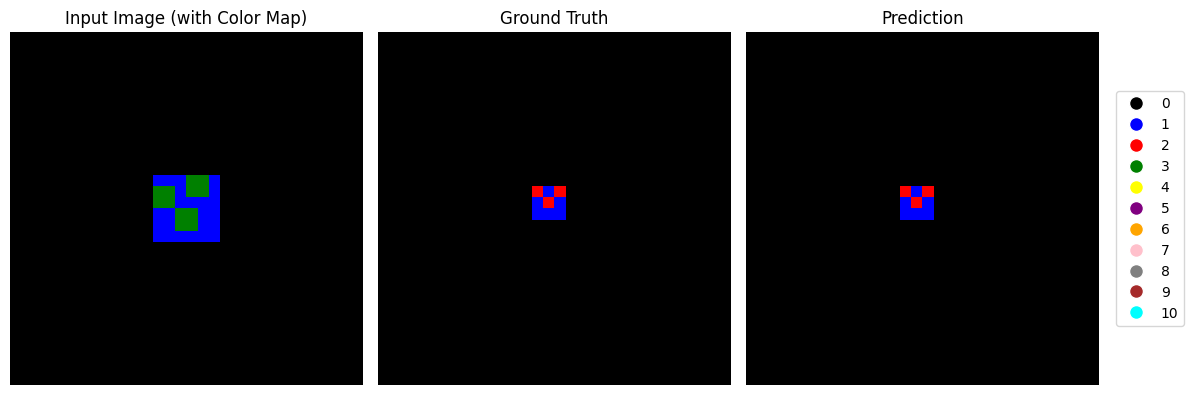

Test Average Loss: 9.695177
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.47%




Epoch [652/1000] Complete
Average Loss: 0.038939
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.57%



Test Average Loss: 10.809873
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.18%




Epoch [653/1000] Complete
Average Loss: 0.016469
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.34%



Test Average Loss: 9.668817
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.24%




Epoch [654/1000] Complete
Average Loss: 0.019203
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.30%



Test Average Loss: 11.375012
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.85%




Epoch [655/1000] Complete
Average Loss: 0.013467
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 12.083840
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.54%




Epoch [656/1000] Complete
Average Loss: 0.006135
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.76%



Test Average Loss: 13.167652
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.88%




Epoch [657/1000] Complete
Average Loss: 0.005688
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.78%



Test Average Loss: 12.929542
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.36%




Epoch [658/1000] Complete
Average Loss: 0.004150
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 12.812061
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [659/1000] Complete
Average Loss: 0.002636
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 12.864086
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.10%




Epoch [660/1000] Complete
Average Loss: 0.002056
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 14.295579
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.62%



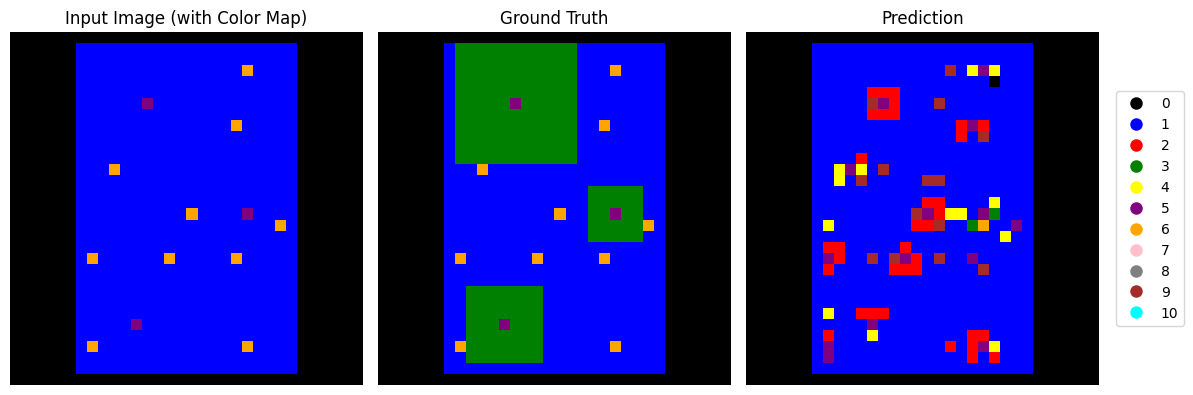


Epoch [661/1000] Complete
Average Loss: 0.004273
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



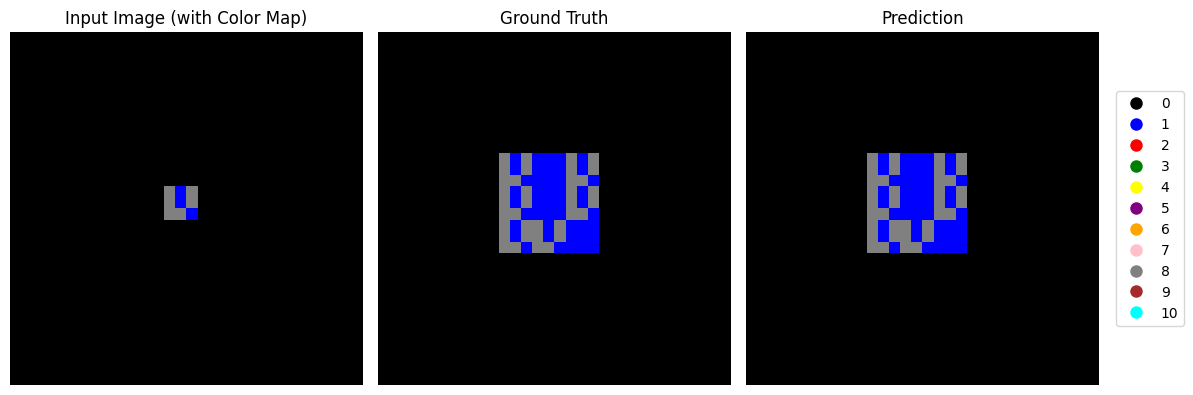

Test Average Loss: 15.977897
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.90%




Epoch [662/1000] Complete
Average Loss: 0.003371
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 16.075874
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.03%




Epoch [663/1000] Complete
Average Loss: 0.003888
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



Test Average Loss: 13.504761
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.71%




Epoch [664/1000] Complete
Average Loss: 0.005911
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



Test Average Loss: 13.762845
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.29%




Epoch [665/1000] Complete
Average Loss: 0.004574
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.86%



Test Average Loss: 13.492326
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [666/1000] Complete
Average Loss: 0.003734
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 12.786472
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.15%




Epoch [667/1000] Complete
Average Loss: 0.002843
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.90%



Test Average Loss: 13.758017
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.32%




Epoch [668/1000] Complete
Average Loss: 0.002813
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 13.139658
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [669/1000] Complete
Average Loss: 0.002452
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 13.547124
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.01%




Epoch [670/1000] Complete
Average Loss: 0.002259
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 13.735969
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.01%



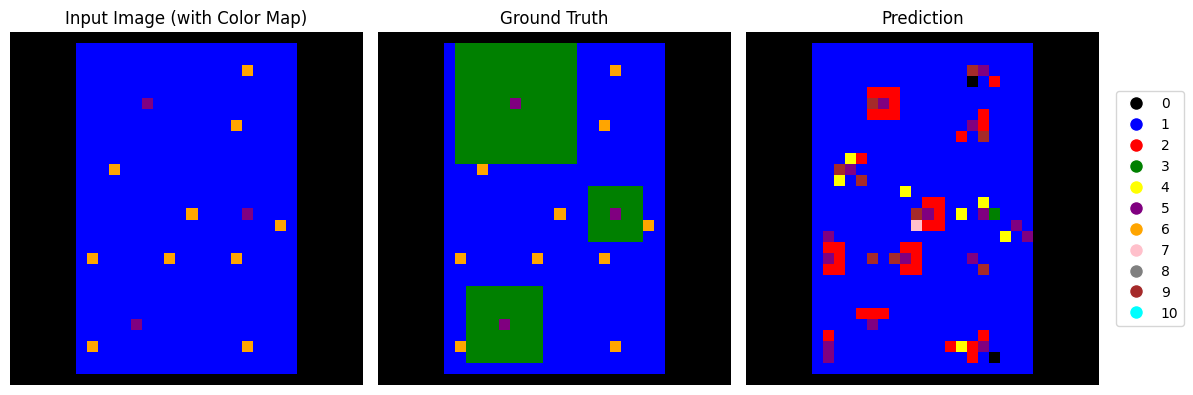


Epoch [671/1000] Complete
Average Loss: 0.001676
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



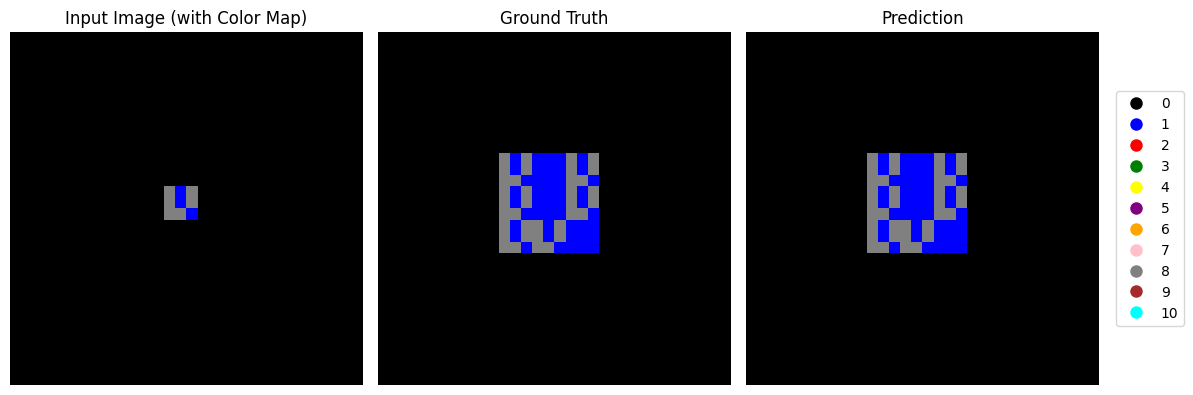

Test Average Loss: 13.971287
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.63%




Epoch [672/1000] Complete
Average Loss: 0.001149
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 14.574305
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.41%




Epoch [673/1000] Complete
Average Loss: 0.002297
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 13.457886
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.19%




Epoch [674/1000] Complete
Average Loss: 0.003506
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 14.249163
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.50%




Epoch [675/1000] Complete
Average Loss: 0.004883
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 13.296011
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.69%




Epoch [676/1000] Complete
Average Loss: 0.005232
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 11.410525
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.91%




Epoch [677/1000] Complete
Average Loss: 0.005495
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.81%



Test Average Loss: 12.886410
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.90%




Epoch [678/1000] Complete
Average Loss: 0.010589
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 14.164966
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.80%




Epoch [679/1000] Complete
Average Loss: 0.015818
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.48%



Test Average Loss: 12.102354
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.40%




Epoch [680/1000] Complete
Average Loss: 0.155697
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.31%



Test Average Loss: 9.608393
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.41%



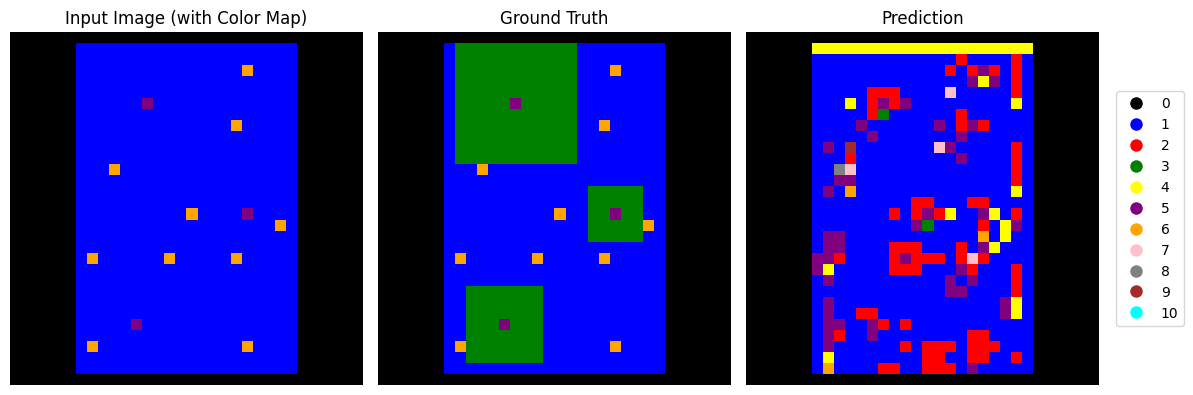


Epoch [681/1000] Complete
Average Loss: 0.196921
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.75%



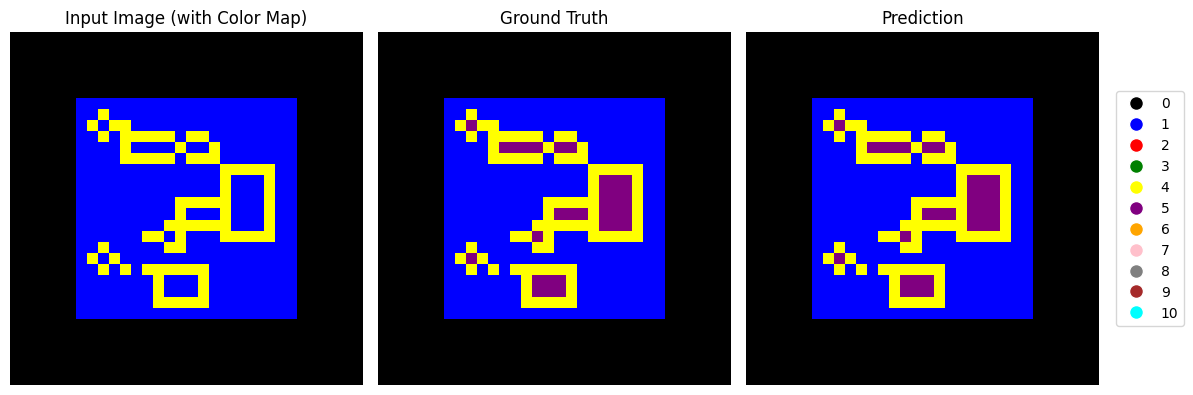

Test Average Loss: 9.094289
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.64%




Epoch [682/1000] Complete
Average Loss: 0.287206
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 89.68%



Test Average Loss: 10.271366
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 48.66%




Epoch [683/1000] Complete
Average Loss: 0.156459
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.98%



Test Average Loss: 9.896224
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.00%




Epoch [684/1000] Complete
Average Loss: 0.068046
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.79%



Test Average Loss: 12.192053
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 57.63%




Epoch [685/1000] Complete
Average Loss: 0.029681
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.87%



Test Average Loss: 9.542247
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.70%




Epoch [686/1000] Complete
Average Loss: 0.009937
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 9.394412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.46%




Epoch [687/1000] Complete
Average Loss: 0.006027
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 9.132181
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.75%




Epoch [688/1000] Complete
Average Loss: 0.007605
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 9.010603
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.82%




Epoch [689/1000] Complete
Average Loss: 0.008623
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.79%



Test Average Loss: 10.232082
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.82%




Epoch [690/1000] Complete
Average Loss: 0.003444
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.90%



Test Average Loss: 11.230123
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.32%



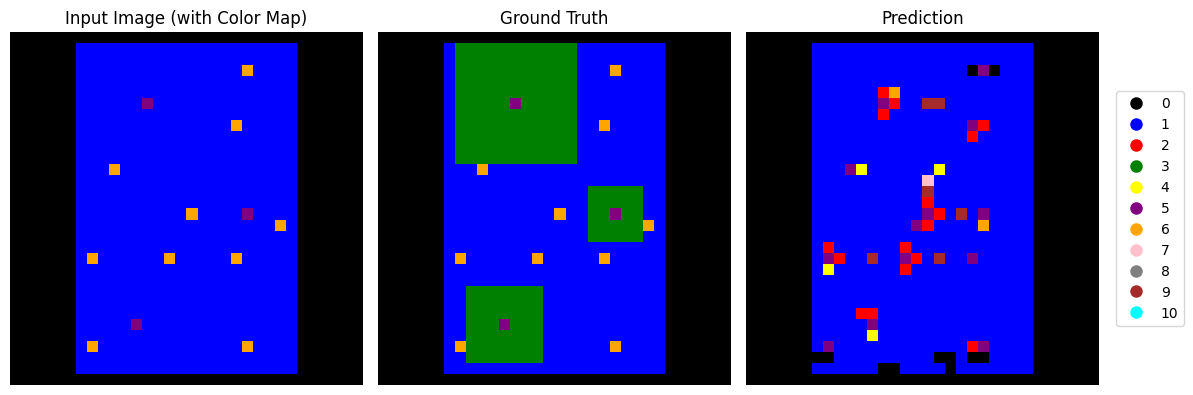


Epoch [691/1000] Complete
Average Loss: 0.001657
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



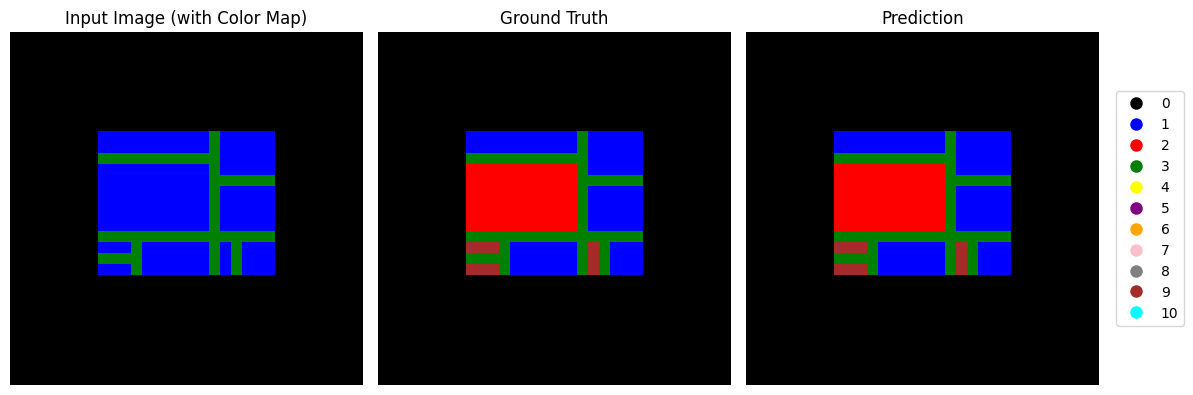

Test Average Loss: 11.326067
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.76%




Epoch [692/1000] Complete
Average Loss: 0.001285
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 11.885869
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.12%




Epoch [693/1000] Complete
Average Loss: 0.001040
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 11.632459
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.85%




Epoch [694/1000] Complete
Average Loss: 0.001234
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 12.150387
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.97%




Epoch [695/1000] Complete
Average Loss: 0.001154
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 12.538986
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.05%




Epoch [696/1000] Complete
Average Loss: 0.000839
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 12.400449
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.19%




Epoch [697/1000] Complete
Average Loss: 0.000705
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 12.435446
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.92%




Epoch [698/1000] Complete
Average Loss: 0.000674
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 12.264533
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.35%




Epoch [699/1000] Complete
Average Loss: 0.000800
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 12.539564
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.72%




Epoch [700/1000] Complete
Average Loss: 0.001005
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 12.408325
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.23%



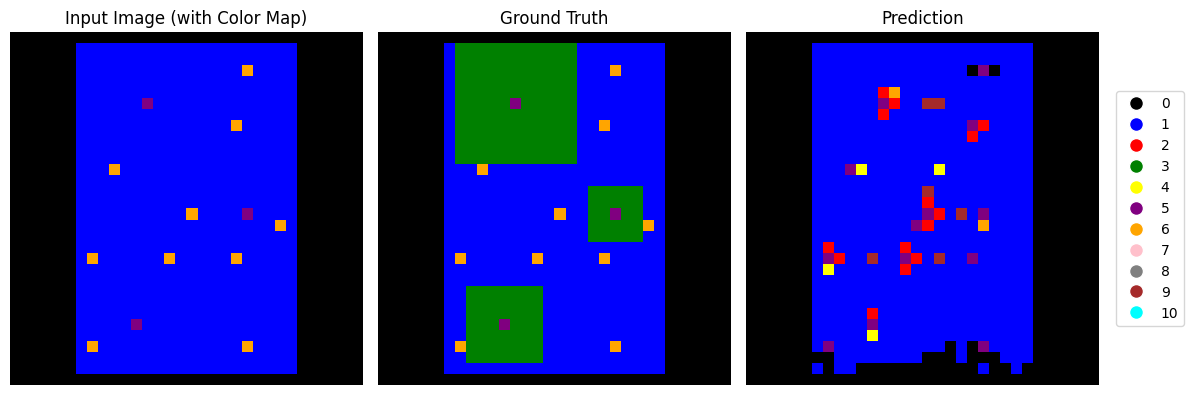


Epoch [701/1000] Complete
Average Loss: 0.001146
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



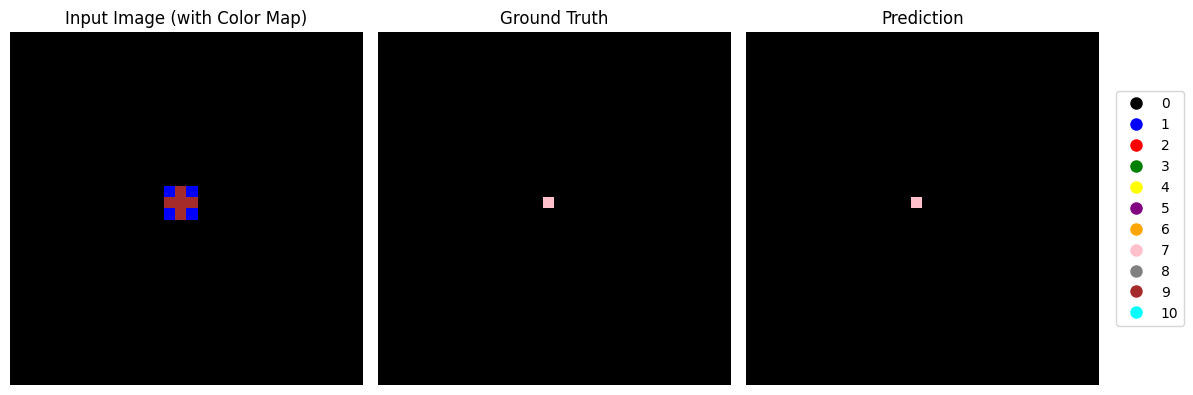

Test Average Loss: 12.928675
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.02%




Epoch [702/1000] Complete
Average Loss: 0.000824
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 13.209508
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.97%




Epoch [703/1000] Complete
Average Loss: 0.000546
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 12.923730
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.16%




Epoch [704/1000] Complete
Average Loss: 0.000419
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 12.655265
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.14%




Epoch [705/1000] Complete
Average Loss: 0.000517
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 12.673175
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.10%




Epoch [706/1000] Complete
Average Loss: 0.000493
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 12.318515
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.17%




Epoch [707/1000] Complete
Average Loss: 0.000629
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.185508
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.02%




Epoch [708/1000] Complete
Average Loss: 0.000531
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.078186
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.10%




Epoch [709/1000] Complete
Average Loss: 0.000621
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.128799
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.01%




Epoch [710/1000] Complete
Average Loss: 0.000693
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.131615
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.31%



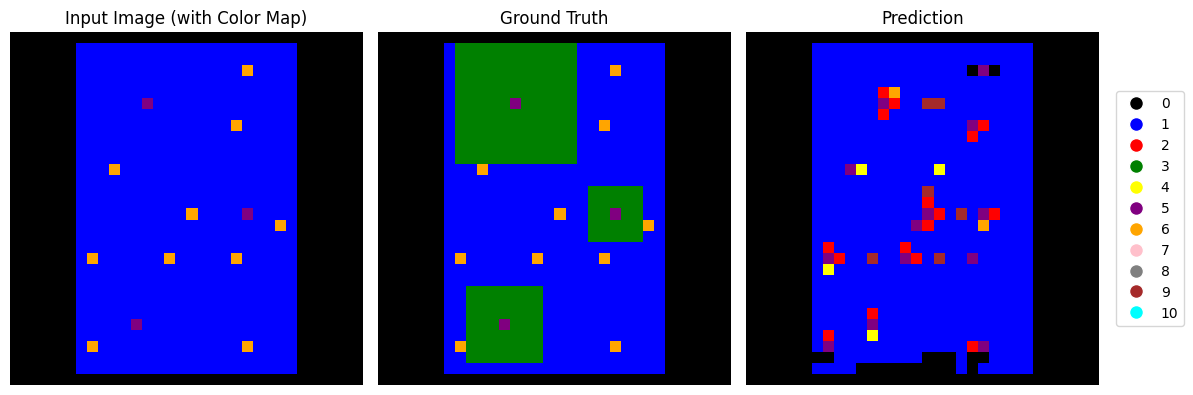


Epoch [711/1000] Complete
Average Loss: 0.000410
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



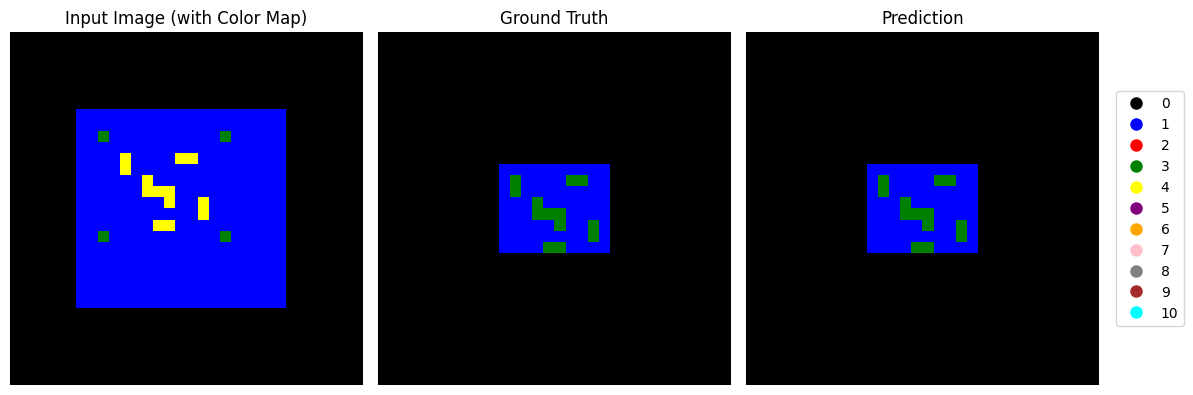

Test Average Loss: 13.345681
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.18%




Epoch [712/1000] Complete
Average Loss: 0.000372
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 13.139701
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.28%




Epoch [713/1000] Complete
Average Loss: 0.000314
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 13.148293
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.16%




Epoch [714/1000] Complete
Average Loss: 0.000289
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 12.571107
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.63%




Epoch [715/1000] Complete
Average Loss: 0.000327
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 12.813120
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.02%




Epoch [716/1000] Complete
Average Loss: 0.000294
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 12.708696
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.31%




Epoch [717/1000] Complete
Average Loss: 0.000573
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.016978
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.17%




Epoch [718/1000] Complete
Average Loss: 0.000671
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.827881
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.27%




Epoch [719/1000] Complete
Average Loss: 0.000777
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 12.921471
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 56.05%




Epoch [720/1000] Complete
Average Loss: 0.000815
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 12.460426
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.87%



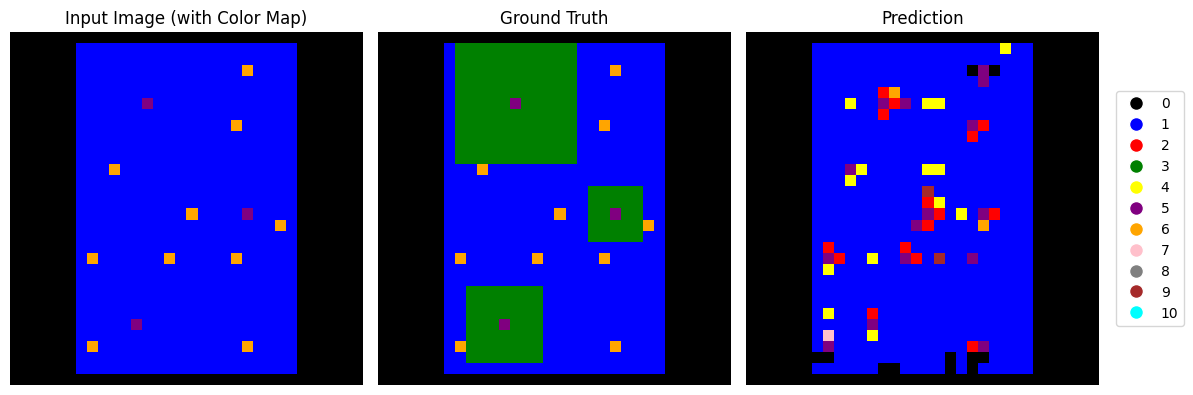


Epoch [721/1000] Complete
Average Loss: 0.002797
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



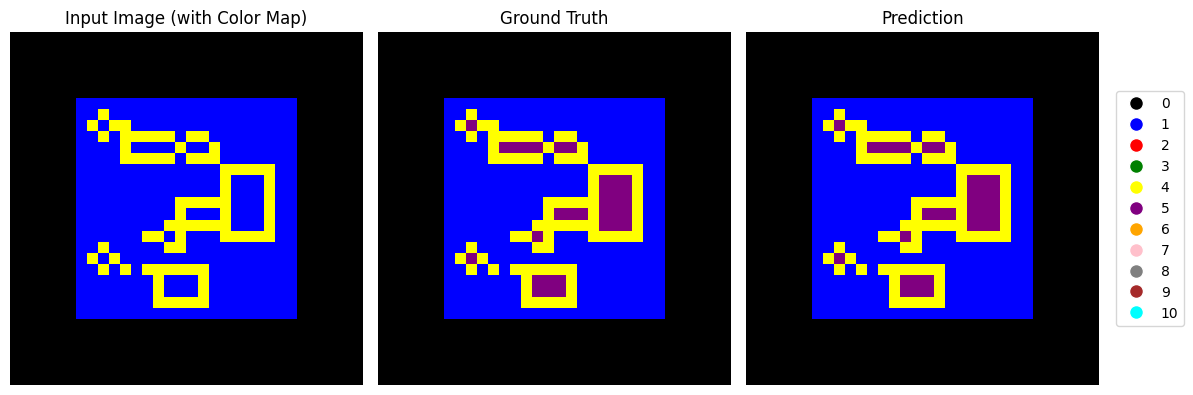

Test Average Loss: 12.015735
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.85%




Epoch [722/1000] Complete
Average Loss: 0.017540
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.38%



Test Average Loss: 9.437702
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.56%




Epoch [723/1000] Complete
Average Loss: 0.022515
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.24%



Test Average Loss: 11.047241
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.71%




Epoch [724/1000] Complete
Average Loss: 0.017443
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.34%



Test Average Loss: 9.516191
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.98%




Epoch [725/1000] Complete
Average Loss: 0.023564
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.18%



Test Average Loss: 9.978473
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.47%




Epoch [726/1000] Complete
Average Loss: 0.021413
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.30%



Test Average Loss: 13.001822
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.91%




Epoch [727/1000] Complete
Average Loss: 0.011638
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.56%



Test Average Loss: 12.441052
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.24%




Epoch [728/1000] Complete
Average Loss: 0.006702
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.77%



Test Average Loss: 12.502696
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.54%




Epoch [729/1000] Complete
Average Loss: 0.006189
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.82%



Test Average Loss: 11.829556
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.22%




Epoch [730/1000] Complete
Average Loss: 0.004662
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 12.028837
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.00%



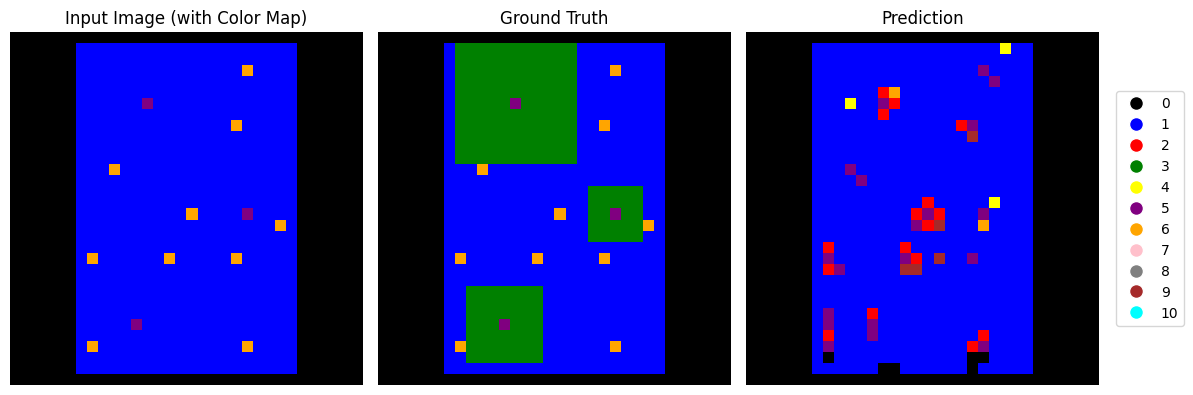


Epoch [731/1000] Complete
Average Loss: 0.004016
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.88%



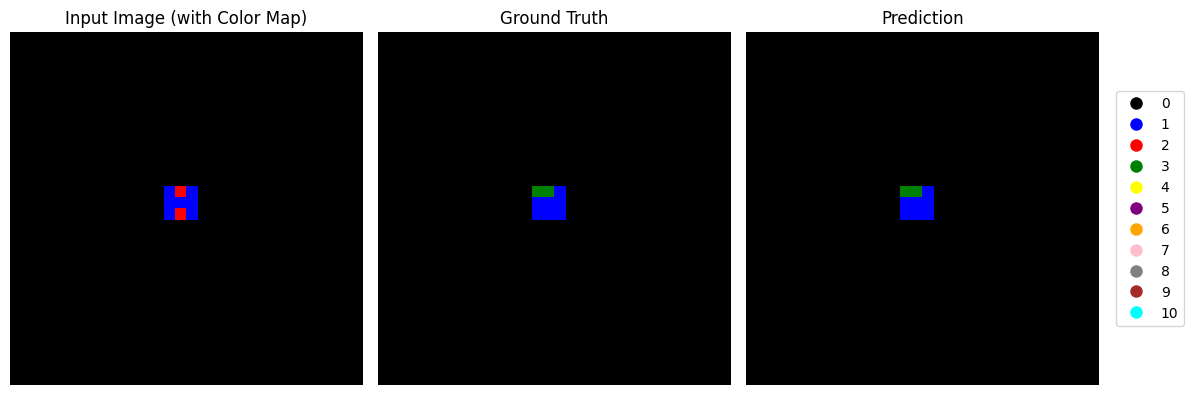

Test Average Loss: 12.140115
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.86%




Epoch [732/1000] Complete
Average Loss: 0.002287
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.91%



Test Average Loss: 12.588862
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.73%




Epoch [733/1000] Complete
Average Loss: 0.001889
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 13.157472
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.31%




Epoch [734/1000] Complete
Average Loss: 0.002147
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.94%



Test Average Loss: 13.521355
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.41%




Epoch [735/1000] Complete
Average Loss: 0.001846
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.92%



Test Average Loss: 14.625983
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.40%




Epoch [736/1000] Complete
Average Loss: 0.006354
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.80%



Test Average Loss: 12.998769
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.53%




Epoch [737/1000] Complete
Average Loss: 0.025868
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.25%



Test Average Loss: 12.905542
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.99%




Epoch [738/1000] Complete
Average Loss: 0.010821
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.59%



Test Average Loss: 12.703436
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.09%




Epoch [739/1000] Complete
Average Loss: 0.012101
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 12.178136
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [740/1000] Complete
Average Loss: 0.015252
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.51%



Test Average Loss: 12.491381
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.10%



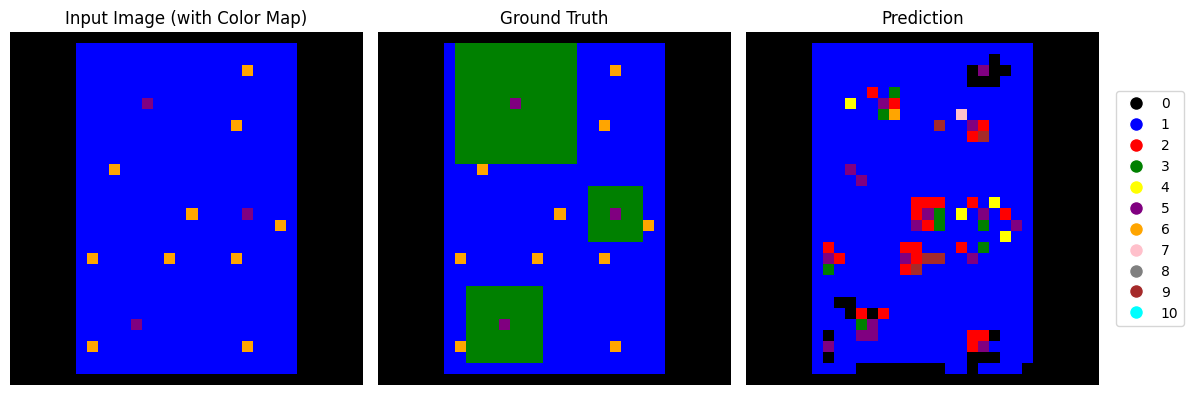


Epoch [741/1000] Complete
Average Loss: 0.014304
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



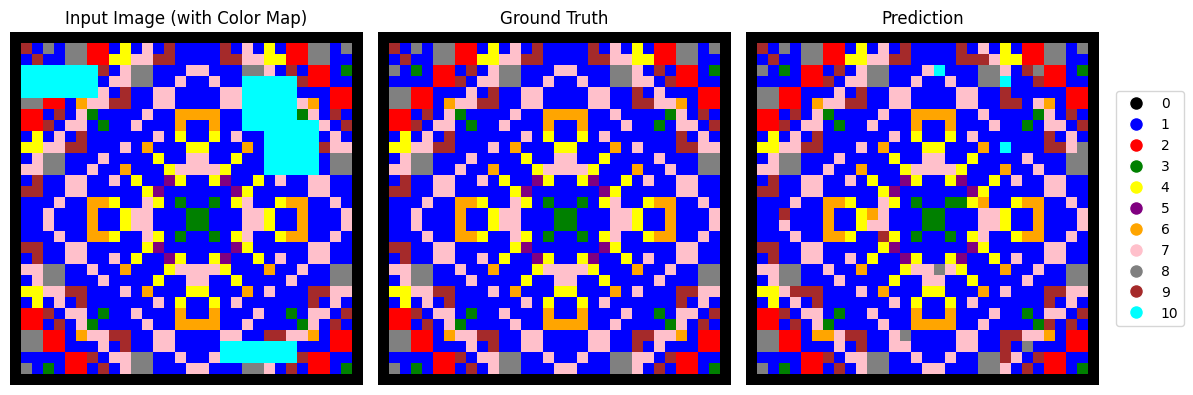

Test Average Loss: 11.083480
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.37%




Epoch [742/1000] Complete
Average Loss: 0.009001
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 10.845201
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.13%




Epoch [743/1000] Complete
Average Loss: 0.008046
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.67%



Test Average Loss: 10.816872
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.57%




Epoch [744/1000] Complete
Average Loss: 0.015057
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.53%



Test Average Loss: 10.240438
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 46.31%




Epoch [745/1000] Complete
Average Loss: 0.017327
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.29%



Test Average Loss: 12.058440
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.79%




Epoch [746/1000] Complete
Average Loss: 0.045741
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.60%



Test Average Loss: 11.108198
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.59%




Epoch [747/1000] Complete
Average Loss: 0.148891
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 94.27%



Test Average Loss: 9.878773
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.23%




Epoch [748/1000] Complete
Average Loss: 0.116142
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.11%



Test Average Loss: 15.804299
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 44.80%




Epoch [749/1000] Complete
Average Loss: 0.232065
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 92.01%



Test Average Loss: 15.944582
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.41%




Epoch [750/1000] Complete
Average Loss: 0.065766
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.55%



Test Average Loss: 11.575758
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.01%



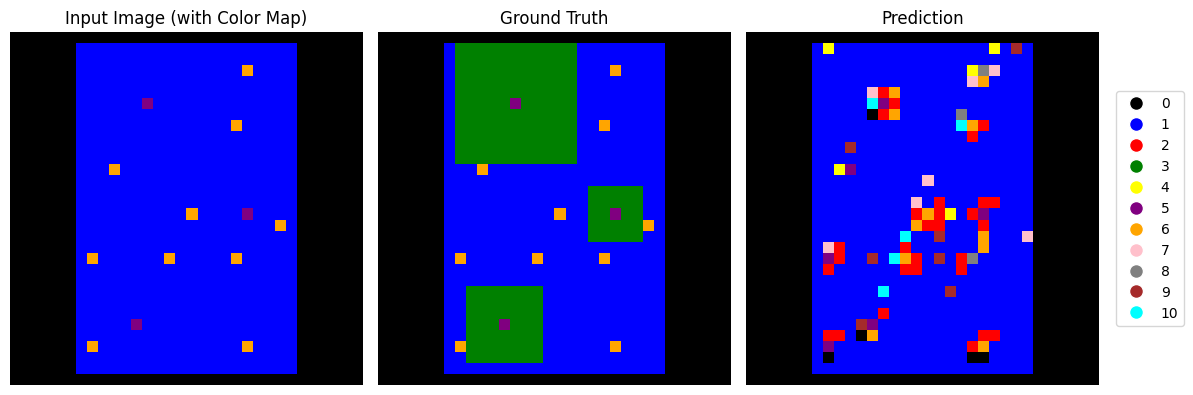


Epoch [751/1000] Complete
Average Loss: 0.024179
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.25%



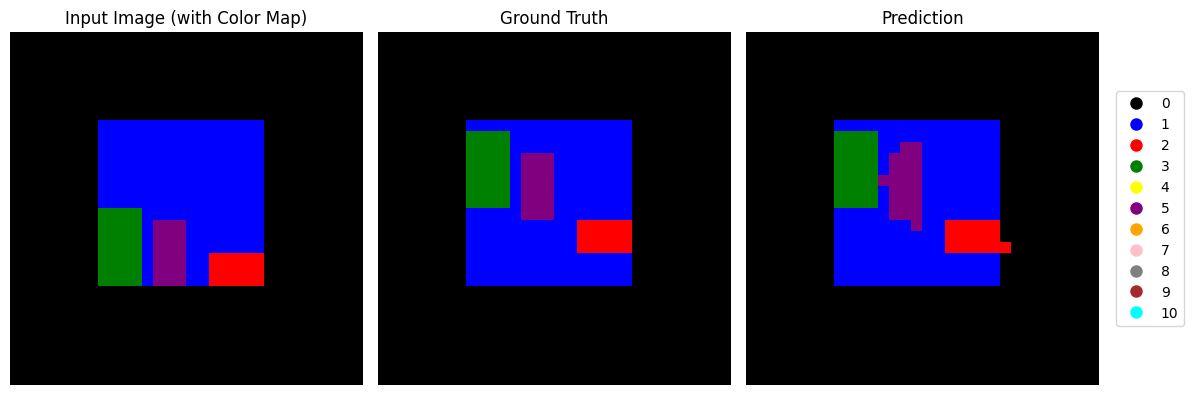

Test Average Loss: 11.424868
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.69%




Epoch [752/1000] Complete
Average Loss: 0.012618
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.57%



Test Average Loss: 11.896370
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.09%




Epoch [753/1000] Complete
Average Loss: 0.003852
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.87%



Test Average Loss: 12.674773
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.70%




Epoch [754/1000] Complete
Average Loss: 0.002190
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 12.485616
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.29%




Epoch [755/1000] Complete
Average Loss: 0.001826
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 12.637947
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.69%




Epoch [756/1000] Complete
Average Loss: 0.002072
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 12.771871
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.35%




Epoch [757/1000] Complete
Average Loss: 0.001238
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 13.681516
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.75%




Epoch [758/1000] Complete
Average Loss: 0.000808
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.385348
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.64%




Epoch [759/1000] Complete
Average Loss: 0.000773
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.404851
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.79%




Epoch [760/1000] Complete
Average Loss: 0.000861
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.863761
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.54%



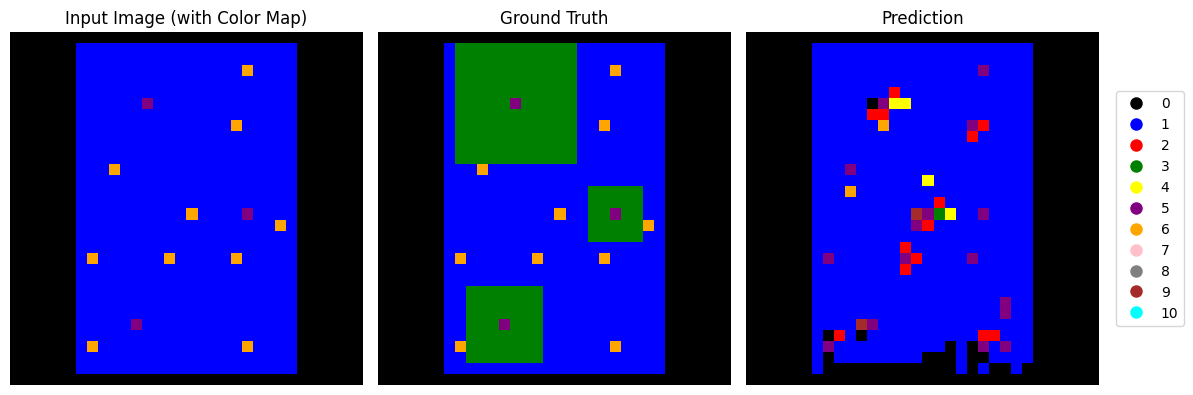


Epoch [761/1000] Complete
Average Loss: 0.000770
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



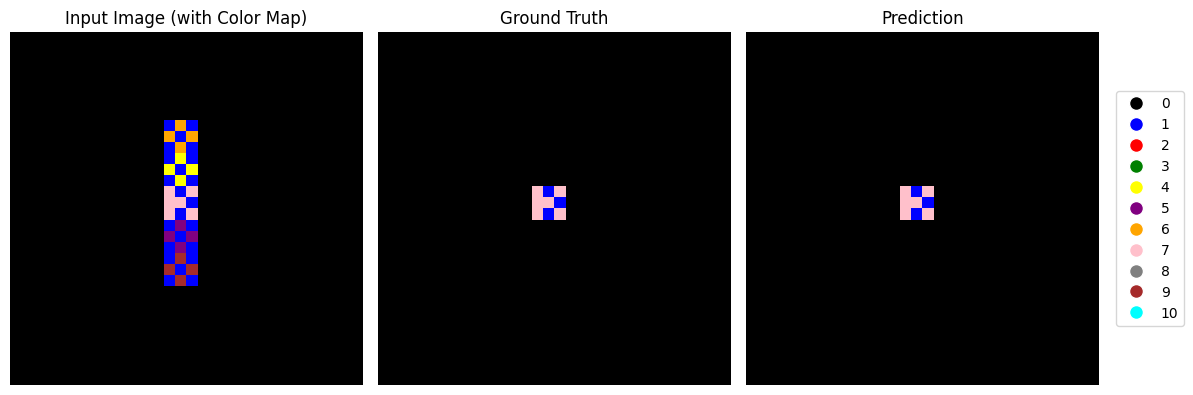

Test Average Loss: 13.907199
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.75%




Epoch [762/1000] Complete
Average Loss: 0.000501
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.171710
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.52%




Epoch [763/1000] Complete
Average Loss: 0.000390
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 13.823201
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.76%




Epoch [764/1000] Complete
Average Loss: 0.000376
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 13.809677
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.66%




Epoch [765/1000] Complete
Average Loss: 0.000319
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 13.825744
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.85%




Epoch [766/1000] Complete
Average Loss: 0.000596
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.299360
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.55%




Epoch [767/1000] Complete
Average Loss: 0.000797
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 13.858129
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.57%




Epoch [768/1000] Complete
Average Loss: 0.000913
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 13.655855
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.72%




Epoch [769/1000] Complete
Average Loss: 0.001421
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.96%



Test Average Loss: 14.580091
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.99%




Epoch [770/1000] Complete
Average Loss: 0.001143
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.95%



Test Average Loss: 15.046126
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.37%



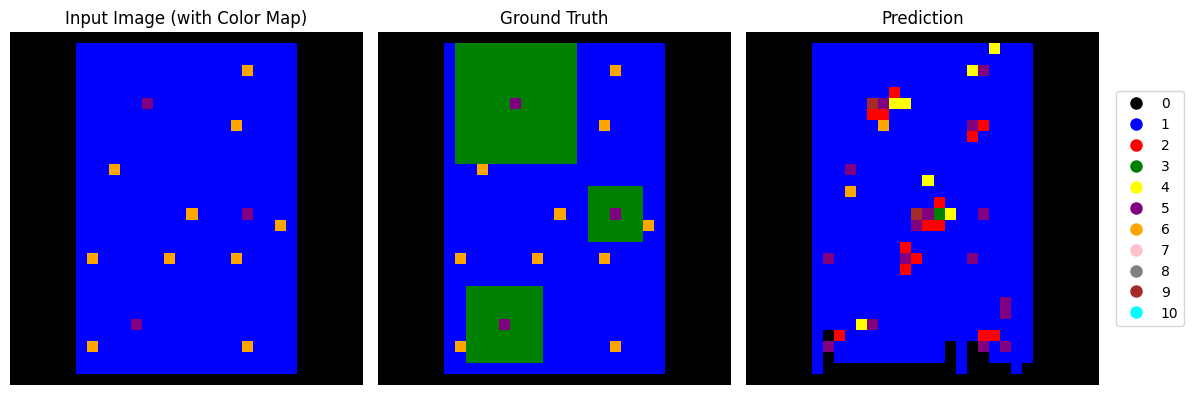


Epoch [771/1000] Complete
Average Loss: 0.000481
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



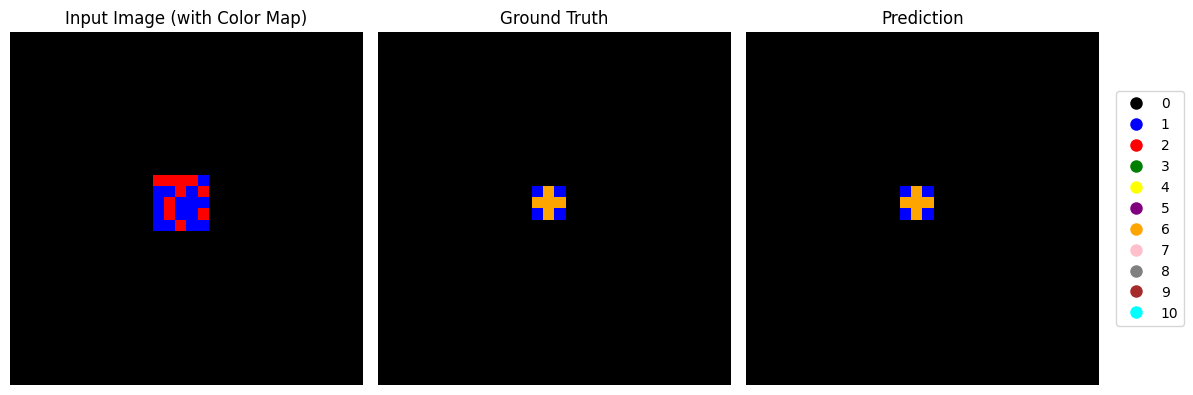

Test Average Loss: 14.476993
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.63%




Epoch [772/1000] Complete
Average Loss: 0.000405
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.583540
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.77%




Epoch [773/1000] Complete
Average Loss: 0.000344
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.370463
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.74%




Epoch [774/1000] Complete
Average Loss: 0.000291
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.309211
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.80%




Epoch [775/1000] Complete
Average Loss: 0.000301
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.283164
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.65%




Epoch [776/1000] Complete
Average Loss: 0.000332
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.182627
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.64%




Epoch [777/1000] Complete
Average Loss: 0.000413
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.310152
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.53%




Epoch [778/1000] Complete
Average Loss: 0.000583
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.915011
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.50%




Epoch [779/1000] Complete
Average Loss: 0.000608
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.408606
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.64%




Epoch [780/1000] Complete
Average Loss: 0.075013
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.86%



Test Average Loss: 11.890046
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.68%



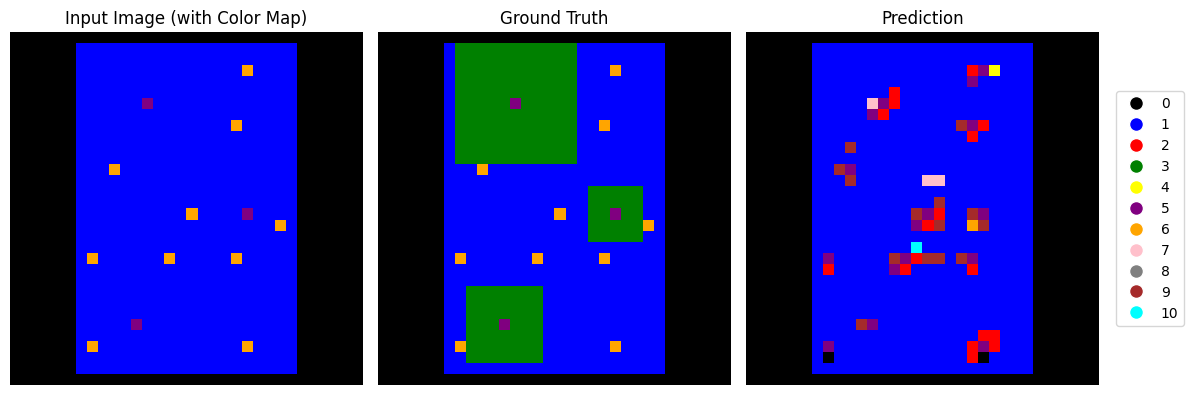


Epoch [781/1000] Complete
Average Loss: 0.117859
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.81%



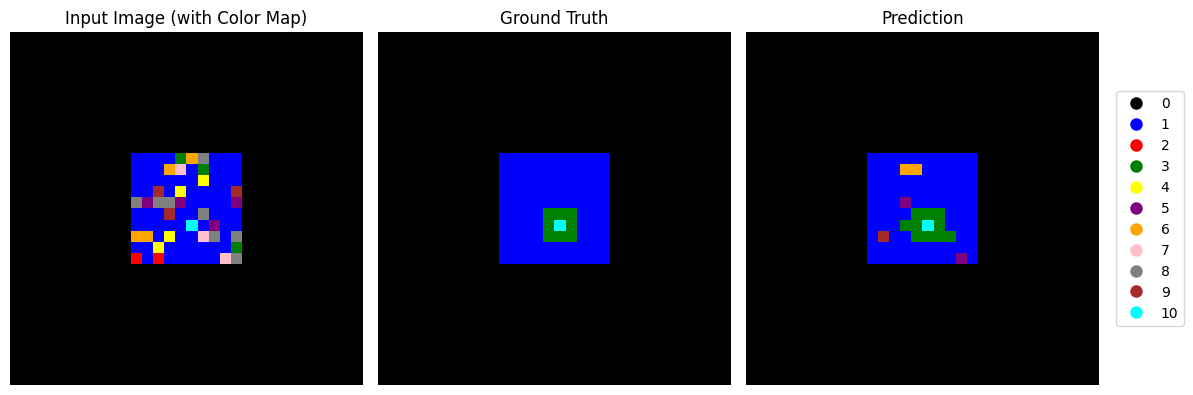

Test Average Loss: 14.587703
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 49.63%




Epoch [782/1000] Complete
Average Loss: 0.049272
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.22%



Test Average Loss: 12.796822
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.90%




Epoch [783/1000] Complete
Average Loss: 0.050259
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.31%



Test Average Loss: 13.458809
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.33%




Epoch [784/1000] Complete
Average Loss: 0.020756
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.23%



Test Average Loss: 14.971061
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.16%




Epoch [785/1000] Complete
Average Loss: 0.010908
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.64%



Test Average Loss: 13.556061
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.29%




Epoch [786/1000] Complete
Average Loss: 0.008403
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 13.900522
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 53.13%




Epoch [787/1000] Complete
Average Loss: 0.012161
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.65%



Test Average Loss: 15.423812
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.27%




Epoch [788/1000] Complete
Average Loss: 0.003808
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.85%



Test Average Loss: 15.205125
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.38%




Epoch [789/1000] Complete
Average Loss: 0.002178
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.93%



Test Average Loss: 15.253057
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.83%




Epoch [790/1000] Complete
Average Loss: 0.000734
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 14.774442
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.07%



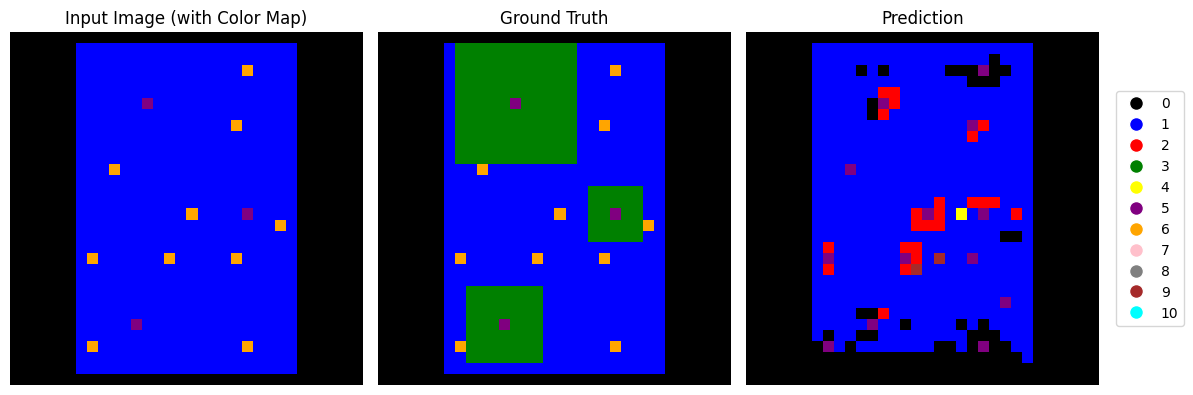


Epoch [791/1000] Complete
Average Loss: 0.000509
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



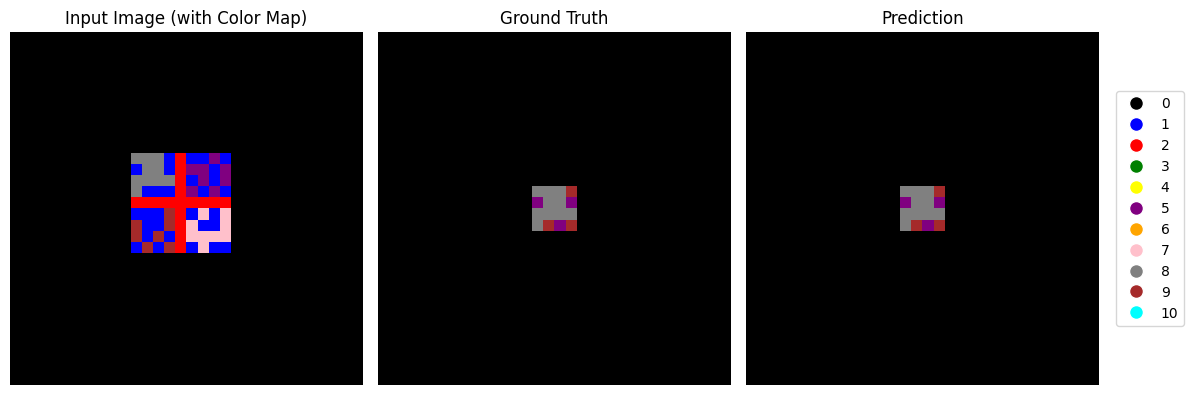

Test Average Loss: 14.285456
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.15%




Epoch [792/1000] Complete
Average Loss: 0.000562
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.894377
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.73%




Epoch [793/1000] Complete
Average Loss: 0.000650
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 14.913504
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.31%




Epoch [794/1000] Complete
Average Loss: 0.000800
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.936017
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.96%




Epoch [795/1000] Complete
Average Loss: 0.000758
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.631115
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.99%




Epoch [796/1000] Complete
Average Loss: 0.000368
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.576082
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.21%




Epoch [797/1000] Complete
Average Loss: 0.000378
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 15.292892
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.13%




Epoch [798/1000] Complete
Average Loss: 0.000324
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.253686
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.13%




Epoch [799/1000] Complete
Average Loss: 0.000567
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.163992
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.05%




Epoch [800/1000] Complete
Average Loss: 0.000693
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 14.817879
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.14%



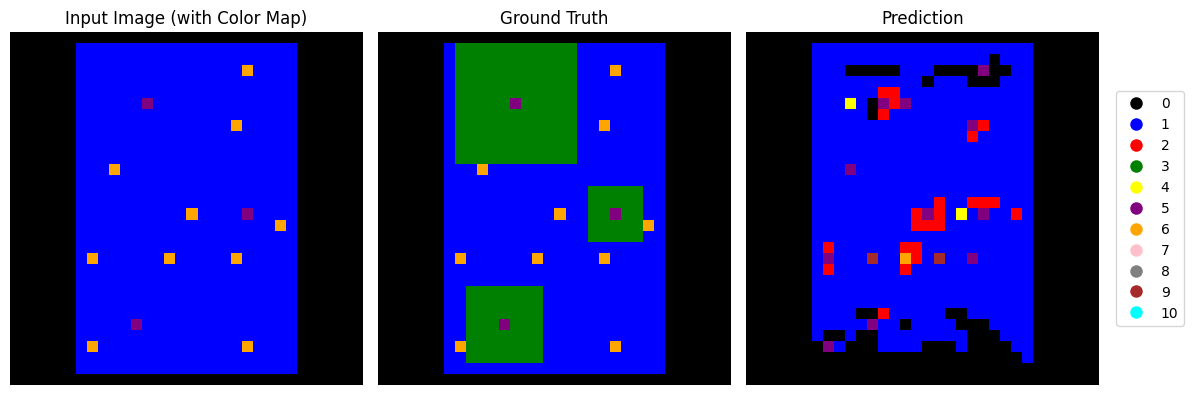


Epoch [801/1000] Complete
Average Loss: 0.000634
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



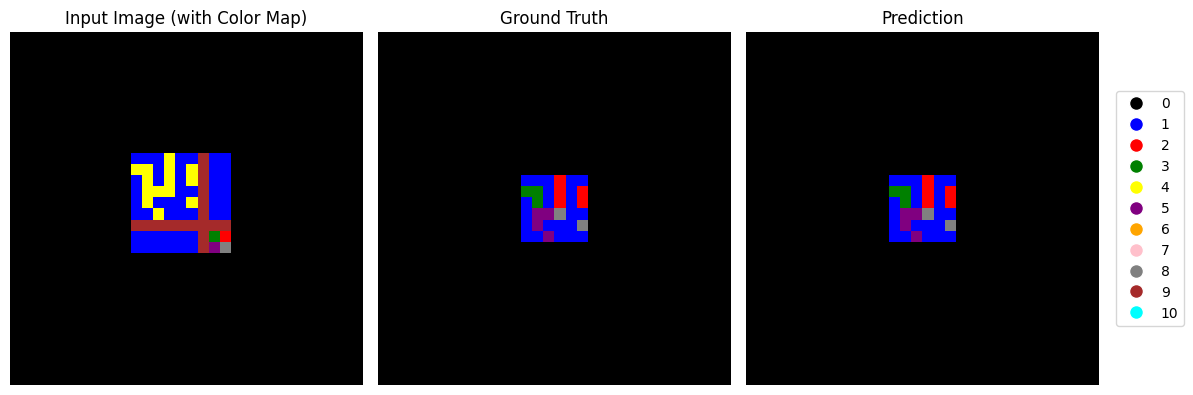

Test Average Loss: 16.104936
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.74%




Epoch [802/1000] Complete
Average Loss: 0.000884
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.372009
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.81%




Epoch [803/1000] Complete
Average Loss: 0.000664
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.051597
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.75%




Epoch [804/1000] Complete
Average Loss: 0.000428
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.446115
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.80%




Epoch [805/1000] Complete
Average Loss: 0.000708
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.353225
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.32%




Epoch [806/1000] Complete
Average Loss: 0.000760
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.596915
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.80%




Epoch [807/1000] Complete
Average Loss: 0.000615
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.692984
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.96%




Epoch [808/1000] Complete
Average Loss: 0.000538
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.949871
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.88%




Epoch [809/1000] Complete
Average Loss: 0.000432
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.960532
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.87%




Epoch [810/1000] Complete
Average Loss: 0.000250
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.240964
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.94%



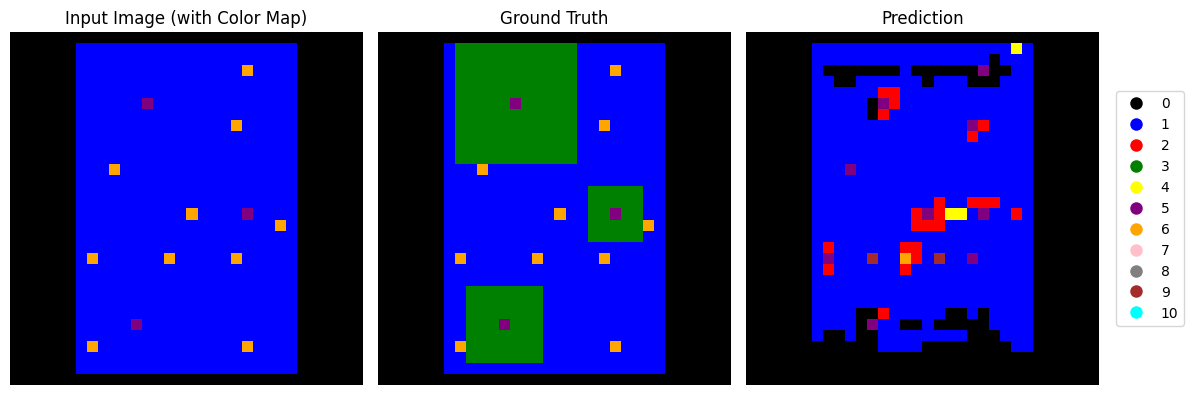


Epoch [811/1000] Complete
Average Loss: 0.000413
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



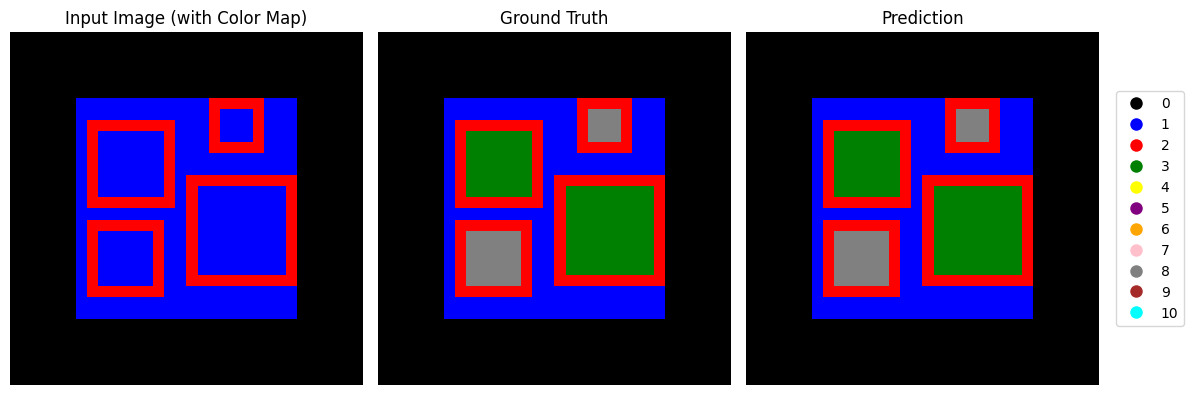

Test Average Loss: 15.943244
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.07%




Epoch [812/1000] Complete
Average Loss: 0.000508
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.621085
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.84%




Epoch [813/1000] Complete
Average Loss: 0.000285
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.629676
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.88%




Epoch [814/1000] Complete
Average Loss: 0.000294
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 15.986615
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.09%




Epoch [815/1000] Complete
Average Loss: 0.000252
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 15.409387
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.93%




Epoch [816/1000] Complete
Average Loss: 0.000334
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 15.522662
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.09%




Epoch [817/1000] Complete
Average Loss: 0.000326
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.413412
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.83%




Epoch [818/1000] Complete
Average Loss: 0.000292
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.99%



Test Average Loss: 15.571134
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.08%




Epoch [819/1000] Complete
Average Loss: 0.000497
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.175598
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.88%




Epoch [820/1000] Complete
Average Loss: 0.000502
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.97%



Test Average Loss: 15.858636
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.92%



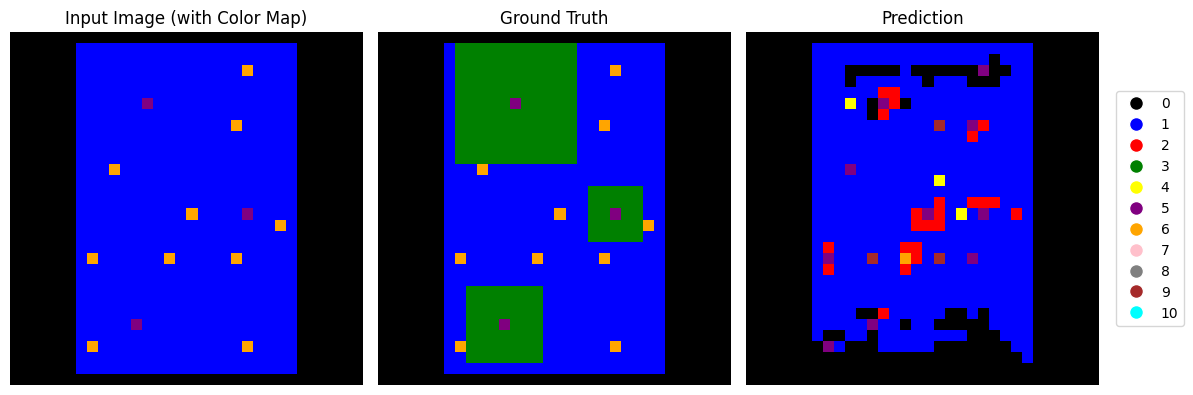


Epoch [821/1000] Complete
Average Loss: 0.000247
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



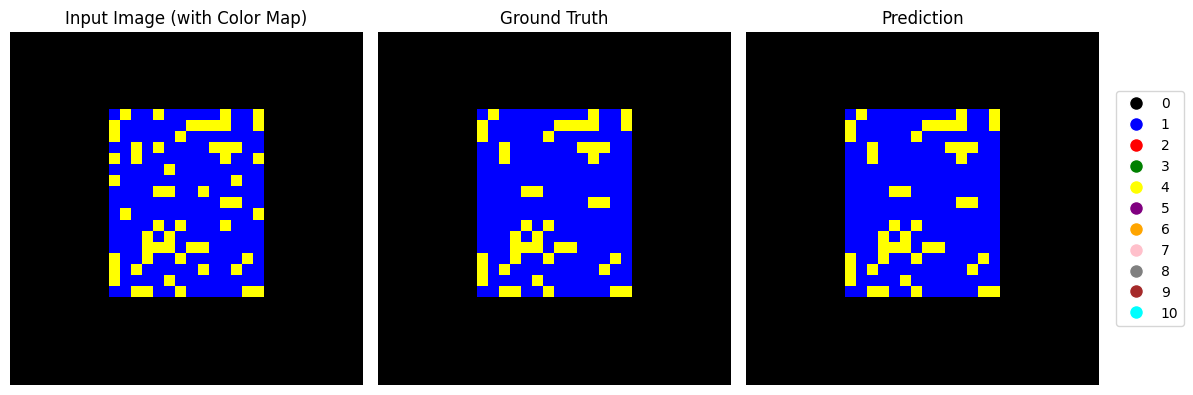

Test Average Loss: 15.847464
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.48%




Epoch [822/1000] Complete
Average Loss: 0.000308
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.071621
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 55.55%




Epoch [823/1000] Complete
Average Loss: 0.000582
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.98%



Test Average Loss: 15.347979
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 54.80%




Epoch [824/1000] Complete
Average Loss: 0.008470
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.75%



Test Average Loss: 11.752403
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.41%




Epoch [825/1000] Complete
Average Loss: 0.068202
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 97.77%



Test Average Loss: 12.800600
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 50.93%




Epoch [826/1000] Complete
Average Loss: 0.175937
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 93.52%



Test Average Loss: 9.411512
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.34%




Epoch [827/1000] Complete
Average Loss: 0.112339
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 95.88%



Test Average Loss: 9.899905
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 51.02%




Epoch [828/1000] Complete
Average Loss: 0.048090
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 98.19%



Test Average Loss: 8.435124
Test Sample Accuracy: 0.00%
Test Pixel Accuracy: 52.06%




Epoch [829/1000] Complete
Average Loss: 0.025214
Training Sample Accuracy: 0.00%
Training Pixel Accuracy: 99.06%



Testing:   5%|▍         | 3/63 [00:00<00:09,  6.12it/s, loss=7.3246] 

In [13]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

train_args = {
    'challenges': train_challenge,
    'solution': train_solution,
    'num_classes': 11,
    'batch_size': 20,
    'epochs': 1000,
    'learning_rate': 0.001,
}

model_args = {
    'dims': (64, 128),
    'heads': 4,
    'ff_expansion': 4,
    'reduction_ratio': 2,
    'num_layers': 4,
    'channels': 1,
    'num_classes': 11,
    'kernel_stride_paddings': ((1, 1, 0),(3, 2, 1))
    }

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    weight = torch.ones(train_args['num_classes']).to(y.device)
    weight[0] = 0.04
    weight[1] = 0.8
    ce = F.cross_entropy(y_pred, y, weight=weight)  # ignore_index=0 추가
    return ce

def calculate_accuracy(predictions, targets, ignore_index=0):
    pred_classes = predictions.argmax(dim=1)  # [batch_size, H, W]
    targets = targets.squeeze(1)  # [batch_size, H, W]
    
    # 마스크 생성: gt가 ignore_index가 아닌 부분만 True
    mask = (targets != ignore_index)
    
    # 이미지 단위 정확도 계산
    correct_samples = pred_classes.eq(targets)  # [batch_size, H, W]
    correct_samples = correct_samples & mask  # 마스크 적용
    correct_samples = correct_samples.view(targets.size(0), -1).all(dim=1).sum().item()
    total_samples = targets.size(0)
    
    # 픽셀 단위 정확도 계산
    correct_pixels = (pred_classes.eq(targets) & mask).sum().item()
    total_pixels = mask.sum().item()
    
    return correct_samples, total_samples, correct_pixels, total_pixels

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def visualize_predictions(inputs, targets, predictions, condition):
    if condition:
        # 입력 이미지와 예측 결과를 CPU로 이동
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        predictions = predictions.detach().cpu().numpy()  # detach()로 그래디언트 추적 중단

        # 첫 번째 배치의 첫 번째 이미지를 시각화
        input_image = inputs[0]            # shape: (C, H, W)
        target_image = targets[0]          # shape: (C, H, W) 또는 (H, W)
        prediction_image = predictions.argmax(axis=1)[0]  # shape: (H, W)

        # 입력 이미지 형태 조정
        if input_image.ndim == 3 and input_image.shape[0] == 1:
            # 채널 차원이 1인 경우, 채널 차원 제거 (단일 채널 이미지)
            input_image = input_image.squeeze(0)  # shape: (H, W)
        elif input_image.ndim == 3 and input_image.shape[0] == 3:
            # RGB 이미지를 범위 0~10으로 정규화하여 컬러맵에 적용
            input_image = input_image.mean(axis=0)  # shape: (H, W)로 변환 (3채널을 단일값으로)

        # 타겟 이미지와 예측 이미지 형태 조정
        if target_image.ndim == 3 and target_image.shape[0] == 1:
            target_image = target_image.squeeze(0)  # shape: (H, W)

        target_image = target_image.astype(int)      # 정수형으로 변환
        prediction_image = prediction_image.astype(int)  # 정수형으로 변환

        # 컬러 맵 정의 (0~10 값을 위한 11개의 색상)
        color_list = ['black', 'blue', 'red', 'green', 'yellow', 'purple', 
                      'orange', 'pink', 'gray', 'brown', 'cyan']
        cmap = ListedColormap(color_list)

        # 시각화를 위한 플롯 생성
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # 입력 이미지에 컬러맵 적용하여 표시
        axes[0].imshow(input_image, cmap=cmap, vmin=0, vmax=10)
        axes[0].set_title('Input Image (with Color Map)')
        axes[0].axis('off')

        # 타겟 이미지 표시 (색상 맵 적용)
        axes[1].imshow(target_image, cmap=cmap, vmin=0, vmax=10)  # 범위를 0~10으로 변경
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        # 예측 결과 표시 (색상 맵 적용)
        axes[2].imshow(prediction_image, cmap=cmap, vmin=0, vmax=10)  # 범위를 0~10으로 변경
        axes[2].set_title('Prediction')
        axes[2].axis('off')

        # 범례를 플롯 내에 표시
        patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=10, label=str(i)) for i in range(11)]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

        plt.tight_layout()  # 레이아웃을 자동으로 조정
        plt.show()


# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

# 데이터셋 및 데이터로더 생성
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=train_args['batch_size'], shuffle=True)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=train_args['batch_size'], shuffle=False)

# 모델 정의
model = ARC_Net(**model_args).to(device)

# 옵티마이저 정의
optimizer = optim.AdamW(model.parameters(), lr=train_args['learning_rate'])


def train(epoch):
    model.train()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    last_task_inputs = None
    last_task_outputs = None
    last_output = None

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{train_args["epochs"]}', leave=False)

    for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
        task_inputs = task_inputs.to(device, non_blocking=True)
        task_outputs = task_outputs.to(device, non_blocking=True)
        ex_inputs = ex_inputs.to(device, non_blocking=True)
        ex_outputs = ex_outputs.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(task_inputs, ex_inputs, ex_outputs)

        # 손실 함수 계산
        loss = criterion(output, task_outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 정확도 계산
        correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs, ignore_index=0)
        total_correct_samples += correct_samples
        total_samples += batch_total_samples
        total_correct_pixels += correct_pixels
        total_pixels += batch_total_pixels

        # 마지막 배치의 데이터 저장
        last_task_inputs = task_inputs.clone()
        last_task_outputs = task_outputs.clone()
        last_output = output.clone()
        
        # 프로그레스 바 업데이트
        progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    # 에포크가 끝난 후
    avg_sample_accuracy = 100. * total_correct_samples / total_samples
    avg_pixel_accuracy = 100. * total_correct_pixels / total_pixels
    avg_loss = total_loss / len(train_loader)

    print(f'\nEpoch [{epoch+1}/{train_args["epochs"]}] Complete')
    print(f'Average Loss: {avg_loss:.6f}')
    print(f'Training Sample Accuracy: {avg_sample_accuracy:.2f}%')
    print(f'Training Pixel Accuracy: {avg_pixel_accuracy:.2f}%\n')

    # 에포크가 10의 배수일 때만 시각화 수행
    if (epoch + 1) % 10 == 1:
        visualize_predictions(last_task_inputs, last_task_outputs, last_output, condition=True)

def test(epoch):
    model.eval()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    last_task_inputs = None
    last_task_outputs = None
    last_output = None

    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader), desc='Testing', leave=False)

    with torch.no_grad():
        for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
            task_inputs = task_inputs.to(device, non_blocking=True)
            task_outputs = task_outputs.to(device, non_blocking=True)
            ex_inputs = ex_inputs.to(device, non_blocking=True)
            ex_outputs = ex_outputs.to(device, non_blocking=True)

            output = model(task_inputs, ex_inputs, ex_outputs)

            # 손실 함수 계산
            loss = criterion(output, task_outputs)
            total_loss += loss.item()

            # 정확도 계산
            correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs, ignore_index=0)
            total_correct_samples += correct_samples
            total_samples += batch_total_samples
            total_correct_pixels += correct_pixels
            total_pixels += batch_total_pixels

            # 마지막 배치의 데이터 저장
            last_task_inputs = task_inputs.clone()
            last_task_outputs = task_outputs.clone()
            last_output = output.clone()
            
            # 프로그레스 바 업데이트
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    avg_sample_accuracy = 100. * total_correct_samples / total_samples
    avg_pixel_accuracy = 100. * total_correct_pixels / total_pixels
    avg_loss = total_loss / len(eval_loader)

    print(f'Test Average Loss: {avg_loss:.6f}')
    print(f'Test Sample Accuracy: {avg_sample_accuracy:.2f}%')
    print(f'Test Pixel Accuracy: {avg_pixel_accuracy:.2f}%\n')

    # 에포크가 10의 배수일 때만 시각화 수행
    if (epoch + 1) % 10 == 0:
        visualize_predictions(last_task_inputs, last_task_outputs, last_output, condition=True)

# 학습 실행
for epoch in range(train_args['epochs']):  
    train(epoch)
    test(epoch)